In [6]:
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from collections import Counter
#import style
import matplotlib.pyplot as plt 
import os 
import time
import numpy as np
from collections import defaultdict, Counter
from scipy import stats

cmap = plt.get_cmap('inferno')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cmap(np.linspace(0, 1, 12)))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '+', 'H','h']
colors = plt.cm.inferno(np.linspace(0, 1, 12))

#plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=17)
plt.rc('lines', markersize=6)
plt.rc('lines', linewidth=2)
plt.rc('legend', loc='best')
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', family='serif')

class StressStrainData:
    def __init__(self) -> None:
        self.rods = {}
        self.layers = {}
        self.particles = {}
        self.lid_min = +np.inf
        self.lid_max = -np.inf

    def copy(self):
        ssd = StressStrainData()
        for rid, rod in self.rods.items():
            ssd.rods[rid] = rod.copy()
            ssd.rods[rid].ssd = ssd
        
        for pid, particle in self.particles.items():
            ssd.particles[pid] = particle.copy()
            ssd.particles[pid].ssd = ssd
        
        for lid, layer in self.layers.items():
            ssd.layers[lid] = layer.copy()

        ssd.lid_min = self.lid_min
        ssd.lid_max = self.lid_max
        return ssd

    def num_active_particles(self):
        k = 0
        for particle in self.particles.values():
            if particle.active:
                k +=1
        return k
    
    def filter_rids(self, reverse: bool = True):
        active_rids = set()
        for i, lid in enumerate(sorted(range(self.lid_min, self.lid_max + 1), reverse=reverse)):
            # pids in the current layer
            lid_pids = self.layers[lid].pids

            if i == 0:
                for pid_A in lid_pids:
                    particle_A: Particle = self.particles[pid_A]
                    active_rids.add(particle_A.rid)                    
                continue
            
            # layer is empty
            if len(lid_pids) == 0:
                active_rids.clear()
                return active_rids, self.rods.keys()

            for pid_A in lid_pids:
                particle_A: Particle = self.particles[pid_A]
                for rid_B in particle_A.get_neigh_rids():
                    if rid_B in active_rids:
                        active_rids.add(particle_A.rid)
                        break
        deleted_rids = self.clear_rids(active_rids)
        return active_rids, deleted_rids

    def clear_rids(self, active_rids:set):
        # inactive rods        
        deleted_rids = set()
        for rid in self.rods:
            if rid not in active_rids:
                self.rods[rid].inactivate()                
                deleted_rids.add(rid)
        # update rods
        self.rods = {rid: self.rods[rid] for rid in self.rods if rid not in deleted_rids}
        return deleted_rids
    
    def drop_rids(self, to_drop: set):
        # inactivate rods        
        for rid in self.rods:
            if rid in to_drop:
                self.rods[rid].inactivate()
        # update rods
        self.rods = {rid: self.rods[rid] for rid in self.rods if rid not in to_drop}
    
    def set_rods_exponent(self, m:int):
        for rod in self.rods.values():
            rod.m = m

    def count_total_neighbors_for_rods(self):
        rod_total_neighbors = {}

        for rod in self.rods.values():
            total_neighbors = 0
            for pid in rod.pids:
                particle = self.particles[pid]
                total_neighbors += len(particle.neigh_rids)
            
            rod_total_neighbors[rod.rid] = total_neighbors

        return rod_total_neighbors

class Particle:
    def __init__(self, ssd:StressStrainData, pid: int, rid: int, lid: int, xz):
        self.pid = pid
        self.rid = rid
        self.lid = lid
        self.xz = xz
        self.active = True
        self.neigh_rids = set()
        self.ssd = ssd

    def copy(self):
        particle = Particle(self.ssd, self.pid, self.rid, self.lid, self.xz.copy())
        particle.active = self.active
        particle.neigh_rids = self.neigh_rids.copy()
        return particle

    def add_neigh_rid(self, rid:int):
        self.neigh_rids.add(rid)
        rod : Rod = self.ssd.rods[rid]
        rod.add_neigh_pid(self.pid)

    def del_neigh_rid(self, rid:int):
        self.neigh_rids.remove(rid)

    def get_neigh_rids(self):
        return self.neigh_rids

    def innactive(self):
        self.active = False
        # remove the particle from the layer
        layer: Layer = self.ssd.layers[self.lid]
        layer.del_pid(self.pid)
        for rid in self.neigh_rids:
            # remove the particle from the neigh rods
            rod: Rod = self.ssd.rods[rid]
            rod.del_neigh_pid(self.pid)

    def to_str(self):
        s = f'"pid": {self.pid}, "rid": {self.rid}, "lid": {self.lid}, "xz": [{self.xz[0]}, {self.xz[1]}]'
        s += ', "neigh_rids": ['
        for rid in self.neigh_rids:
            s += f'{rid},'
        s += ']'
        s = '{' + s.replace(',]', ']') + '}'        
        return s

    @staticmethod
    def parse(ssd: StressStrainData, row: str):
        row = json.loads(row)
        pid = row['pid']
        rid = row['rid']
        lid = row['lid']
        xz = np.array(row['xz'], dtype=float)
        particle = Particle(ssd, pid, rid, lid, xz)
        particle.neigh_rids = set(row['neigh_rids'])
        particle.active = True
        return particle
    
class Rod:
    def __init__(self, ssd:StressStrainData, rid:int):
        self.ssd = ssd
        self.rid = rid
        self.active = True
        self.pids = set()
        self.updated = False
        self.neigh_pids = set()

        # force parameters
        self.m = 2
        self.sigma_cte = 1

        # force variables
        self.N = 0
        self.p = 0
        self.F = 1
        self.sigma_mean = 0

    def copy(self):
        rod = Rod(self.ssd, self.rid)
        rod.active = self.active
        rod.pids = self.pids.copy()
        rod.updated = self.updated
        rod.neigh_pids = self.neigh_pids.copy()

        # force parameters
        rod.m = self.m
        rod.sigma_cte = self.sigma_cte

        # force variables
        rod.N = self.N
        rod.p = self.p
        rod.F = self.F
        rod.sigma_mean = self.sigma_mean

        return rod
        
    def add_pid(self, pid:int):
        self.pids.add(pid)
        self.updated = False

    def del_neigh_pid(self, pid:int):
        self.neigh_pids.remove(pid)
        self.updated = False

    def add_neigh_pid(self, pid:int):
        self.neigh_pids.add(pid)
        self.updated = False

    def inactivate(self):
        self.active = False
        for pid in self.pids:
            particle:Particle = self.ssd.particles[pid]
            particle.innactive()

        for pid in self.neigh_pids:
            particle:Particle = self.ssd.particles[pid]
            particle.del_neigh_rid(self.rid)

    def update_force(self, F:float):
        self.N = len(self.neigh_pids)
        if self.N == 0:
            self.p = 1 # if rod not have neighs, the prob
            return self.p            
        self.sigma_mean *= (F / self.F)
        self.p = (self.sigma_mean / (self.N * self.sigma_cte))**self.m
        self.F = F # update the force
        return self.p

    def update_sigma(self, F: float):
        n = np.zeros(len(self.pids)) # number of neigh_pids per layer
        for i, pid_A in enumerate(self.pids):
            particle: Particle = self.ssd.particles[pid_A]
            n[i] = self.ssd.layers[particle.lid].len()
        self.sigma_mean = np.mean(self.F / n)
        self.updated = True
        return self.update_force(F)
            
    def prob_break(self, F:float):
        if self.updated:
            return self.update_force(F)
        else:
            return self.update_sigma(F)
    
    def to_str(self):
        s = f'"rid": {self.rid}, "pids": ['
        for pid in self.pids:
            s += f'{pid},'
        s += '], "neigh_pids": ['
        for pid in self.neigh_pids:
            s += f'{pid},'
        s += ']'
        s = '{' + s.replace(',]', ']') + '}'
        return s    

    @staticmethod
    def parse(ssd: StressStrainData, row: str):
        row = json.loads(row)
        rid = row['rid']
        rod = Rod(ssd, rid)
        rod.pids = set(row['pids'])
        rod.neigh_pids = set(row['neigh_pids'])
        rod.active = True
        rod.updated = False
        return rod
                    
class Layer:
    def __init__(self, lid:int):
        self.lid = lid
        self.pids = set()

    def copy(self):
        layer = Layer(self.lid)
        layer.pids = self.pids.copy()
        return layer

    def len(self):
        return len(self.pids)

    def add_pid(self, pid:int):
        self.pids.add(pid)

    def del_pid(self, pid:int):
        if pid in self.pids:
            self.pids.remove(pid)

    def to_str(self):
        s = f'"lid": {self.lid}, "pids": ['
        for pid in self.pids:
            s += f'{pid},'
        s += ']'
        s = '{' + s.replace(',]', ']') + '}'
        return s
    
    @staticmethod
    def parse(row:str):
        row = json.loads(row)
        lid = row['lid']
        layer = Layer(lid)
        layer.pids = set(row['pids'])
        return layer

def create_neighs(layers: dict, particles: dict):
    # create connections
    #print('Creating connections')
    for pid_A in particles:
        particle_A: Particle = particles[pid_A]
        for pid_B in layers[particle_A.lid].pids:
            if pid_A == pid_B:
                continue
            particle_B: Particle = particles[pid_B]
            # check if the particles are neighbors
            if np.linalg.norm(particle_A.xz - particle_B.xz) <= 1:
                particle_A.add_neigh_rid(particle_B.rid)
                particle_B.add_neigh_rid(particle_A.rid)

def read_or_create_ssd(fn_dat: str):
    fn_db = fn_dat.replace('.dat','.db')
    ssd = StressStrainData()

    if os.path.exists(fn_db):
        print('Reading ', fn_db)
        tic = time.time()
        with open(fn_db, 'r') as fid:
            for row in fid:
                if row.startswith('{"pid":'):
                    particle = Particle.parse(ssd, row)
                    ssd.particles[particle.pid] = particle
                if row.startswith('{"rid":'):
                    rod = Rod.parse(ssd, row)
                    ssd.rods[rod.rid] = rod
                if row.startswith('{"lid":'):
                    layer = Layer.parse(row)
                    ssd.layers[layer.lid] = layer
        ssd.lid_min = min(ssd.layers.keys())
        ssd.lid_max = max(ssd.layers.keys())
        toc = time.time() - tic
        #print(f'   tElapsed {fn_db} in {toc:.2f} s')
        return ssd

    print('Creating ', fn_db)
    pid = 0
    with open(fn_dat, 'r') as fid:
        # each line is a particle and a rod is a set of particles
        for row in fid:
            row = row.split()
            # extract the fiber center (rectangular trapezoid)
            x = int(row[2])
            y = int(row[3])
            z = int(row[4])
            if np.abs(x) > 8:
                continue
            if np.abs(y) > 100:
                continue
            if np.abs(z) > 8:
                continue
            # add particle to the backbone
            rid = int(row[1])
            lid = y
            xz = np.array([x, z])
            p = Particle(ssd, pid, rid, lid, xz)
            # add particle to the backbone
            ssd.particles[pid] = p
            # add particle to the rod
            if rid not in ssd.rods:
                ssd.rods[rid] = Rod(ssd,rid)
            ssd.rods[rid].add_pid(pid)
            # add particle to the layer
            if lid not in ssd.layers:
                ssd.layers[lid] = Layer(lid)
            ssd.layers[lid].add_pid(pid)
            pid += 1
    lid = list(ssd.layers.keys())
    ssd.lid_max = int(max(lid))                                         
    ssd.lid_min = int(min(lid))
    
    create_neighs(ssd.layers, ssd.particles)

    # save the database
    with open(fn_db, 'w') as fid:
        for pid in ssd.particles:
            fid.write(ssd.particles[pid].to_str() + '\n')
        for rid in ssd.rods:
            fid.write(ssd.rods[rid].to_str() + '\n')
        for lid in ssd.layers:
            fid.write(ssd.layers[lid].to_str() + '\n')

    return ssd
# A função create_neighs e o resto da classe permanecem os mesmos.


cmap = plt.get_cmap('inferno')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cmap(np.linspace(0, 1, 10)))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '+', 'H']

#plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=15)
plt.rc('lines', markersize=6)
plt.rc('lines', linewidth=3)
plt.rc('legend', loc='best')
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', family='serif')

In [4]:
# Estruturas para armazenar informações
pid_neighbors_count = Counter()
rid_to_pid = defaultdict(set)

path = r'C:\Users\55859\Datas\Collagen_fibril_zurik_ext'
#path = '/home/robert/Datas/Cores_fibrils/ts_8192_seed_6160.db' 

try:
    with open(path, 'r') as file:
        for line in file:
            data = json.loads(line.strip())
            if 'pid' in data and 'rid' in data:
                pid = data['pid']
                rid = data['rid']
                rid_to_pid[rid].add(pid)

                neigh_rids = data.get('neigh_rids', [])
                pid_neighbors_count[pid] = len(neigh_rids)

except Exception as e:
    print(f"Erro ao processar o arquivo: {e}")

# Agora somamos o número de vizinhos de todos os 'pids' para cada 'rid'
links_count = {rid: sum(pid_neighbors_count[pid] for pid in pids) for rid, pids in rid_to_pid.items()}

# Opcional: Salvar o resultado em um arquivo
output_file_path = 'saida_vizinhos_por_rid.json'
try:
    with open(output_file_path, 'w') as outfile:
        json.dump(links_count, outfile, indent=4)
    print(f"Dados salvos com sucesso em {output_file_path}")
except Exception as e:
    print(f"Erro ao salvar o arquivo: {e}")


# Em seguida, calculamos a distribuição desses números de vizinhos
distribution = Counter(links_count.values())
distribution

x = sorted(list(distribution.keys()))
y = np.array([distribution[i] for i in x])
y = y/sum(y)

Erro ao processar o arquivo: [Errno 13] Permission denied: 'C:\\Users\\55859\\Datas\\Collagen_fibril_zurik_ext'
Dados salvos com sucesso em saida_vizinhos_por_rid.json


In [2]:
# Caminho para a pasta 'Core_fibrils'
path = r'C:\Users\55859\Datas\Cores_fibrils'
#path = '/home/robert/Datas/Cores_fibrils'

# Dicionário para armazenar os resultados finais
final_results = defaultdict(lambda: defaultdict(int))

# Listando todos os arquivos no diretório
for filename in os.listdir(path):
    if filename.startswith("ts_") and filename.endswith(".db"):
        ts_value = int(filename.split('_')[1].split('.')[0])  # Extraindo o valor de 'ts'

        file_path = os.path.join(path, filename)
        
        # Inicializando as estruturas de dados para este arquivo
        pid_neighbors_count = Counter()
        rid_to_pid = defaultdict(set)

        ###
        # Processando o arquivo
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    data = json.loads(line.strip())
                    if 'pid' in data and 'rid' in data:
                        pid = data['pid']
                        rid = data['rid']
                        rid_to_pid[rid].add(pid)

                        neigh_rids = data.get('neigh_rids', [])
                        pid_neighbors_count[pid] = len(neigh_rids)

            # Somando o número de vizinhos de todos os 'pids' para cada 'rid'
            links_count = {rid: sum(pid_neighbors_count[pid] for pid in pids) for rid, pids in rid_to_pid.items()}
        ###
            # Calculando a distribuição
            distribution = Counter(links_count.values())

            # Preparando os dados x e y
            x = sorted(distribution.keys())
            y = np.array([distribution[i] for i in x])
            

            # Agregando os resultados
            for x_val, y_val in zip(x, y):
                final_results[ts_value][x_val] += y_val

        except Exception as e:
            print(f"Erro ao processar o arquivo {filename}: {e}")

# Convertendo os resultados finais para uma forma mais fácil de usar
final_results = {ts: dict(values) for ts, values in final_results.items()}
fr = {ts: final_results[ts] for ts in sorted(final_results)}
# Exibindo os resultados
for ts, values in fr.items():
    print(f"ts: {ts}, distribuição: {values}")


ts: 2, distribuição: {0: 88, 1: 67, 2: 269, 3: 31, 4: 108, 5: 34, 6: 250, 7: 17, 8: 183, 9: 26, 10: 279, 11: 28, 12: 319, 13: 17, 14: 354, 15: 19, 16: 402, 18: 405, 19: 21, 20: 463, 22: 313, 23: 11, 24: 444, 25: 10, 26: 414, 27: 8, 28: 410, 30: 393, 32: 339, 34: 362, 36: 288, 38: 280, 40: 223, 42: 192, 44: 187, 46: 152, 48: 128, 50: 86, 51: 1, 52: 85, 54: 52, 56: 52, 58: 30, 60: 26, 62: 9, 64: 7, 17: 11, 21: 3, 29: 5, 33: 6, 35: 5, 39: 2, 43: 3, 68: 3, 31: 4, 61: 1, 37: 5, 66: 5, 53: 1, 72: 1}
ts: 8, distribuição: {0: 63, 1: 50, 2: 192, 3: 53, 4: 114, 5: 23, 6: 139, 7: 17, 8: 115, 9: 12, 10: 210, 11: 21, 12: 201, 14: 277, 15: 39, 16: 291, 18: 370, 19: 17, 20: 453, 22: 310, 23: 22, 24: 434, 26: 426, 27: 23, 28: 462, 30: 483, 31: 11, 32: 497, 34: 479, 36: 433, 37: 6, 38: 454, 39: 11, 40: 424, 41: 5, 42: 430, 44: 385, 45: 6, 46: 311, 48: 310, 50: 247, 51: 3, 52: 232, 54: 177, 56: 167, 58: 116, 60: 95, 62: 62, 64: 42, 66: 16, 68: 6, 13: 9, 33: 15, 70: 5, 21: 13, 25: 8, 29: 12, 17: 9, 35: 1

In [10]:

# Uso do código
ssd = read_or_create_ssd('/home/robert/Datas/Cores_fibrils/ts_8192_seed_6160.db')
total_neighbors_count = ssd.count_total_neighbors_for_rods()

# Exibindo os resultados
for rid, count in total_neighbors_count.items():
    print(f"Rod {rid} tem um total de {count} ligações.")


Reading  /home/robert/Datas/Cores_fibrils/ts_8192_seed_6160.db
Rod 0 tem um total de 62 ligações.
Rod 1 tem um total de 52 ligações.
Rod 2 tem um total de 42 ligações.
Rod 3 tem um total de 62 ligações.
Rod 4 tem um total de 60 ligações.
Rod 5 tem um total de 46 ligações.
Rod 6 tem um total de 58 ligações.
Rod 7 tem um total de 58 ligações.
Rod 8 tem um total de 64 ligações.
Rod 9 tem um total de 56 ligações.
Rod 10 tem um total de 44 ligações.
Rod 11 tem um total de 62 ligações.
Rod 12 tem um total de 58 ligações.
Rod 13 tem um total de 56 ligações.
Rod 14 tem um total de 48 ligações.
Rod 15 tem um total de 64 ligações.
Rod 16 tem um total de 54 ligações.
Rod 17 tem um total de 56 ligações.
Rod 18 tem um total de 58 ligações.
Rod 19 tem um total de 70 ligações.
Rod 20 tem um total de 44 ligações.
Rod 21 tem um total de 64 ligações.
Rod 22 tem um total de 60 ligações.
Rod 23 tem um total de 64 ligações.
Rod 24 tem um total de 62 ligações.
Rod 25 tem um total de 50 ligações.
Rod 26 tem 

In [ ]:
# Caminho para a pasta 'Core_fibrils'
directory_path = '/home/robert/Datas/Cores_fibrils'

# Dicionário para armazenar os resultados finais
final_results = defaultdict(lambda: defaultdict(int))

# Listando todos os arquivos no diretório
for filename in os.listdir(directory_path):
    if filename.startswith("ts_") and filename.endswith(".db"):
        ts_value = int(filename.split('_')[1].split('.')[0])  # Extraindo o valor de 'ts'

        file_path = os.path.join(directory_path, filename)
        
        # Inicializando as estruturas de dados para este arquivo
        pid_neighbors_count = Counter()
        rid_to_pid = defaultdict(set)

        ###
        # Processando o arquivo
        try:
            # Uso do código
            ssd = read_or_create_ssd(file_path)
            total_neighbors_count = ssd.count_total_neighbors_for_rods()

        ###
            # Calculando a distribuição
            distribution = Counter(total_neighbors_count.values())

            # Preparando os dados x e y
            x = sorted(distribution.keys())
            y = np.array([distribution[i] for i in x])
            

            # Agregando os resultados
            for x_val, y_val in zip(x, y):
                final_results[ts_value][x_val] += y_val

        except Exception as e:
            print(f"Erro ao processar o arquivo {filename}: {e}")

# Convertendo os resultados finais para uma forma mais fácil de usar
final_results = {ts: dict(values) for ts, values in final_results.items()}

# Exibindo os resultados
for ts, values in final_results.items():
    print(f"ts: {ts}, distribuição: {values}")


In [11]:
total_neighbors_count

{0: 62,
 1: 52,
 2: 42,
 3: 62,
 4: 60,
 5: 46,
 6: 58,
 7: 58,
 8: 64,
 9: 56,
 10: 44,
 11: 62,
 12: 58,
 13: 56,
 14: 48,
 15: 64,
 16: 54,
 17: 56,
 18: 58,
 19: 70,
 20: 44,
 21: 64,
 22: 60,
 23: 64,
 24: 62,
 25: 50,
 26: 66,
 27: 32,
 28: 32,
 29: 56,
 30: 60,
 31: 64,
 32: 66,
 33: 64,
 34: 64,
 35: 58,
 36: 64,
 37: 64,
 38: 64,
 39: 54,
 40: 60,
 41: 64,
 42: 48,
 43: 48,
 44: 48,
 45: 52,
 46: 58,
 47: 60,
 48: 58,
 49: 66,
 50: 34,
 51: 54,
 52: 58,
 53: 62,
 54: 62,
 55: 46,
 56: 28,
 57: 44,
 58: 60,
 59: 60,
 60: 66,
 62: 54,
 63: 36,
 64: 66,
 65: 58,
 66: 60,
 67: 58,
 68: 62,
 69: 54,
 70: 60,
 71: 52,
 72: 24,
 73: 58,
 75: 64,
 76: 62,
 77: 66,
 78: 60,
 79: 60,
 80: 68,
 81: 60,
 83: 56,
 84: 54,
 85: 60,
 87: 68,
 89: 60,
 90: 58,
 91: 60,
 92: 62,
 93: 64,
 94: 64,
 98: 62,
 100: 64,
 101: 68,
 103: 56,
 104: 58,
 106: 46,
 107: 60,
 109: 54,
 110: 58,
 112: 56,
 113: 68,
 114: 60,
 115: 70,
 116: 64,
 118: 68,
 119: 60,
 120: 52,
 121: 24,
 122: 64,
 123: 62,
 

In [14]:
distribution = Counter(total_neighbors_count.values())

In [16]:
distribution[]

2

In [4]:
final_results[128]

{1: 25,
 2: 127,
 3: 160,
 4: 203,
 5: 4,
 6: 177,
 8: 161,
 10: 63,
 11: 50,
 12: 82,
 13: 26,
 14: 89,
 15: 84,
 16: 148,
 17: 32,
 18: 169,
 19: 18,
 20: 239,
 21: 13,
 22: 140,
 23: 33,
 24: 259,
 25: 34,
 26: 247,
 27: 31,
 28: 302,
 29: 23,
 30: 370,
 31: 18,
 32: 409,
 33: 42,
 34: 436,
 35: 15,
 36: 536,
 37: 20,
 38: 681,
 40: 727,
 41: 32,
 42: 788,
 43: 15,
 44: 961,
 45: 26,
 46: 1095,
 47: 21,
 48: 1159,
 49: 22,
 50: 1182,
 52: 1315,
 53: 10,
 54: 1328,
 56: 1402,
 57: 10,
 58: 1371,
 59: 14,
 60: 1460,
 62: 1159,
 63: 7,
 64: 1003,
 66: 642,
 68: 397,
 70: 148,
 72: 29,
 9: 9,
 39: 32,
 51: 18,
 55: 11,
 0: 12,
 7: 9,
 61: 6}

In [7]:
final_results[2]

{0: 97,
 1: 74,
 2: 298,
 3: 42,
 4: 129,
 6: 288,
 7: 19,
 8: 201,
 10: 309,
 12: 355,
 13: 18,
 14: 385,
 15: 21,
 16: 440,
 17: 12,
 18: 443,
 19: 22,
 20: 515,
 22: 348,
 23: 12,
 24: 488,
 25: 10,
 26: 448,
 28: 453,
 29: 6,
 30: 437,
 32: 366,
 34: 406,
 36: 315,
 38: 296,
 40: 245,
 42: 205,
 44: 203,
 46: 166,
 48: 133,
 50: 100,
 52: 92,
 54: 58,
 56: 60,
 58: 33,
 60: 30,
 62: 9,
 64: 7,
 66: 5,
 5: 38,
 9: 28,
 11: 30,
 27: 8,
 31: 5,
 35: 5,
 39: 2,
 43: 3,
 53: 1,
 68: 3,
 37: 5,
 21: 3,
 33: 7,
 61: 1,
 47: 1,
 51: 1,
 72: 1}

In [6]:
dist_ts = final_results[2]
print(dist_ts)
x = sorted(dist_ts.keys())
y = np.array([dist_ts[i] for i in x])
y_normalized = y / sum(y)

{0: 88, 1: 67, 2: 269, 3: 31, 4: 108, 5: 34, 6: 250, 7: 17, 8: 183, 9: 26, 10: 279, 11: 28, 12: 319, 13: 17, 14: 354, 15: 19, 16: 402, 17: 11, 18: 405, 20: 463, 22: 313, 23: 11, 24: 444, 25: 10, 26: 414, 27: 8, 28: 410, 30: 393, 31: 4, 32: 339, 34: 362, 35: 5, 36: 288, 38: 280, 39: 2, 40: 223, 42: 192, 43: 3, 44: 187, 46: 152, 48: 128, 50: 86, 52: 85, 53: 1, 54: 52, 56: 52, 58: 30, 60: 26, 66: 5, 68: 3, 19: 21, 51: 1, 62: 9, 64: 7, 21: 3, 29: 5, 33: 6, 37: 5, 61: 1, 72: 1}


/tmp/ipykernel_15373/3508407694.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  moda = stats.mode(dados)[0][0]  # Retorna o valor mais frequente


Média: 31.42622950819672
Mediana: 30.0
Moda: 0
Desvio Padrão: 19.802743089778783
Variância: 392.14863387978136
Amplitude: 72
Assimetria: 0.22801692684393704
Curtose: -1.0145148447521761


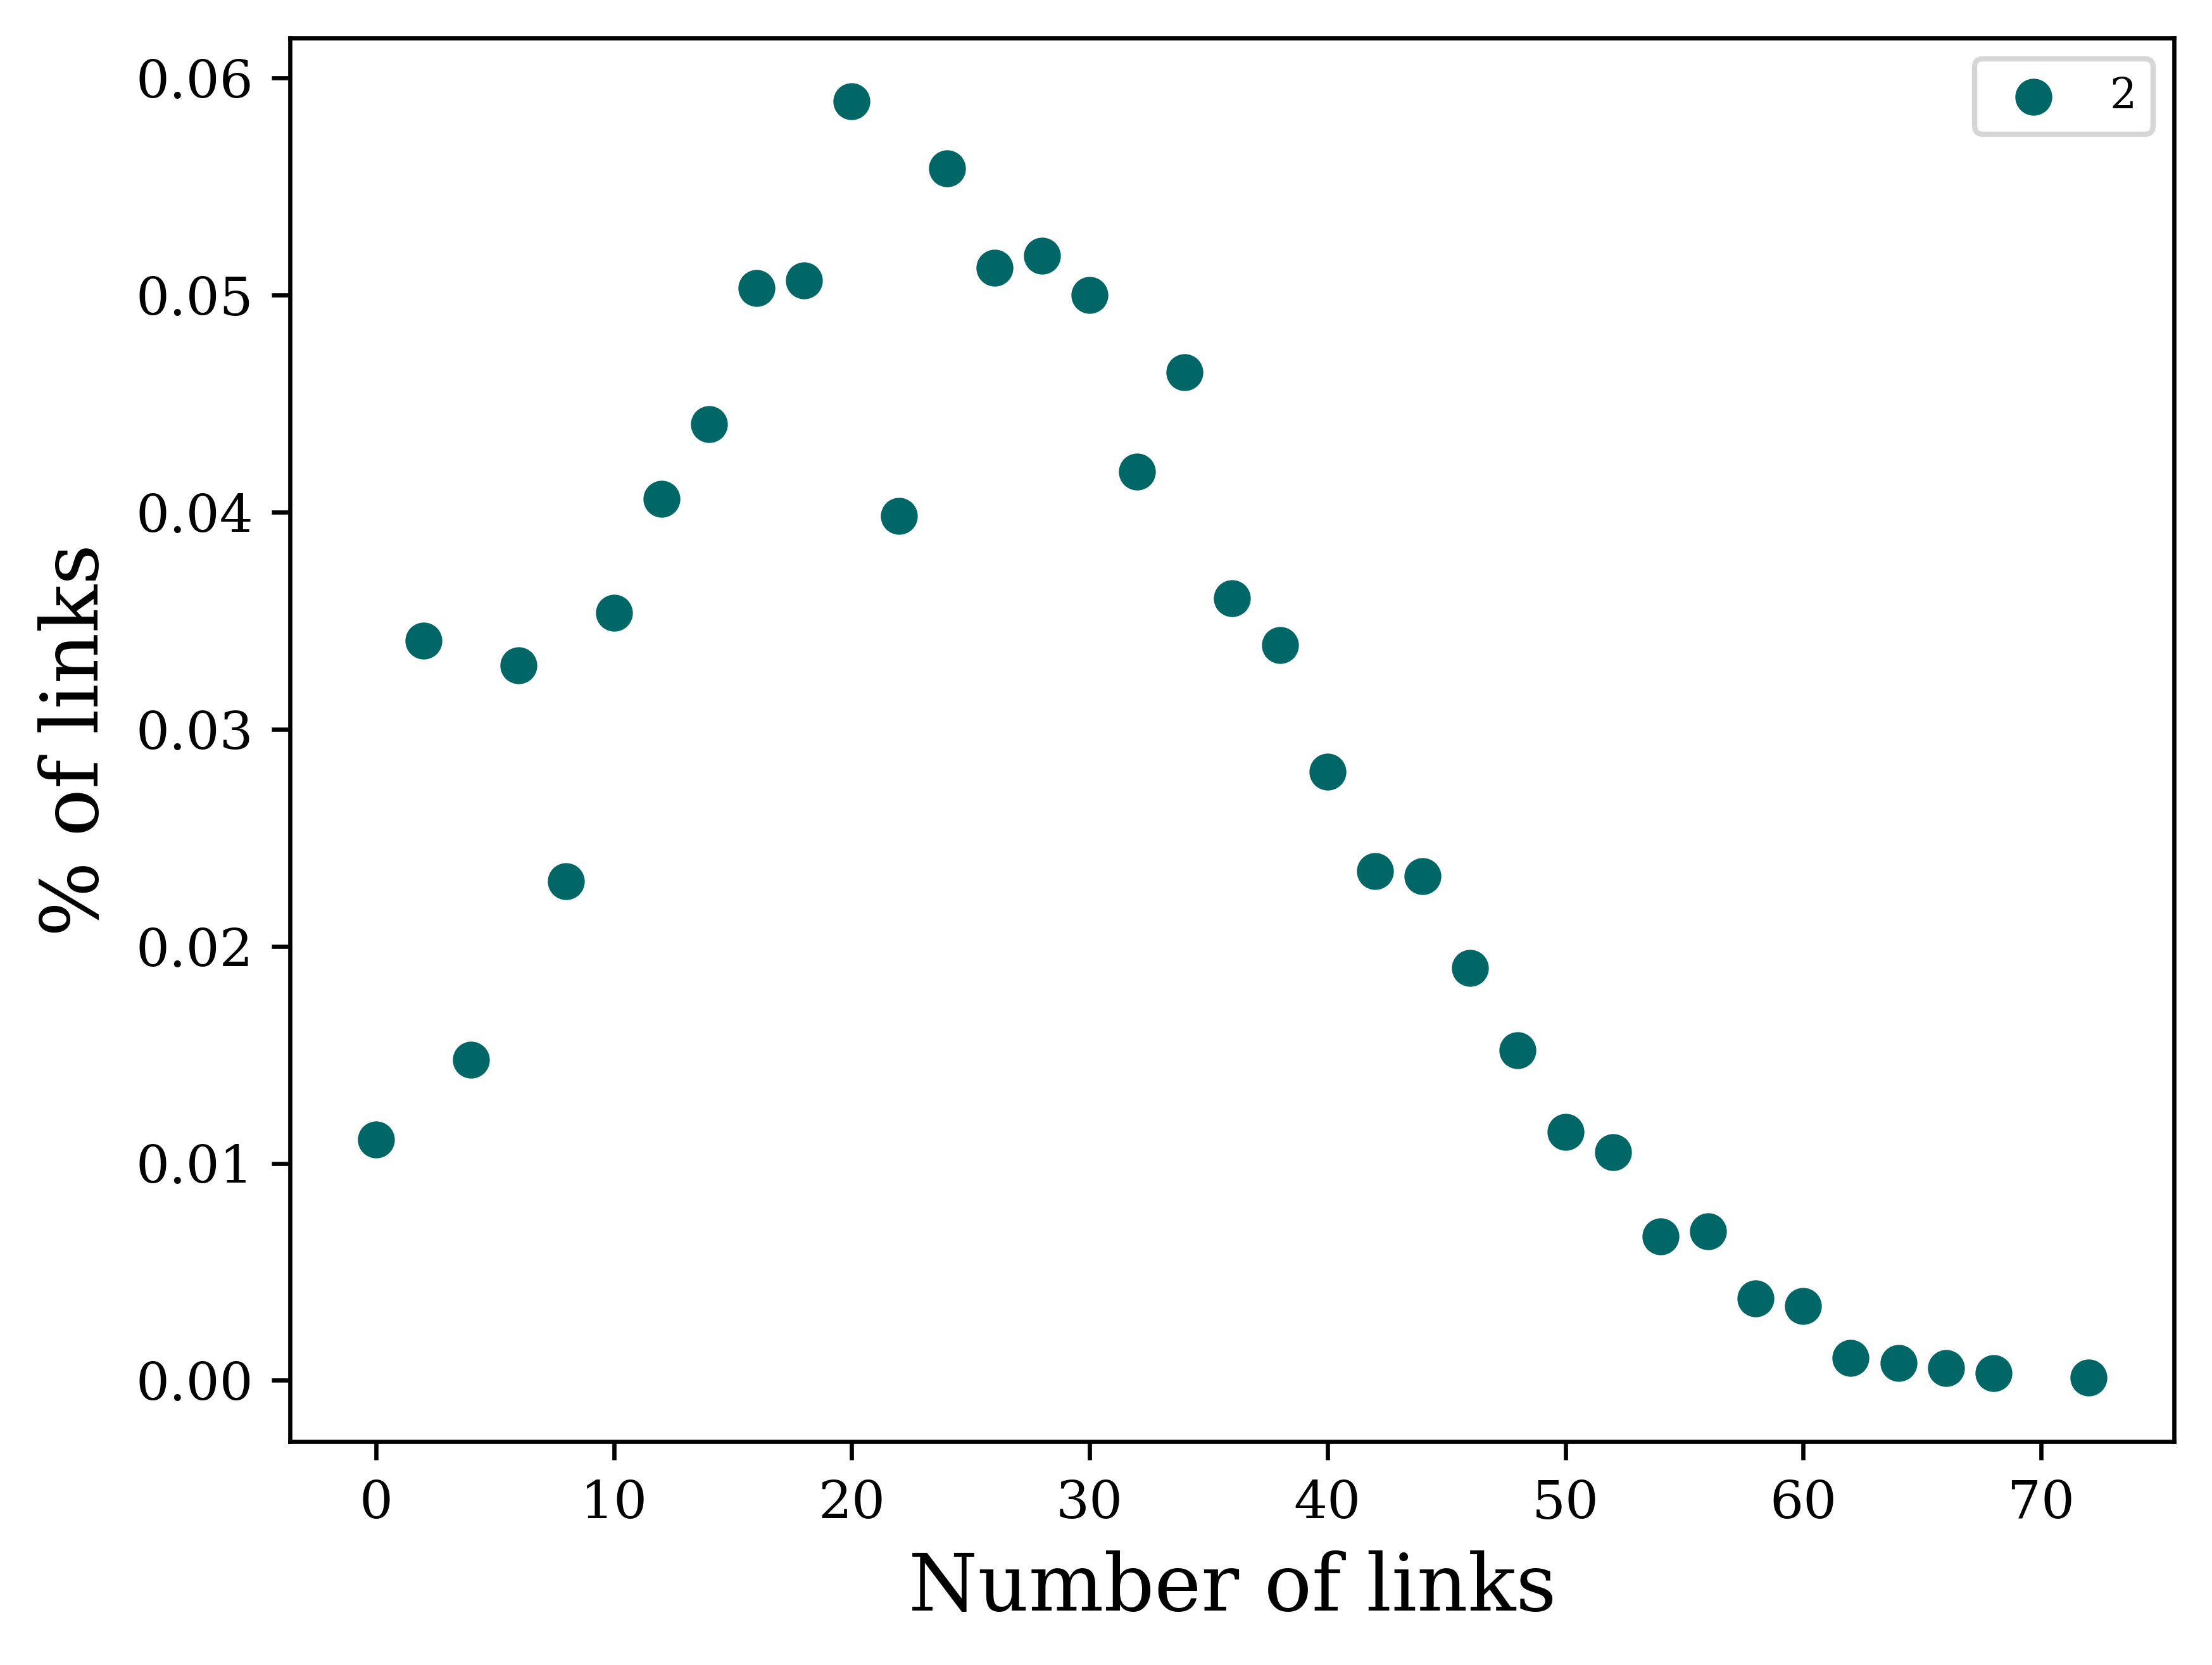

Média: 32.38461538461539
Mediana: 32.0
Moda: 0
Desvio Padrão: 19.546173145027254
Variância: 382.0528846153846
Amplitude: 70
Assimetria: 0.10019426890822485
Curtose: -1.0807913478058873


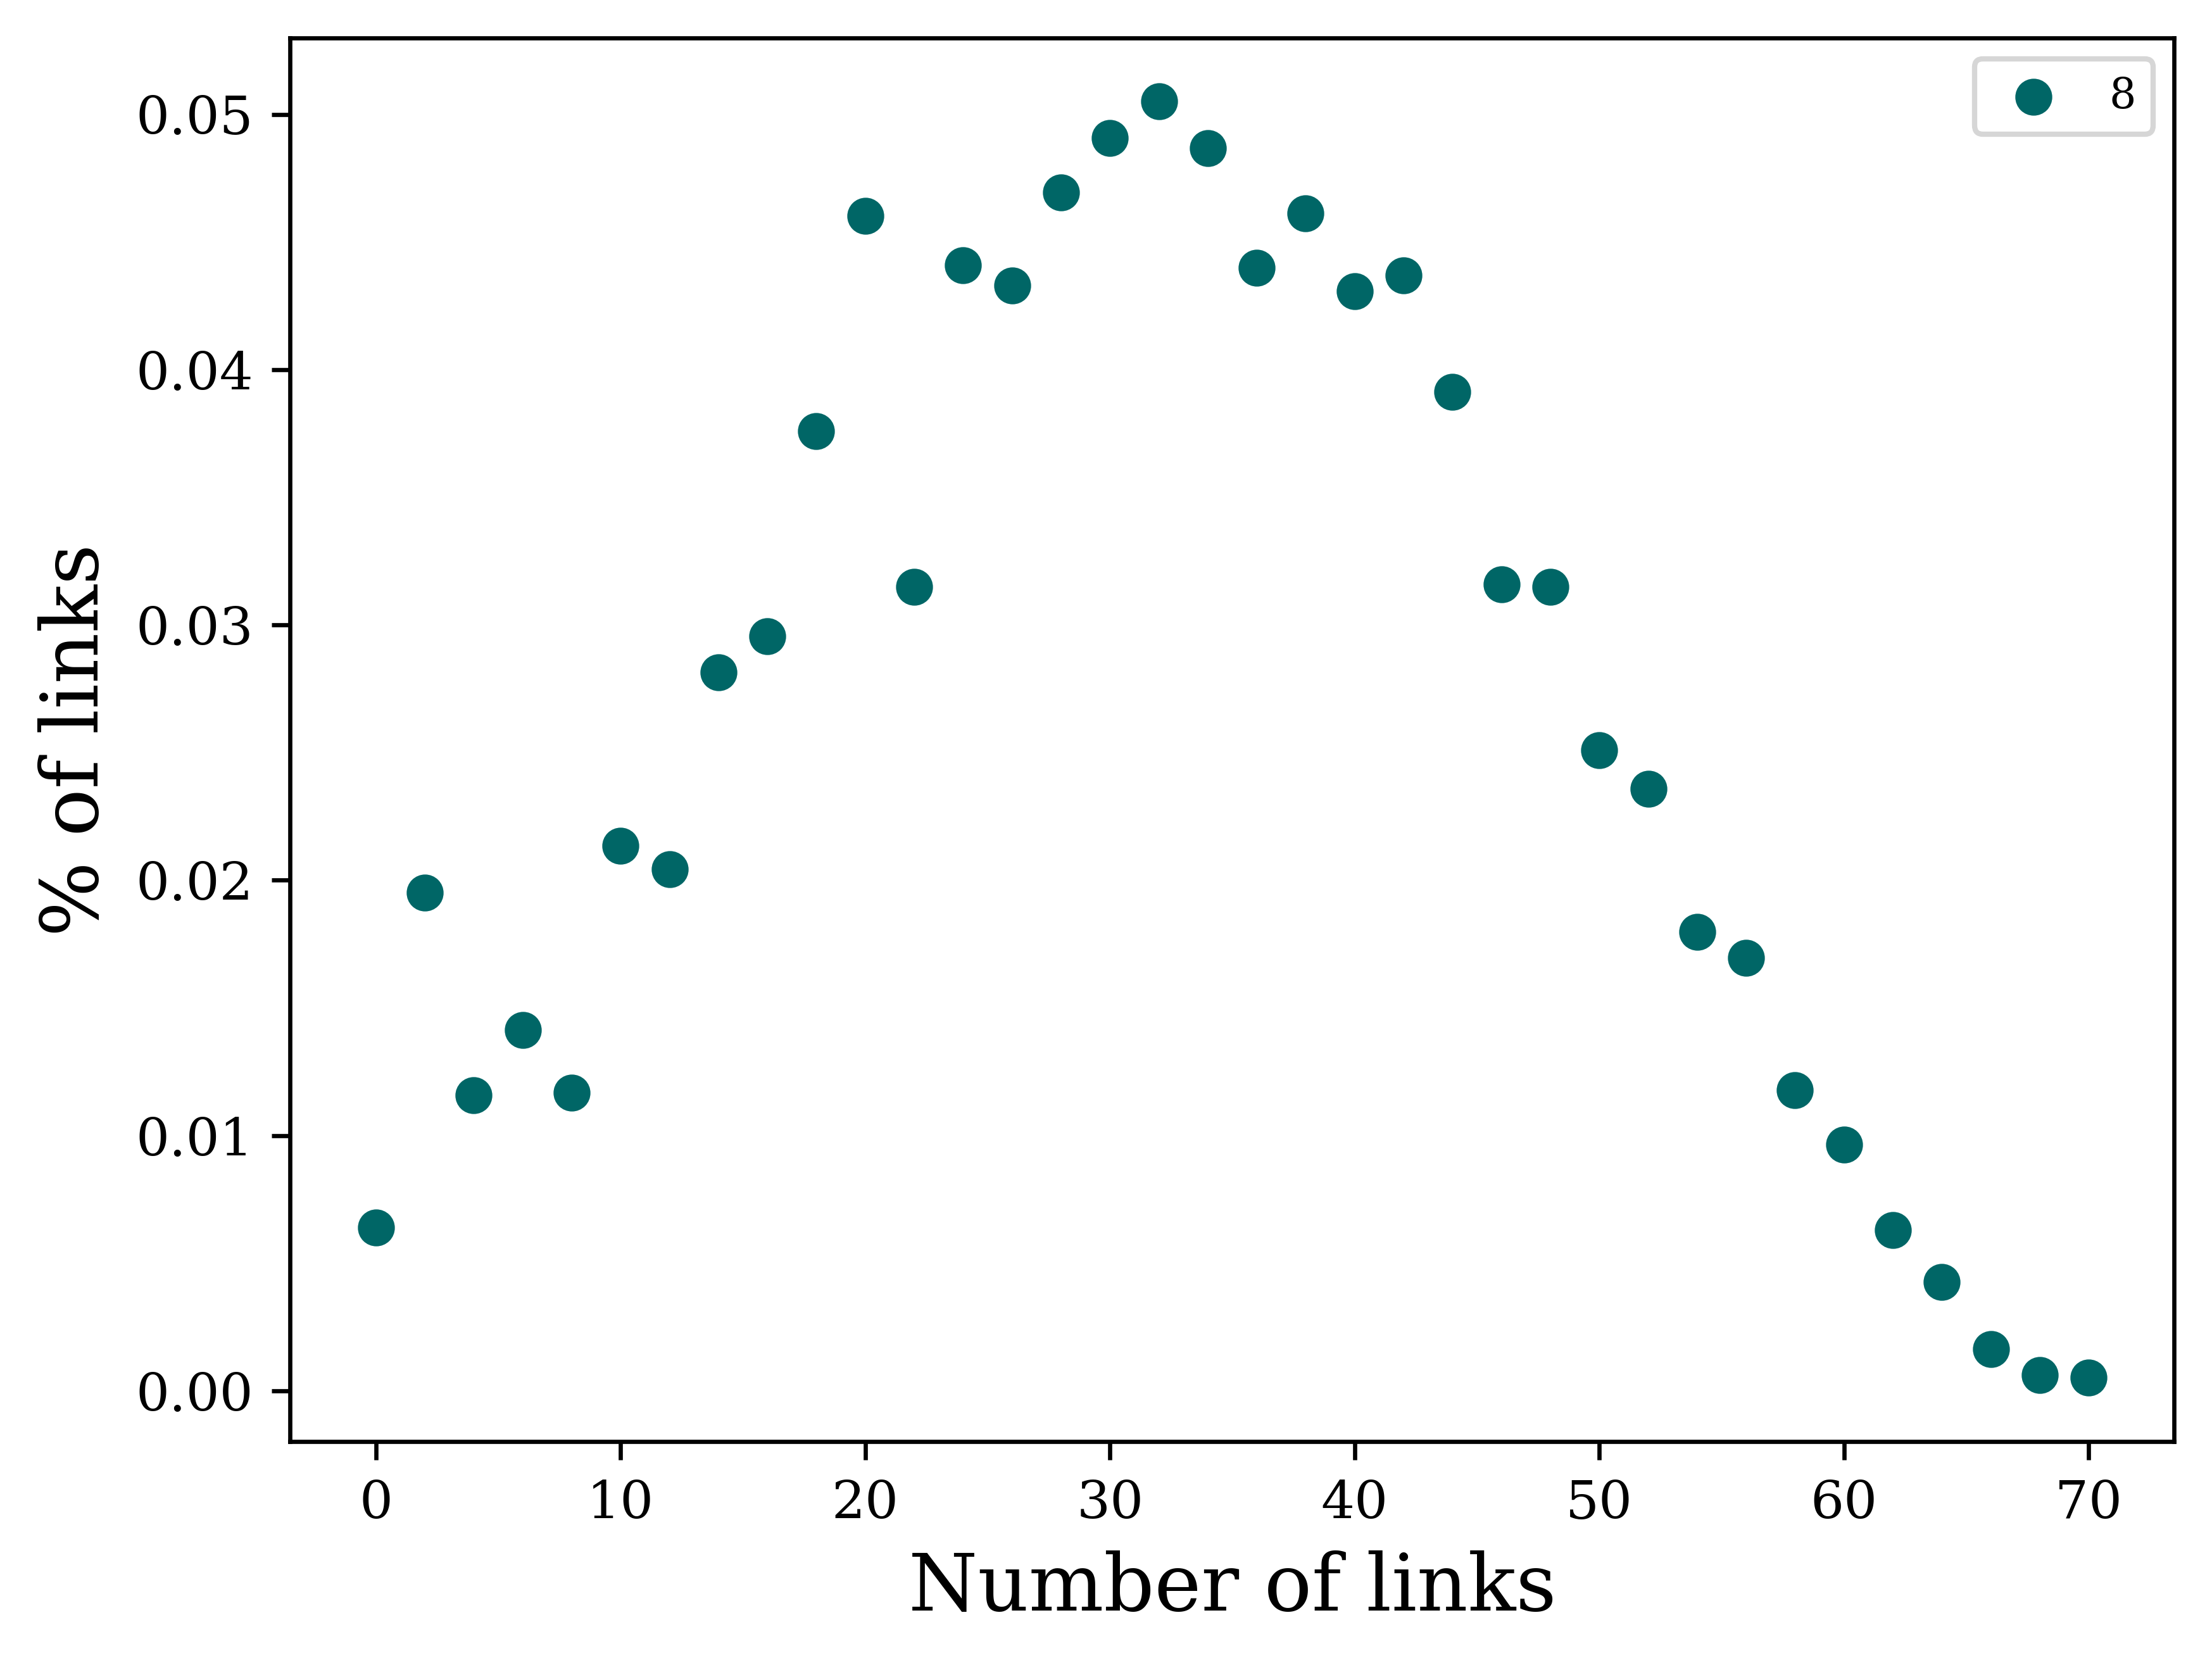

Média: 33.75
Mediana: 33.5
Moda: 0
Desvio Padrão: 20.195592100716123
Variância: 407.8619402985075
Amplitude: 72
Assimetria: 0.06683581976603462
Curtose: -1.1162242272828609


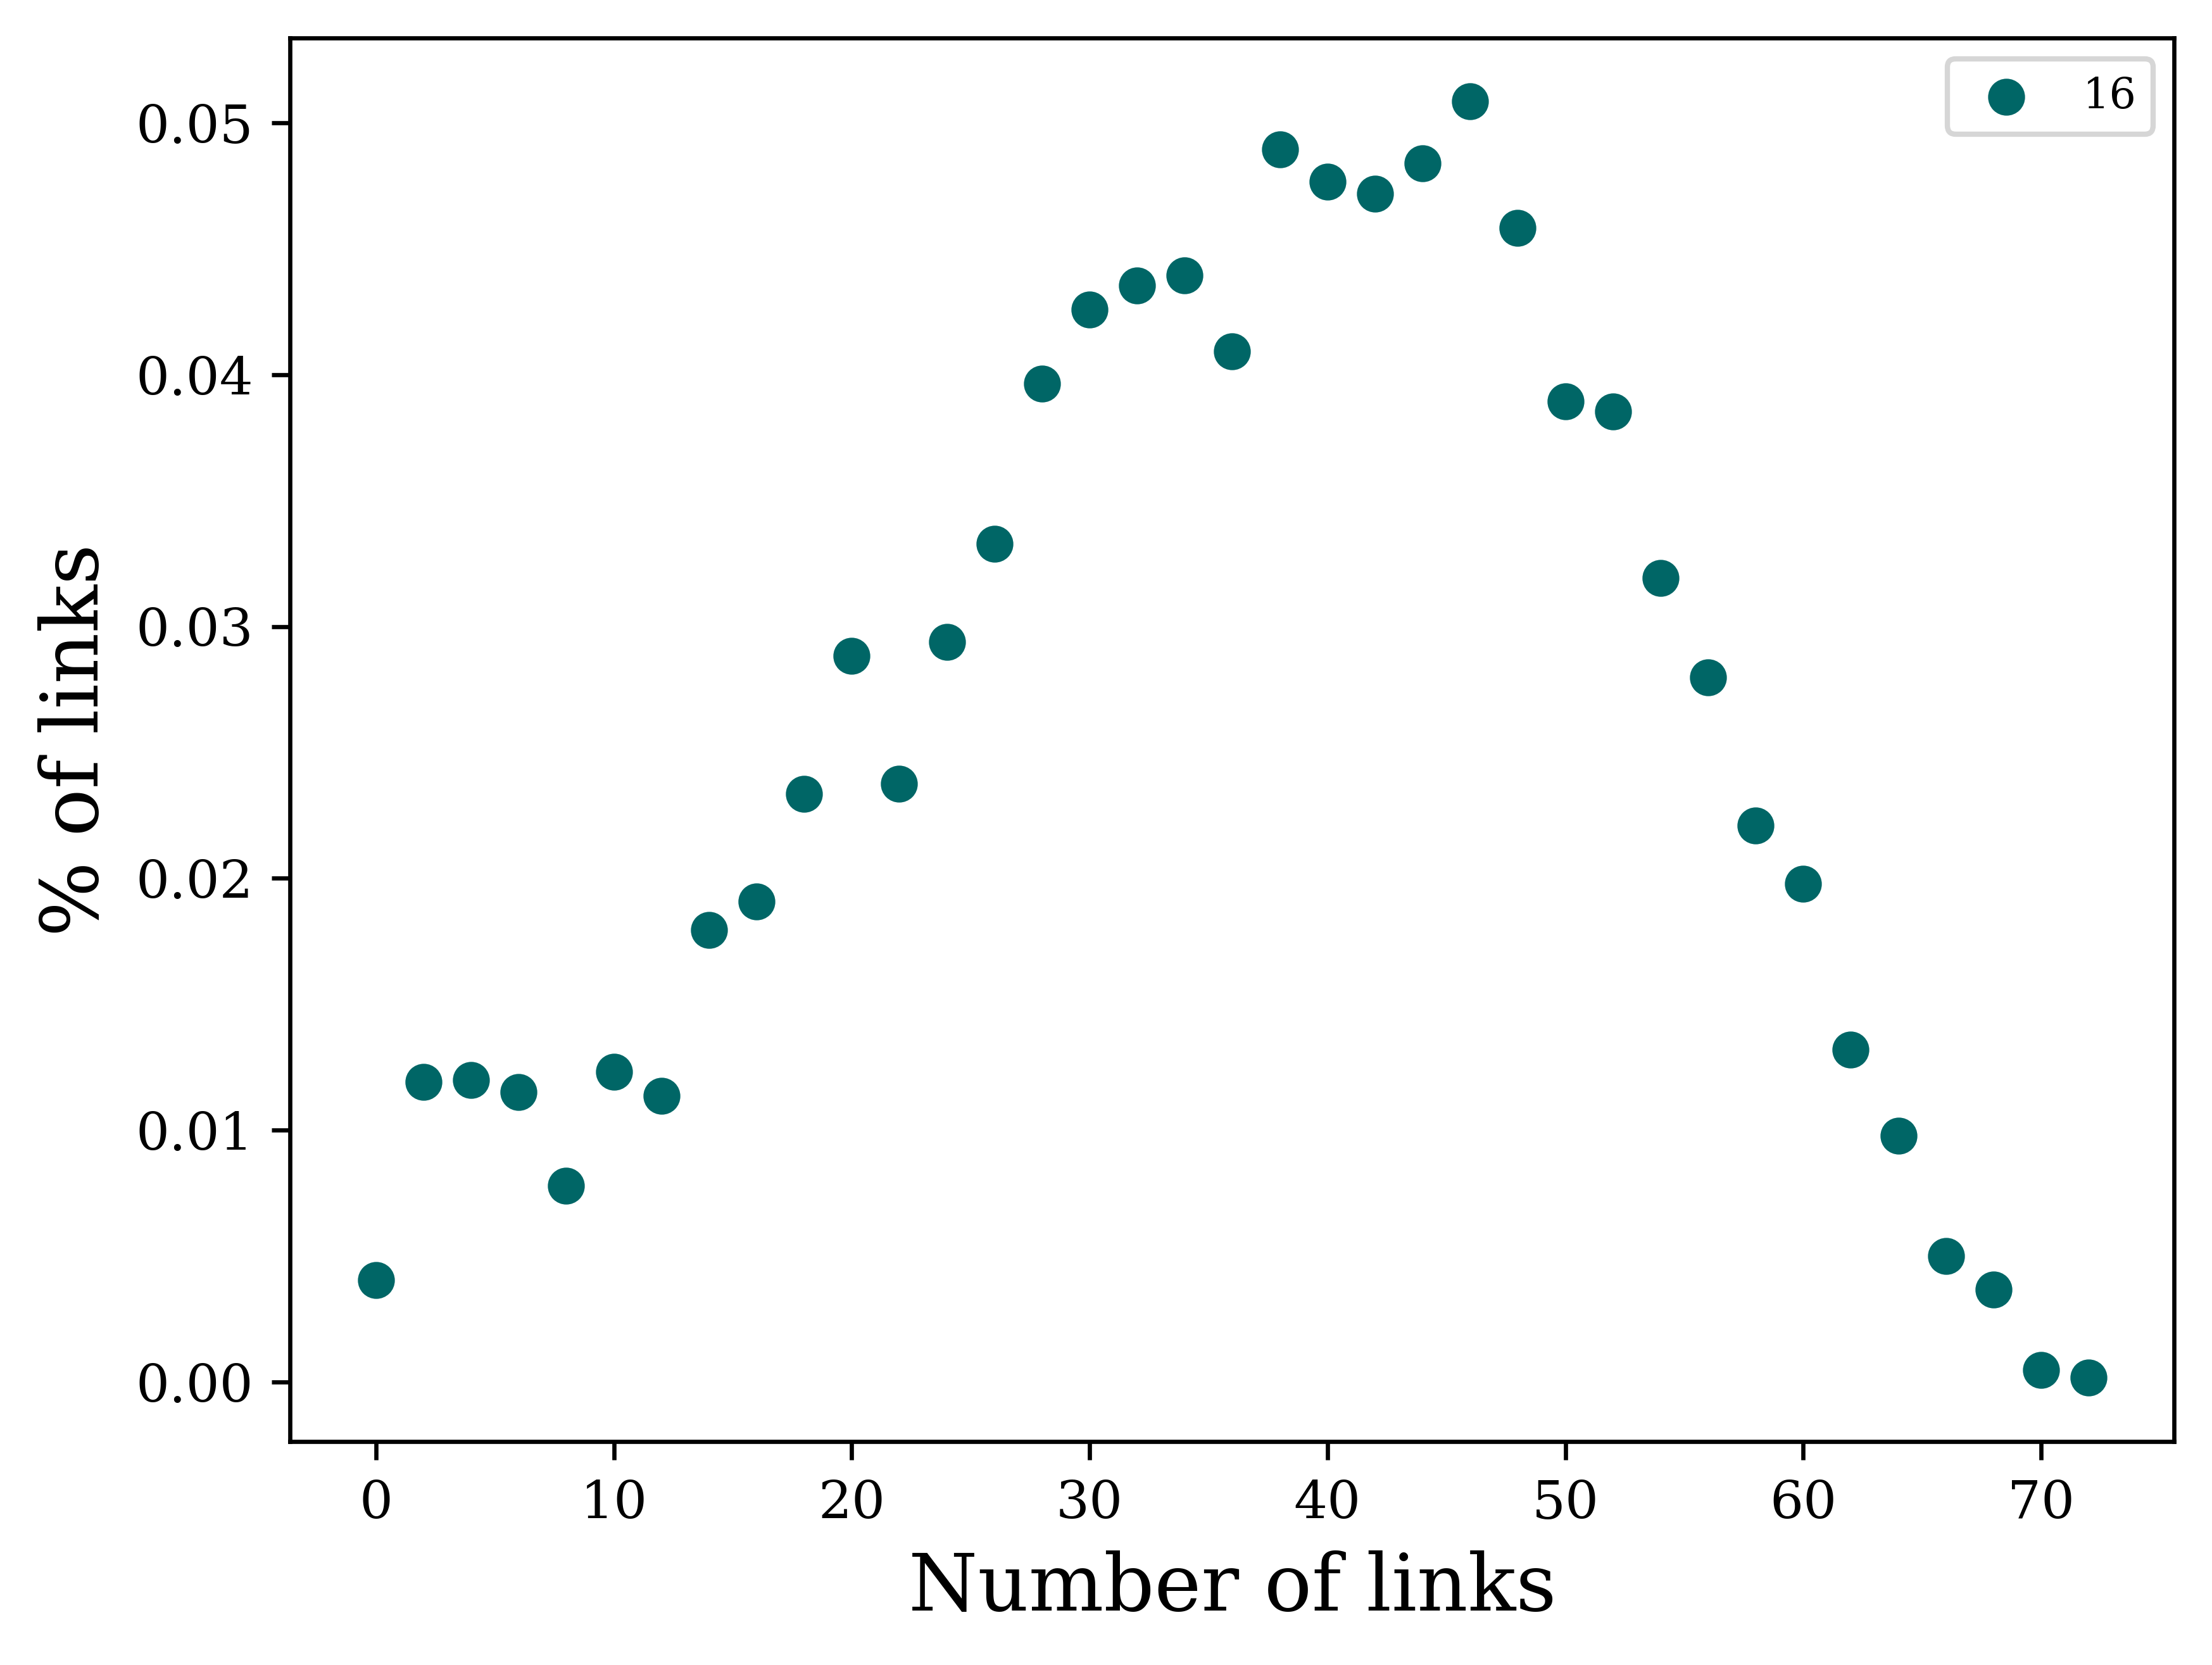

Média: 34.14492753623188
Mediana: 34.0
Moda: 0
Desvio Padrão: 20.31319142701496
Variância: 412.6257459505541
Amplitude: 72
Assimetria: 0.04171059892535956
Curtose: -1.144171213220745


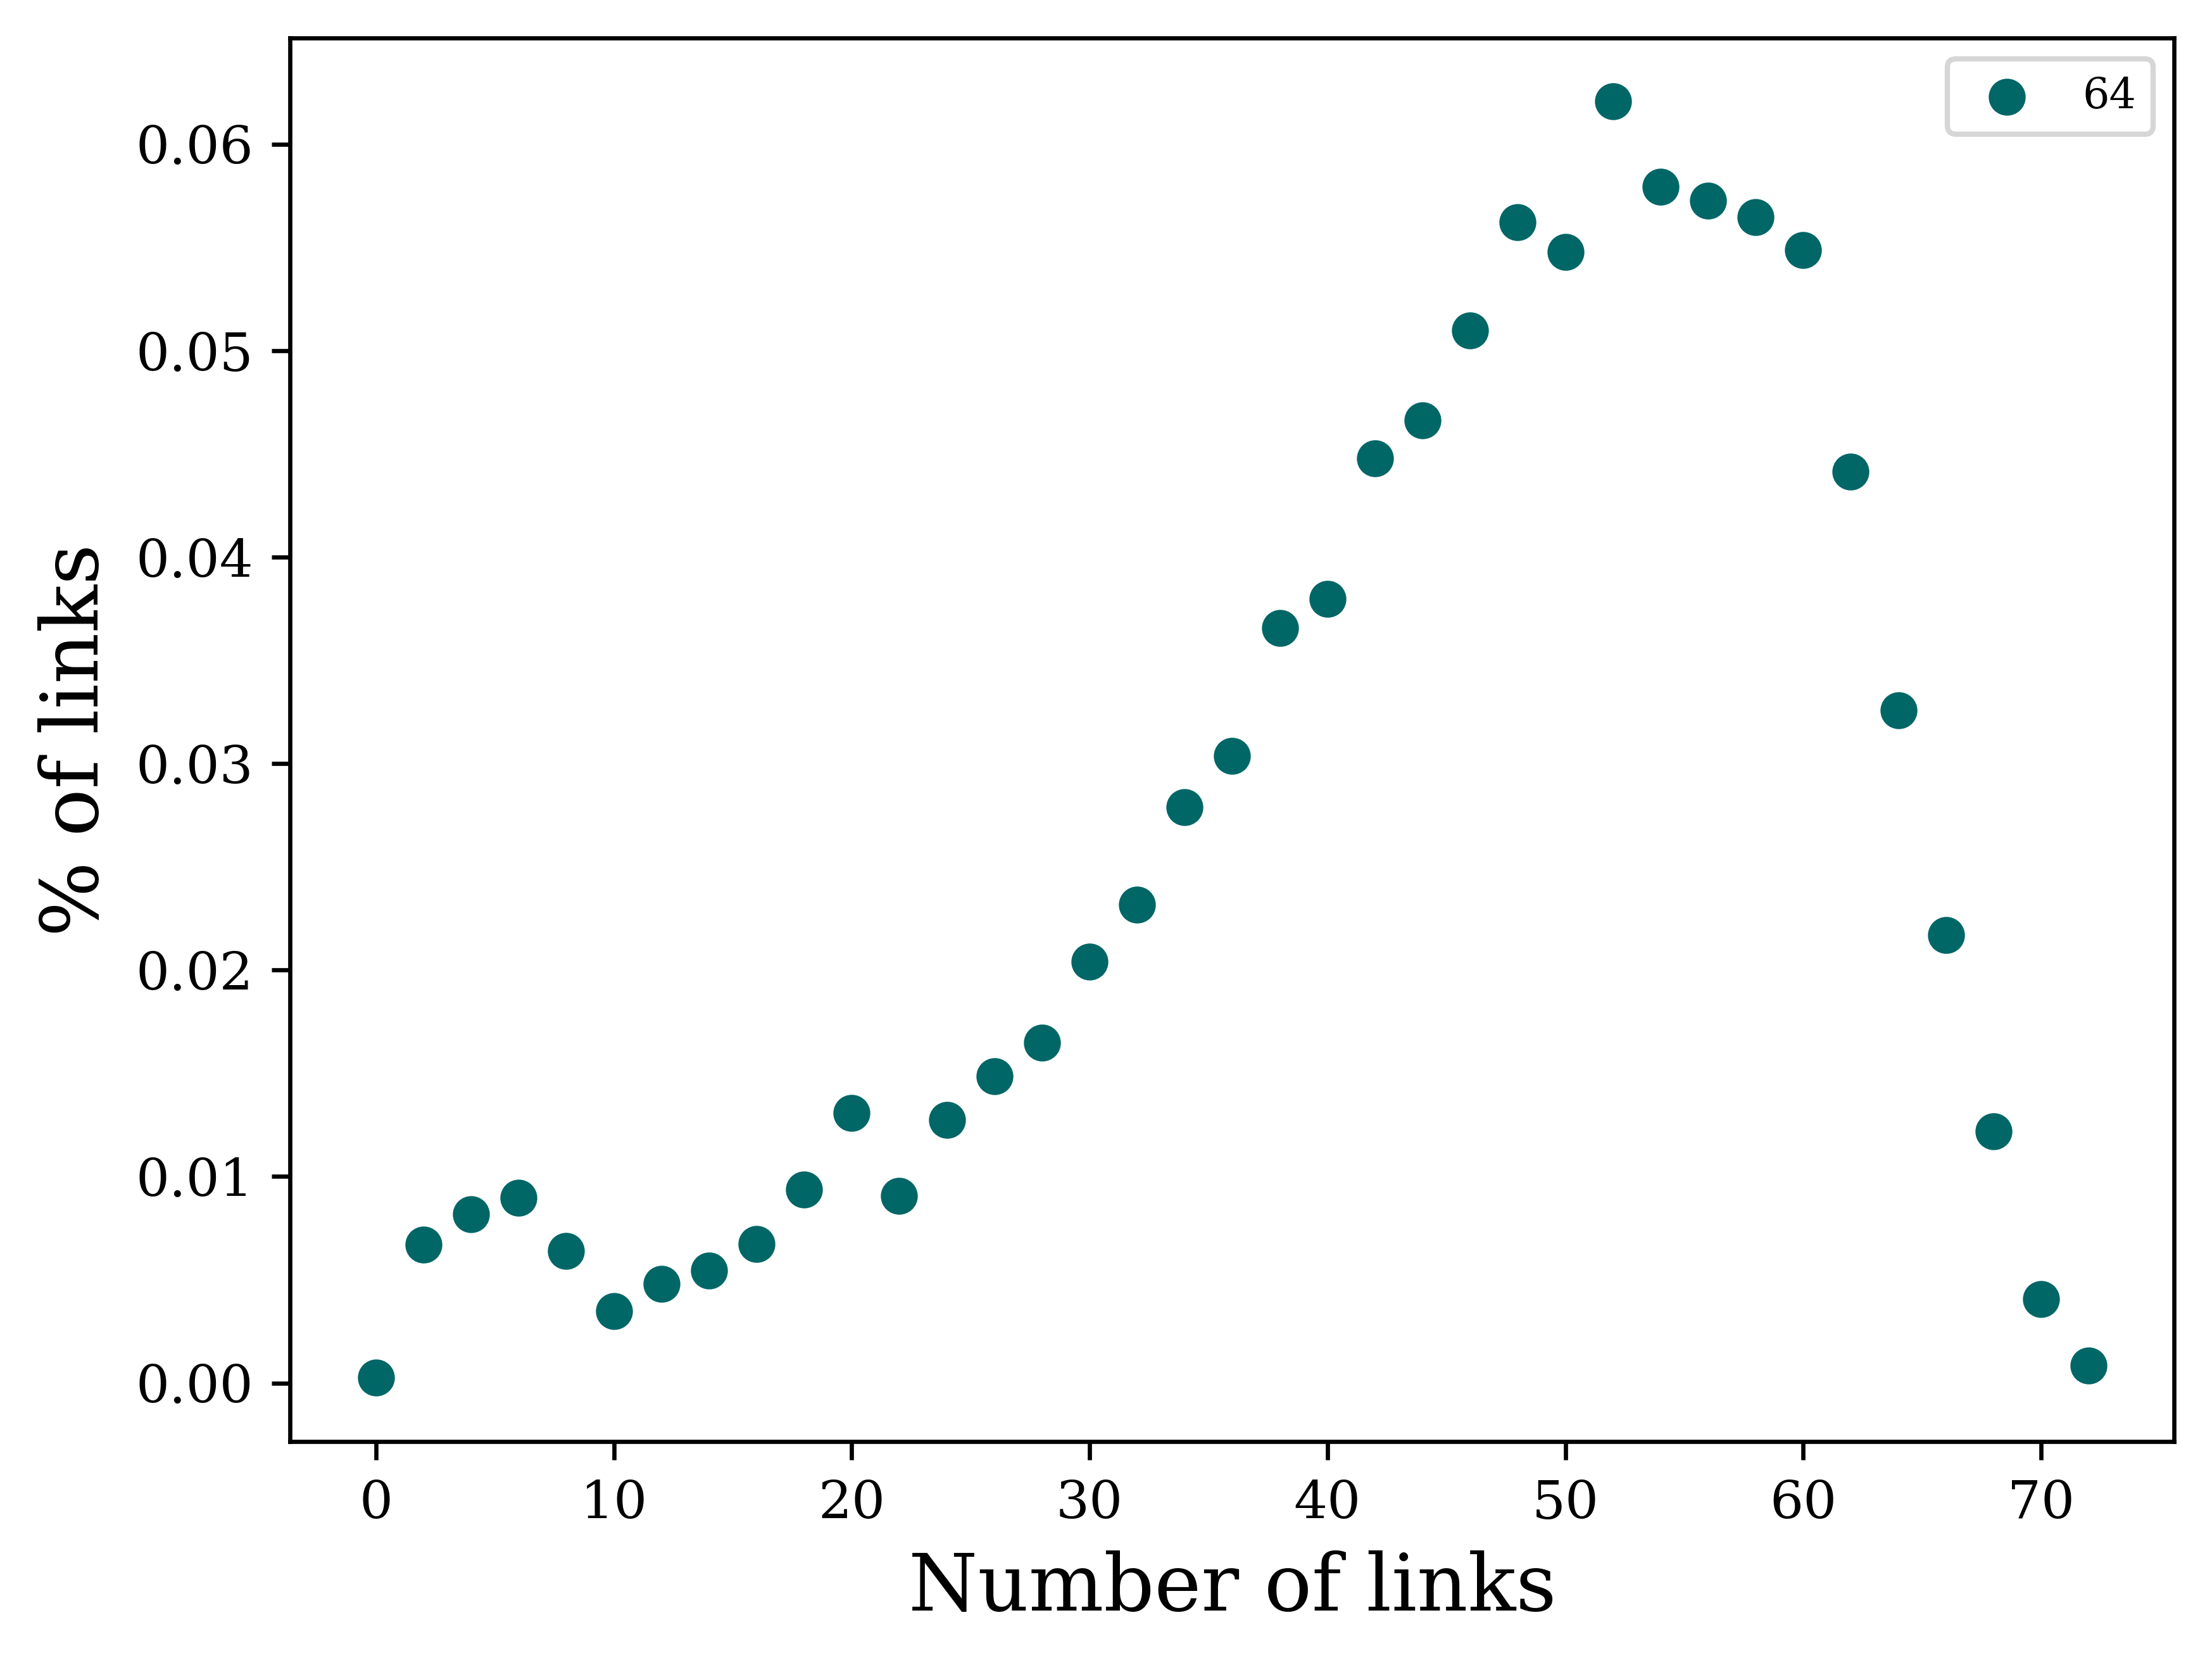

Média: 34.14492753623188
Mediana: 34.0
Moda: 0
Desvio Padrão: 20.31319142701496
Variância: 412.6257459505541
Amplitude: 72
Assimetria: 0.04171059892535956
Curtose: -1.144171213220745


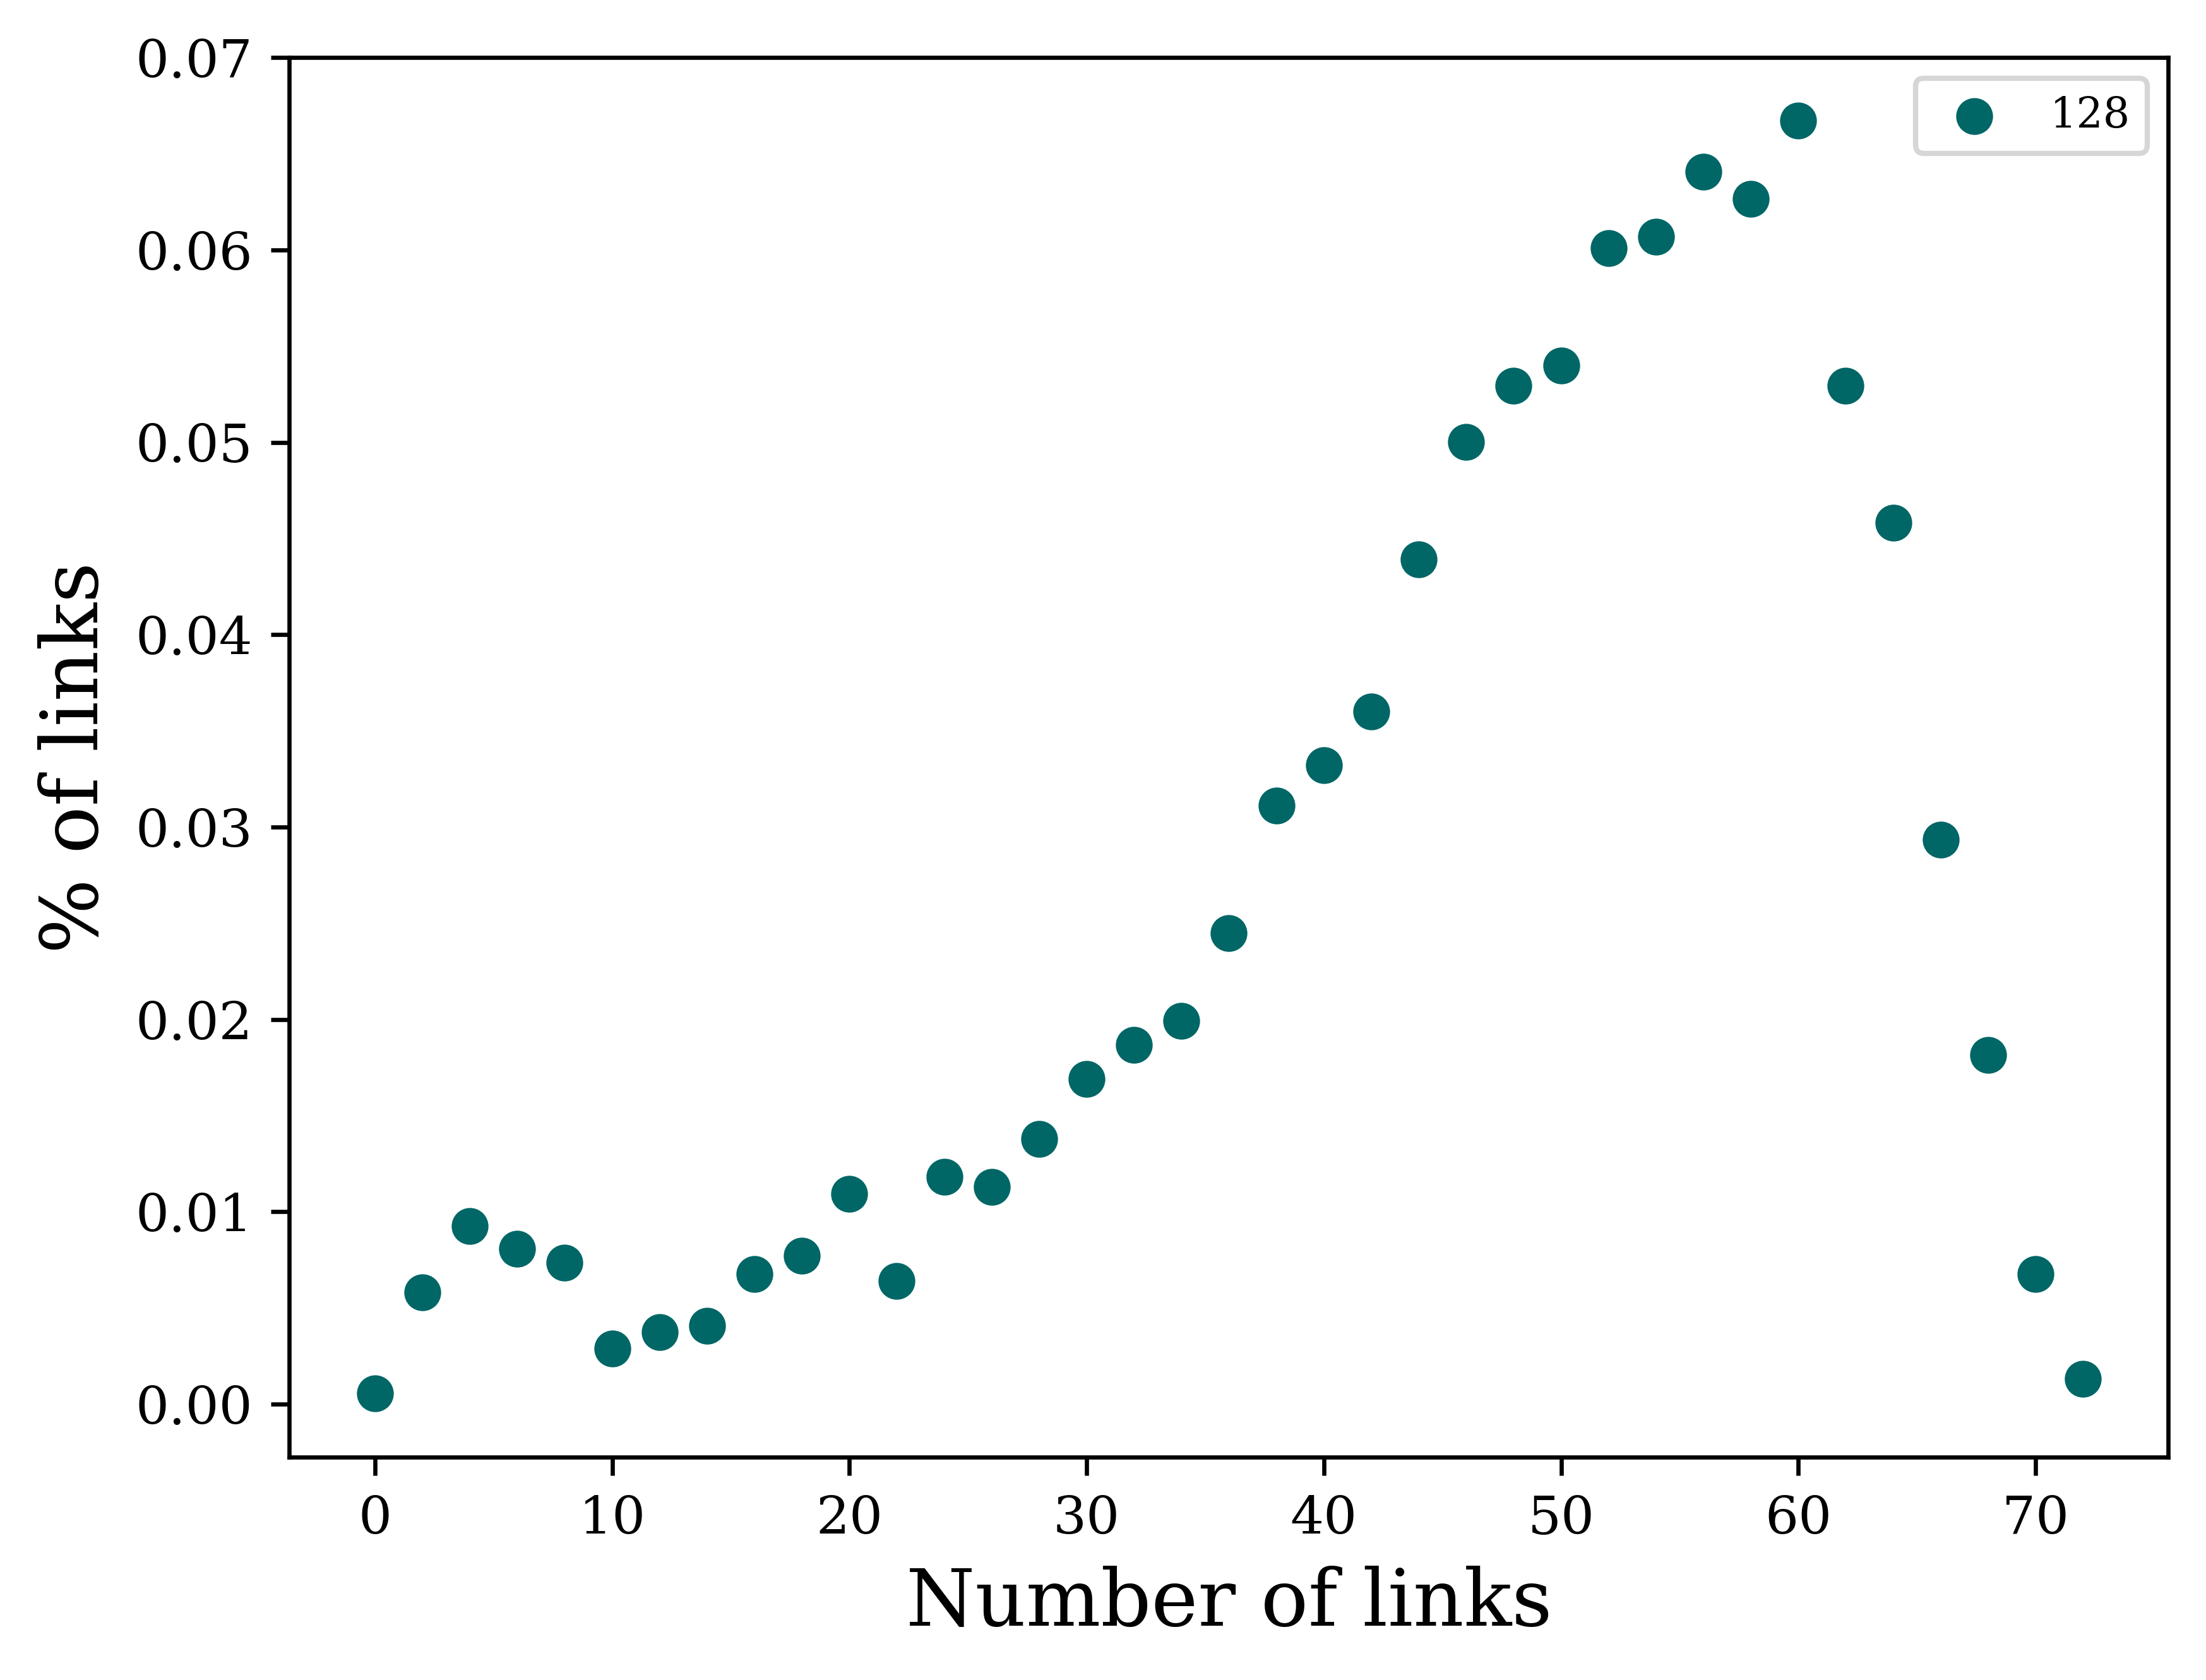

Média: 34.58571428571429
Mediana: 34.5
Moda: 0
Desvio Padrão: 20.499906579598274
Variância: 420.2461697722567
Amplitude: 72
Assimetria: 0.02478096594633905
Curtose: -1.1666695013661448


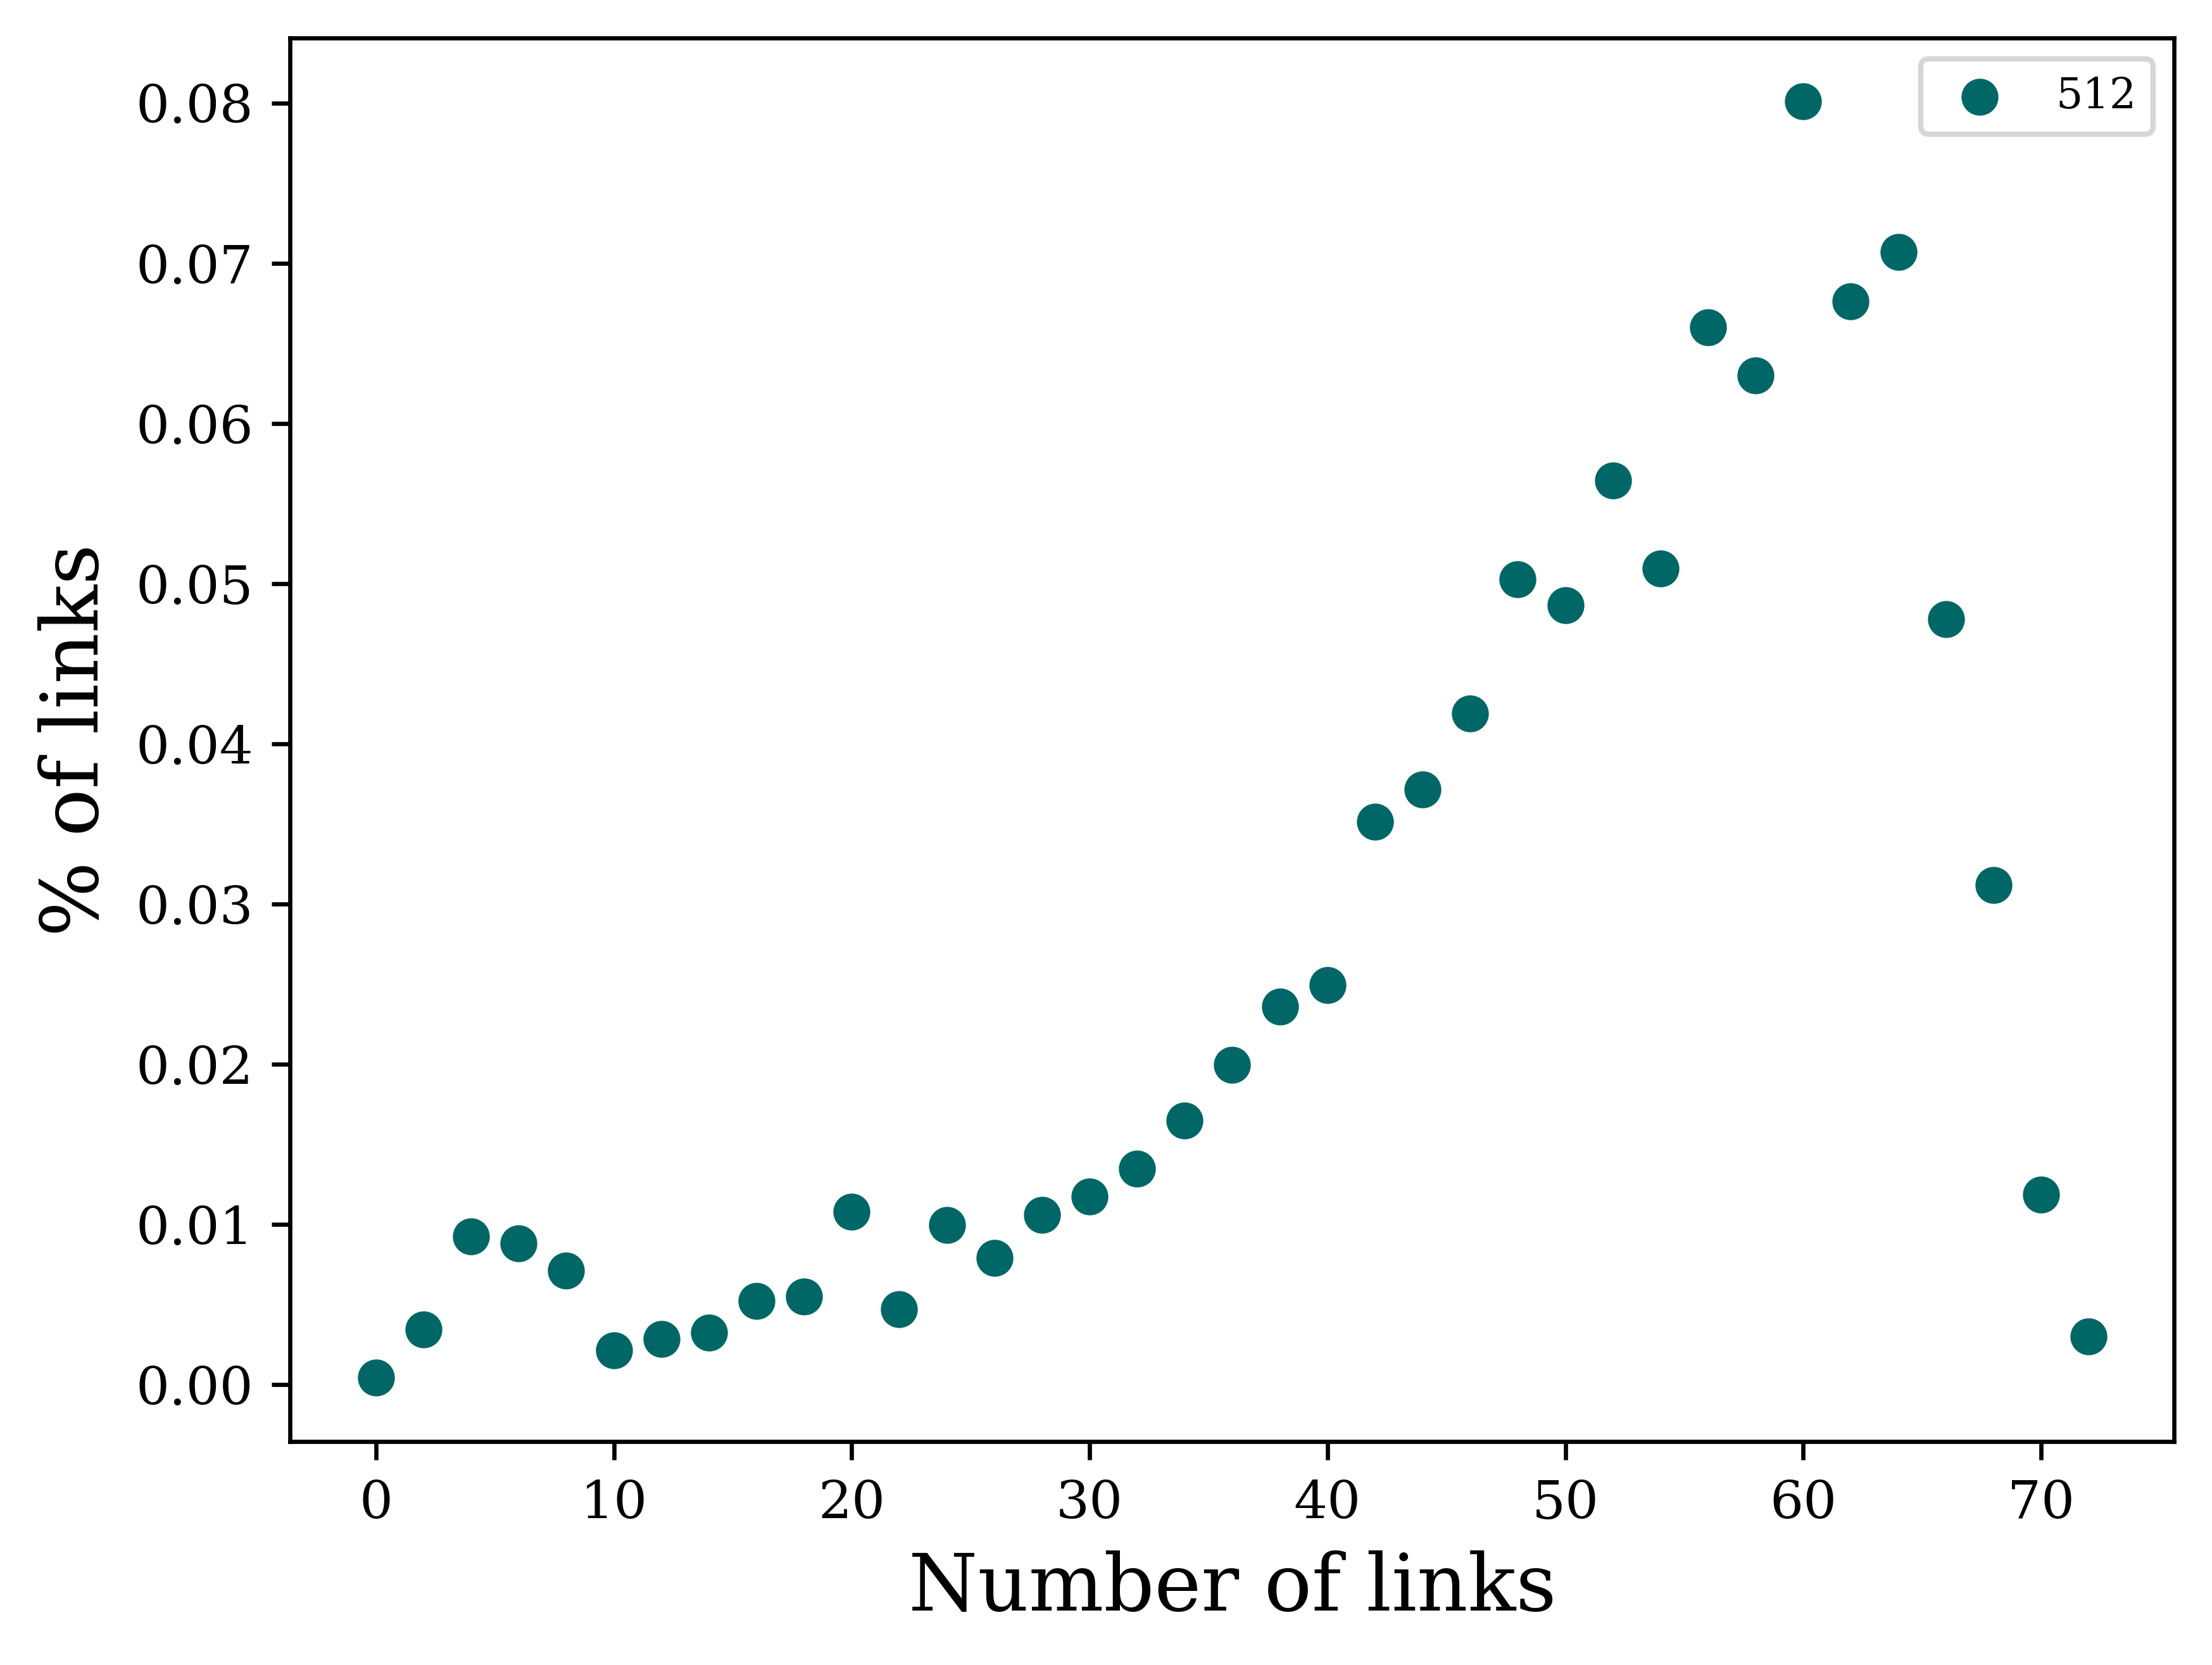

Média: 34.58571428571429
Mediana: 34.5
Moda: 0
Desvio Padrão: 20.499906579598274
Variância: 420.2461697722567
Amplitude: 72
Assimetria: 0.02478096594633905
Curtose: -1.1666695013661448


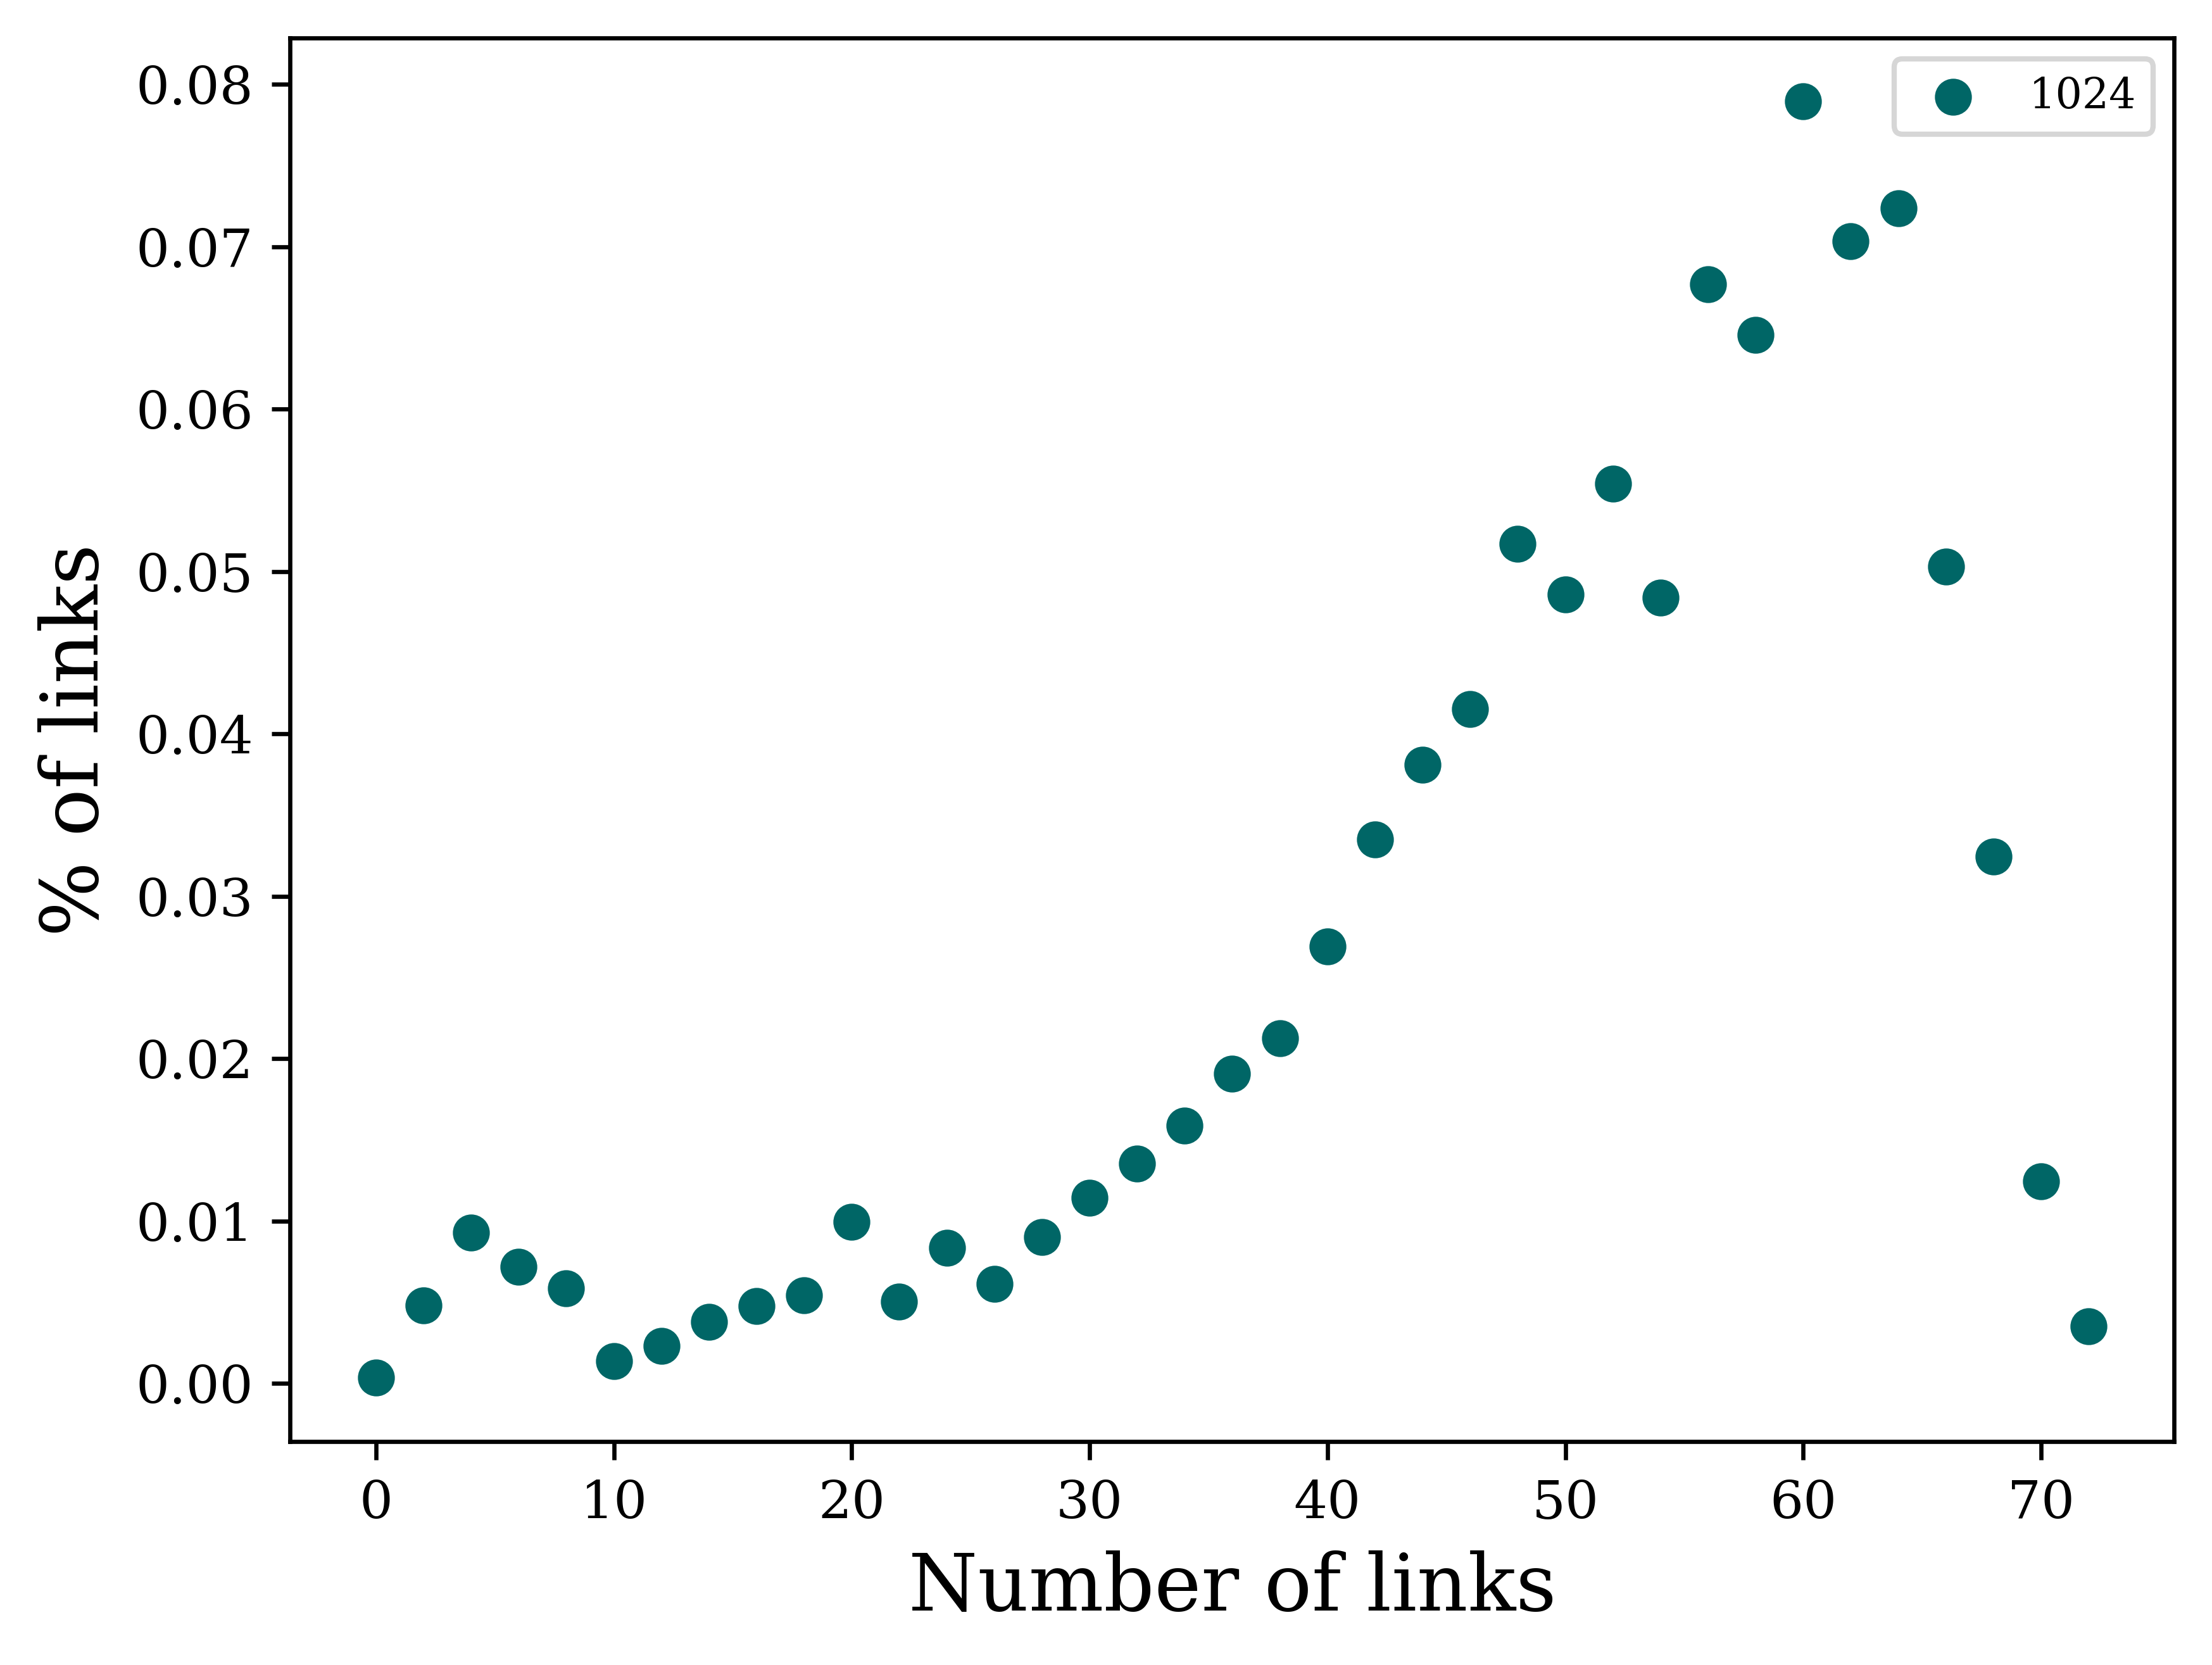

Média: 34.58571428571429
Mediana: 34.5
Moda: 0
Desvio Padrão: 20.499906579598274
Variância: 420.2461697722567
Amplitude: 72
Assimetria: 0.02478096594633905
Curtose: -1.1666695013661448


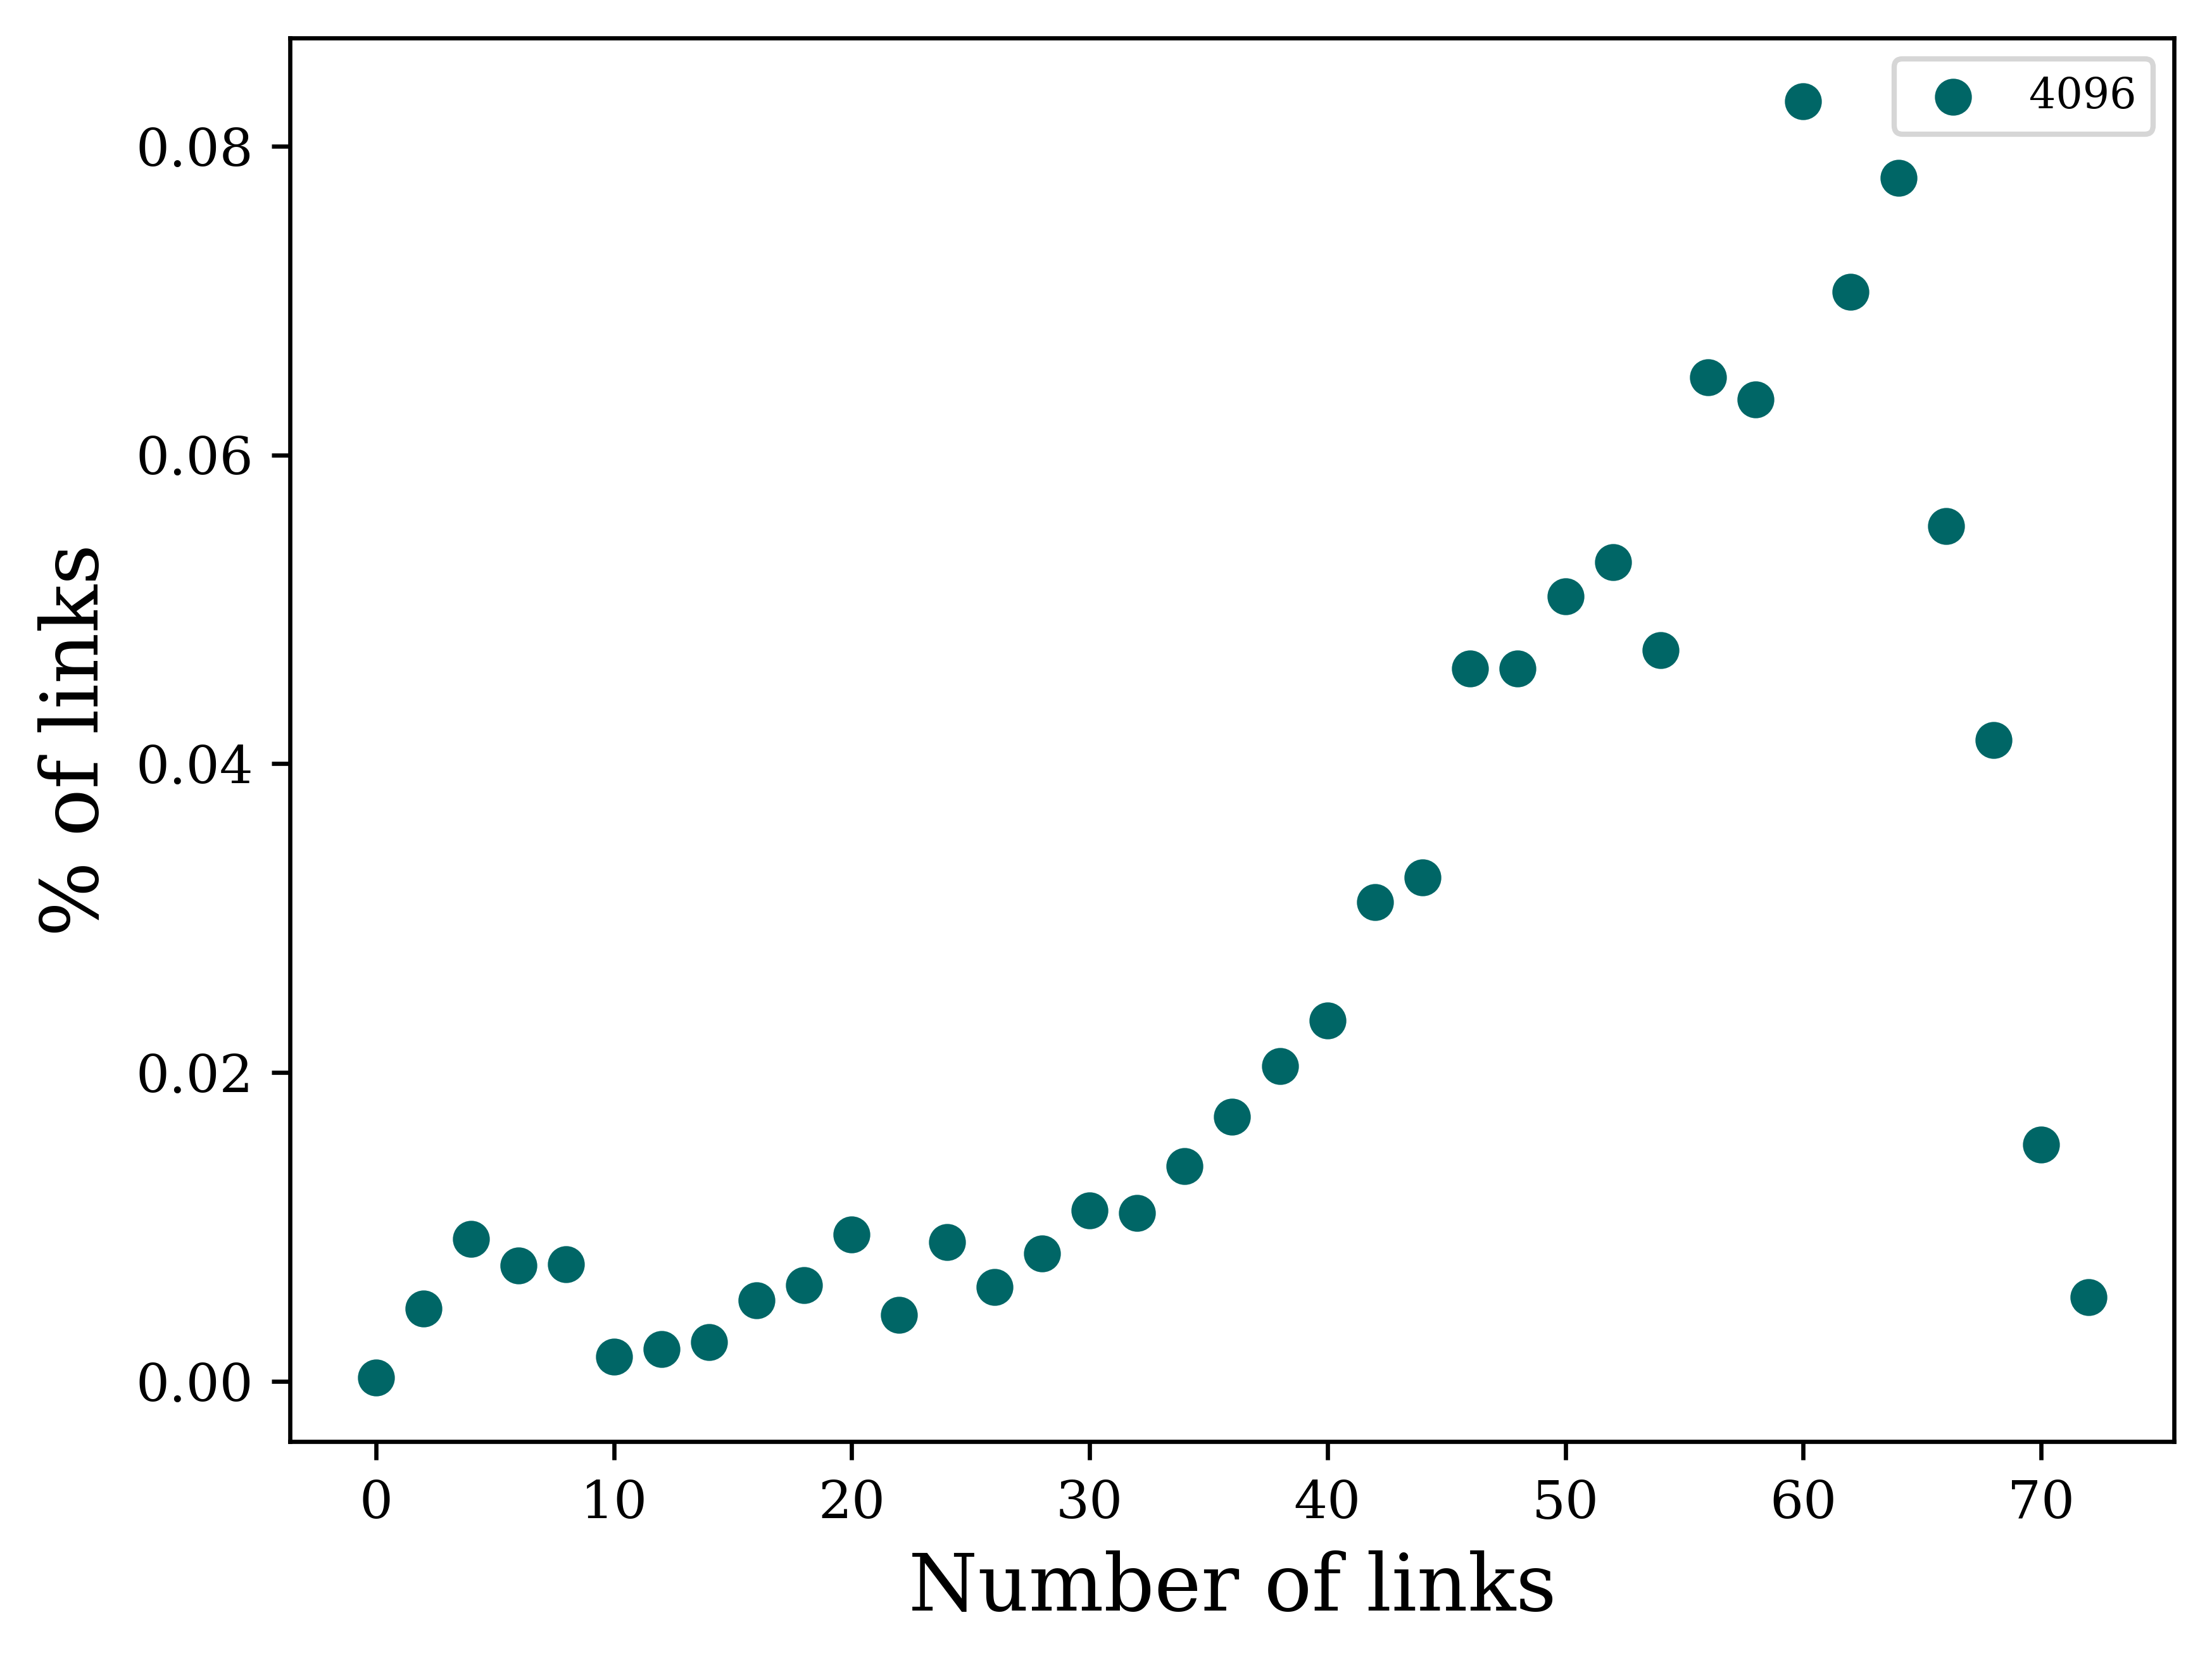

Média: 34.58571428571429
Mediana: 34.5
Moda: 0
Desvio Padrão: 20.499906579598274
Variância: 420.2461697722567
Amplitude: 72
Assimetria: 0.02478096594633905
Curtose: -1.1666695013661448


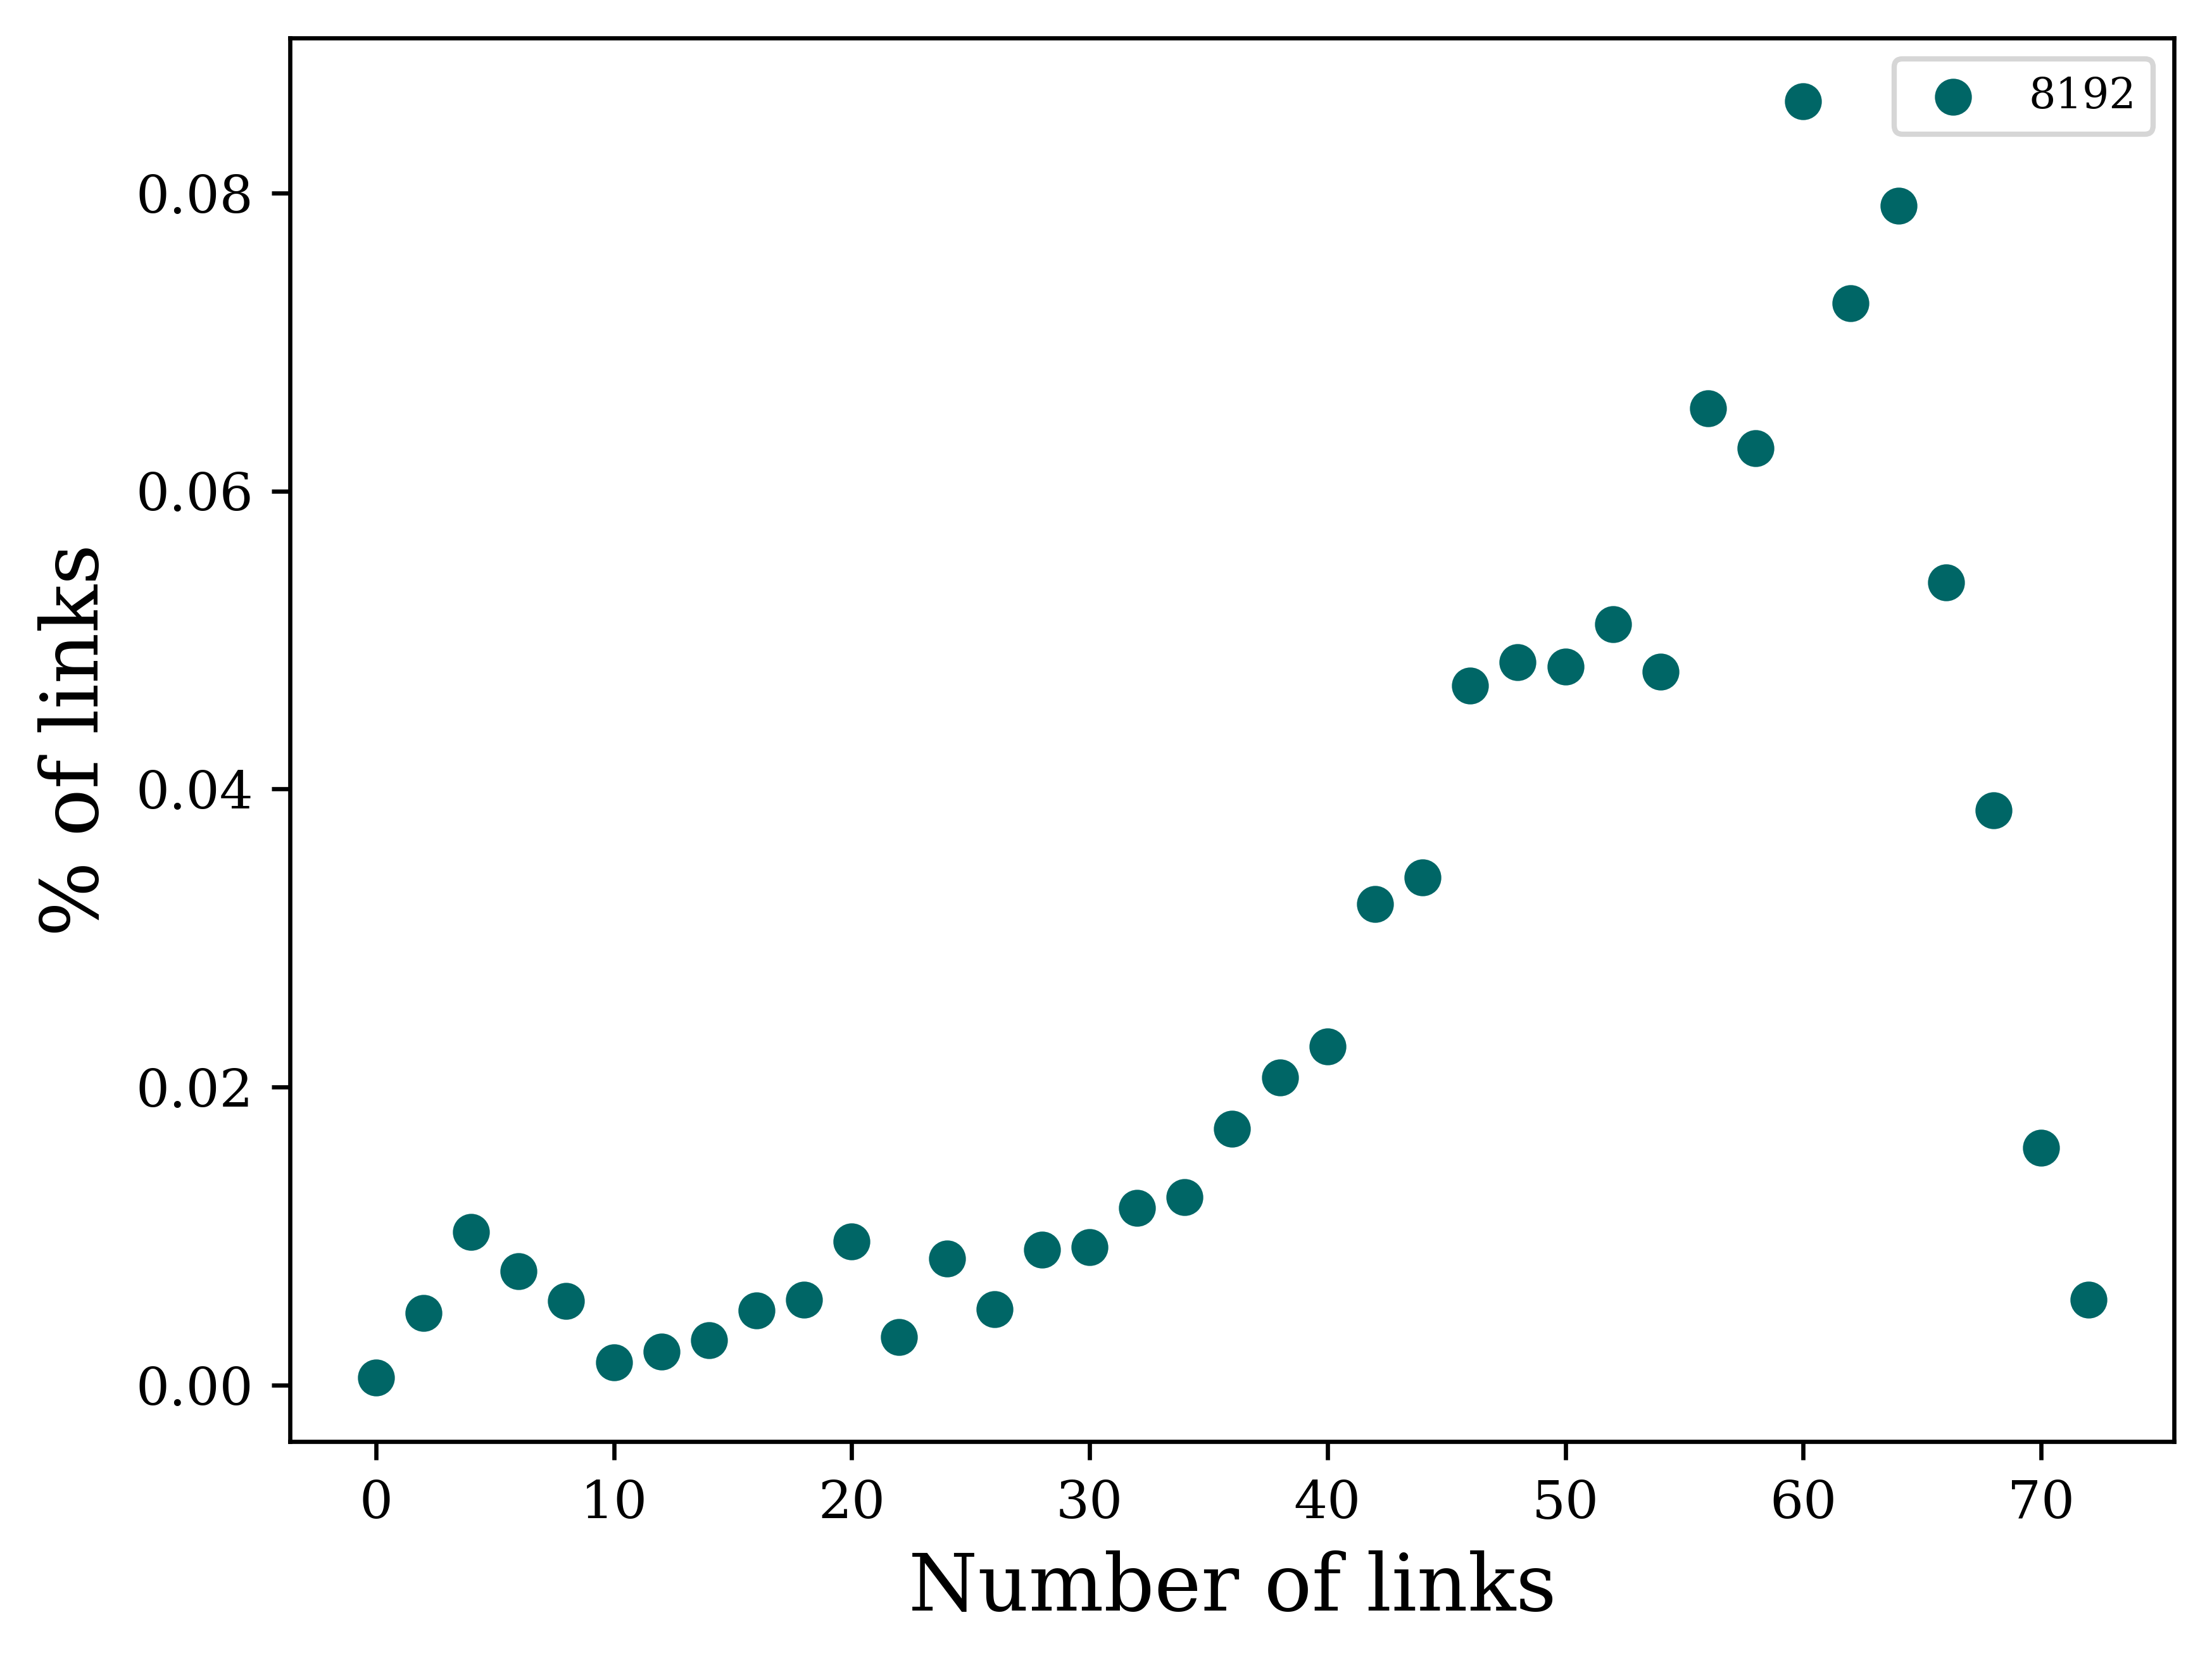

Média: 33.38709677419355
Mediana: 32.5
Moda: 1
Desvio Padrão: 19.580313665423823
Variância: 383.38868323638286
Amplitude: 71
Assimetria: 0.16666617560141847
Curtose: -1.011712906141984


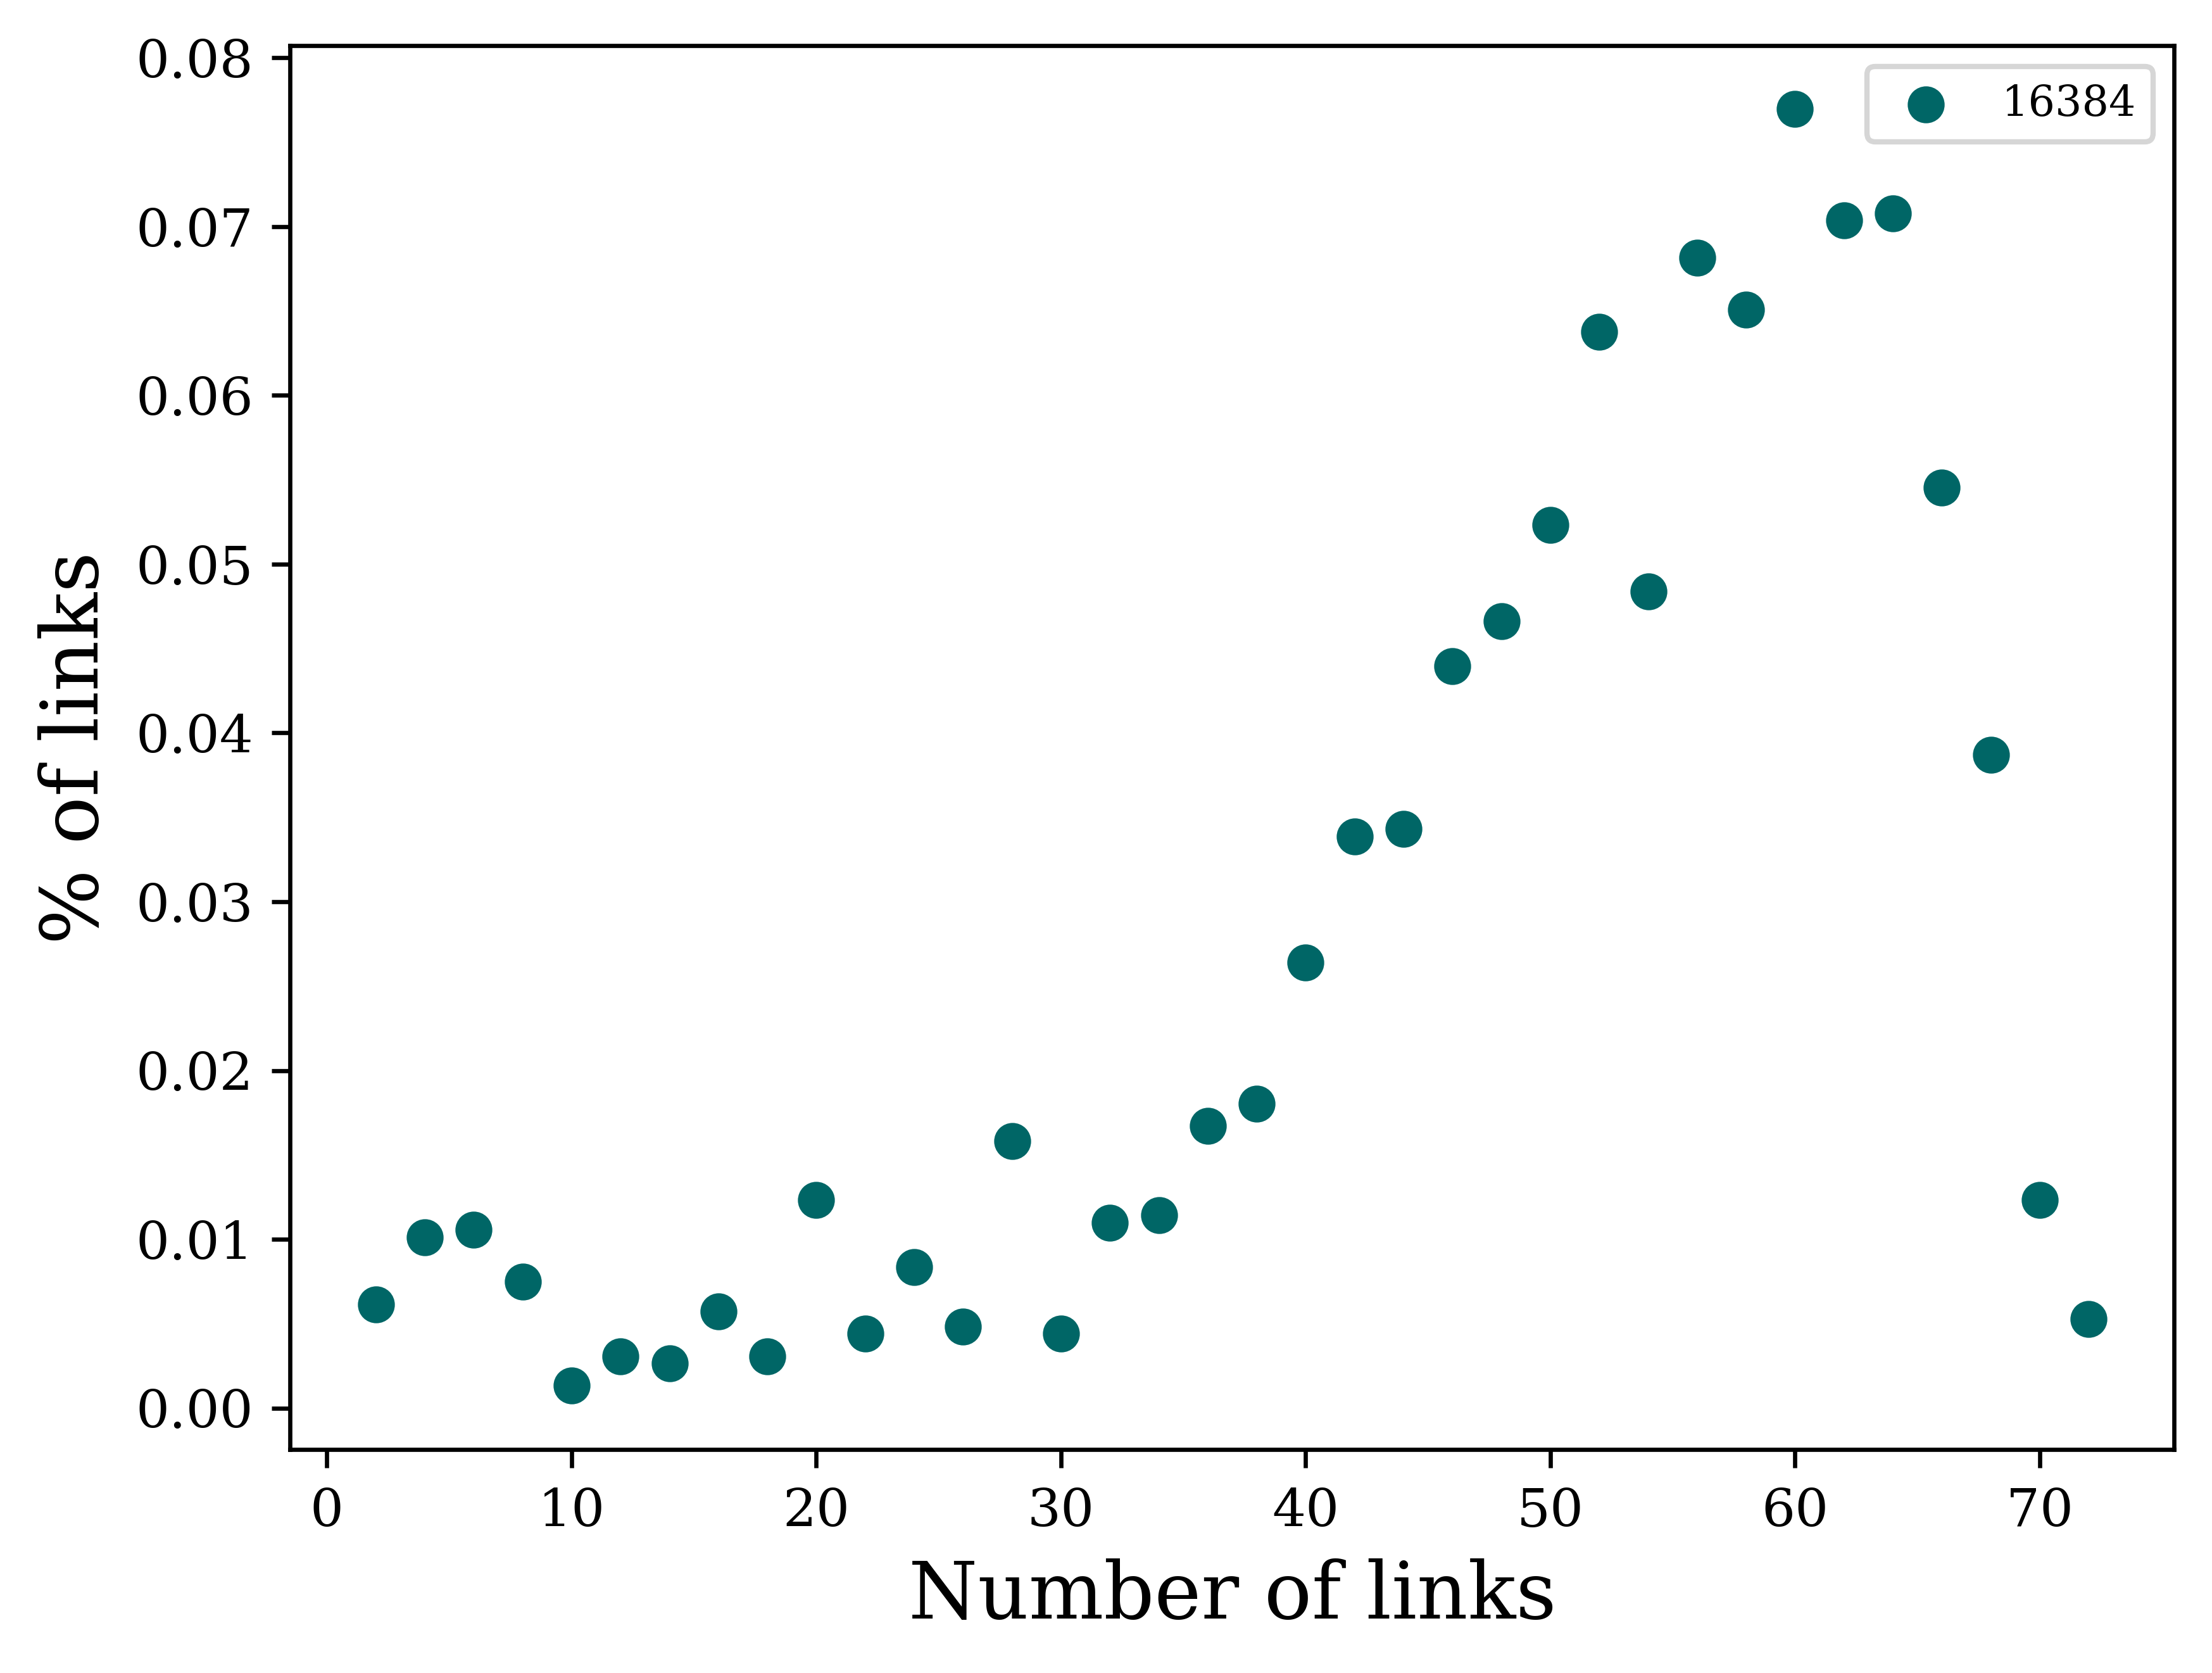

In [23]:
for ts in fr.keys():
    dist_ts = fr[ts]
    #print(dist_ts)
    x = sorted(dist_ts.keys())
    # Cálculos
    dados = x
    media = np.mean(dados)
    mediana = np.median(dados)
    moda = stats.mode(dados)[0][0]  # Retorna o valor mais frequente
    desvio_padrao = np.std(dados, ddof=1)  # Use ddof=1 para amostra
    variancia = np.var(dados, ddof=1)  # Use ddof=1 para amostra
    amplitude = np.max(dados) - np.min(dados)
    assimetria = stats.skew(dados)
    curtose = stats.kurtosis(dados, fisher=True)  # Fisher=True retorna a curtose excessiva

    # Exibindo os resultados
    print(f"Média: {media}")
    print(f"Mediana: {mediana}")
    print(f"Moda: {moda}")
    print(f"Desvio Padrão: {desvio_padrao}")
    print(f"Variância: {variancia}")
    print(f"Amplitude: {amplitude}")
    print(f"Assimetria: {assimetria}")
    print(f"Curtose: {curtose}")
    y = np.array([dist_ts[i] for i in x])
    y_normalized = y / sum(y)
    x = np.array(x)
    plt.figure(dpi = 600)
    plt.scatter(x[x%2 == 0], np.array(y_normalized)[x%2 == 0], color='#006666', label = '%d'%ts)
    plt.xlabel("Number of links")
    plt.ylabel("% of links")
    plt.legend()
    plt.show()

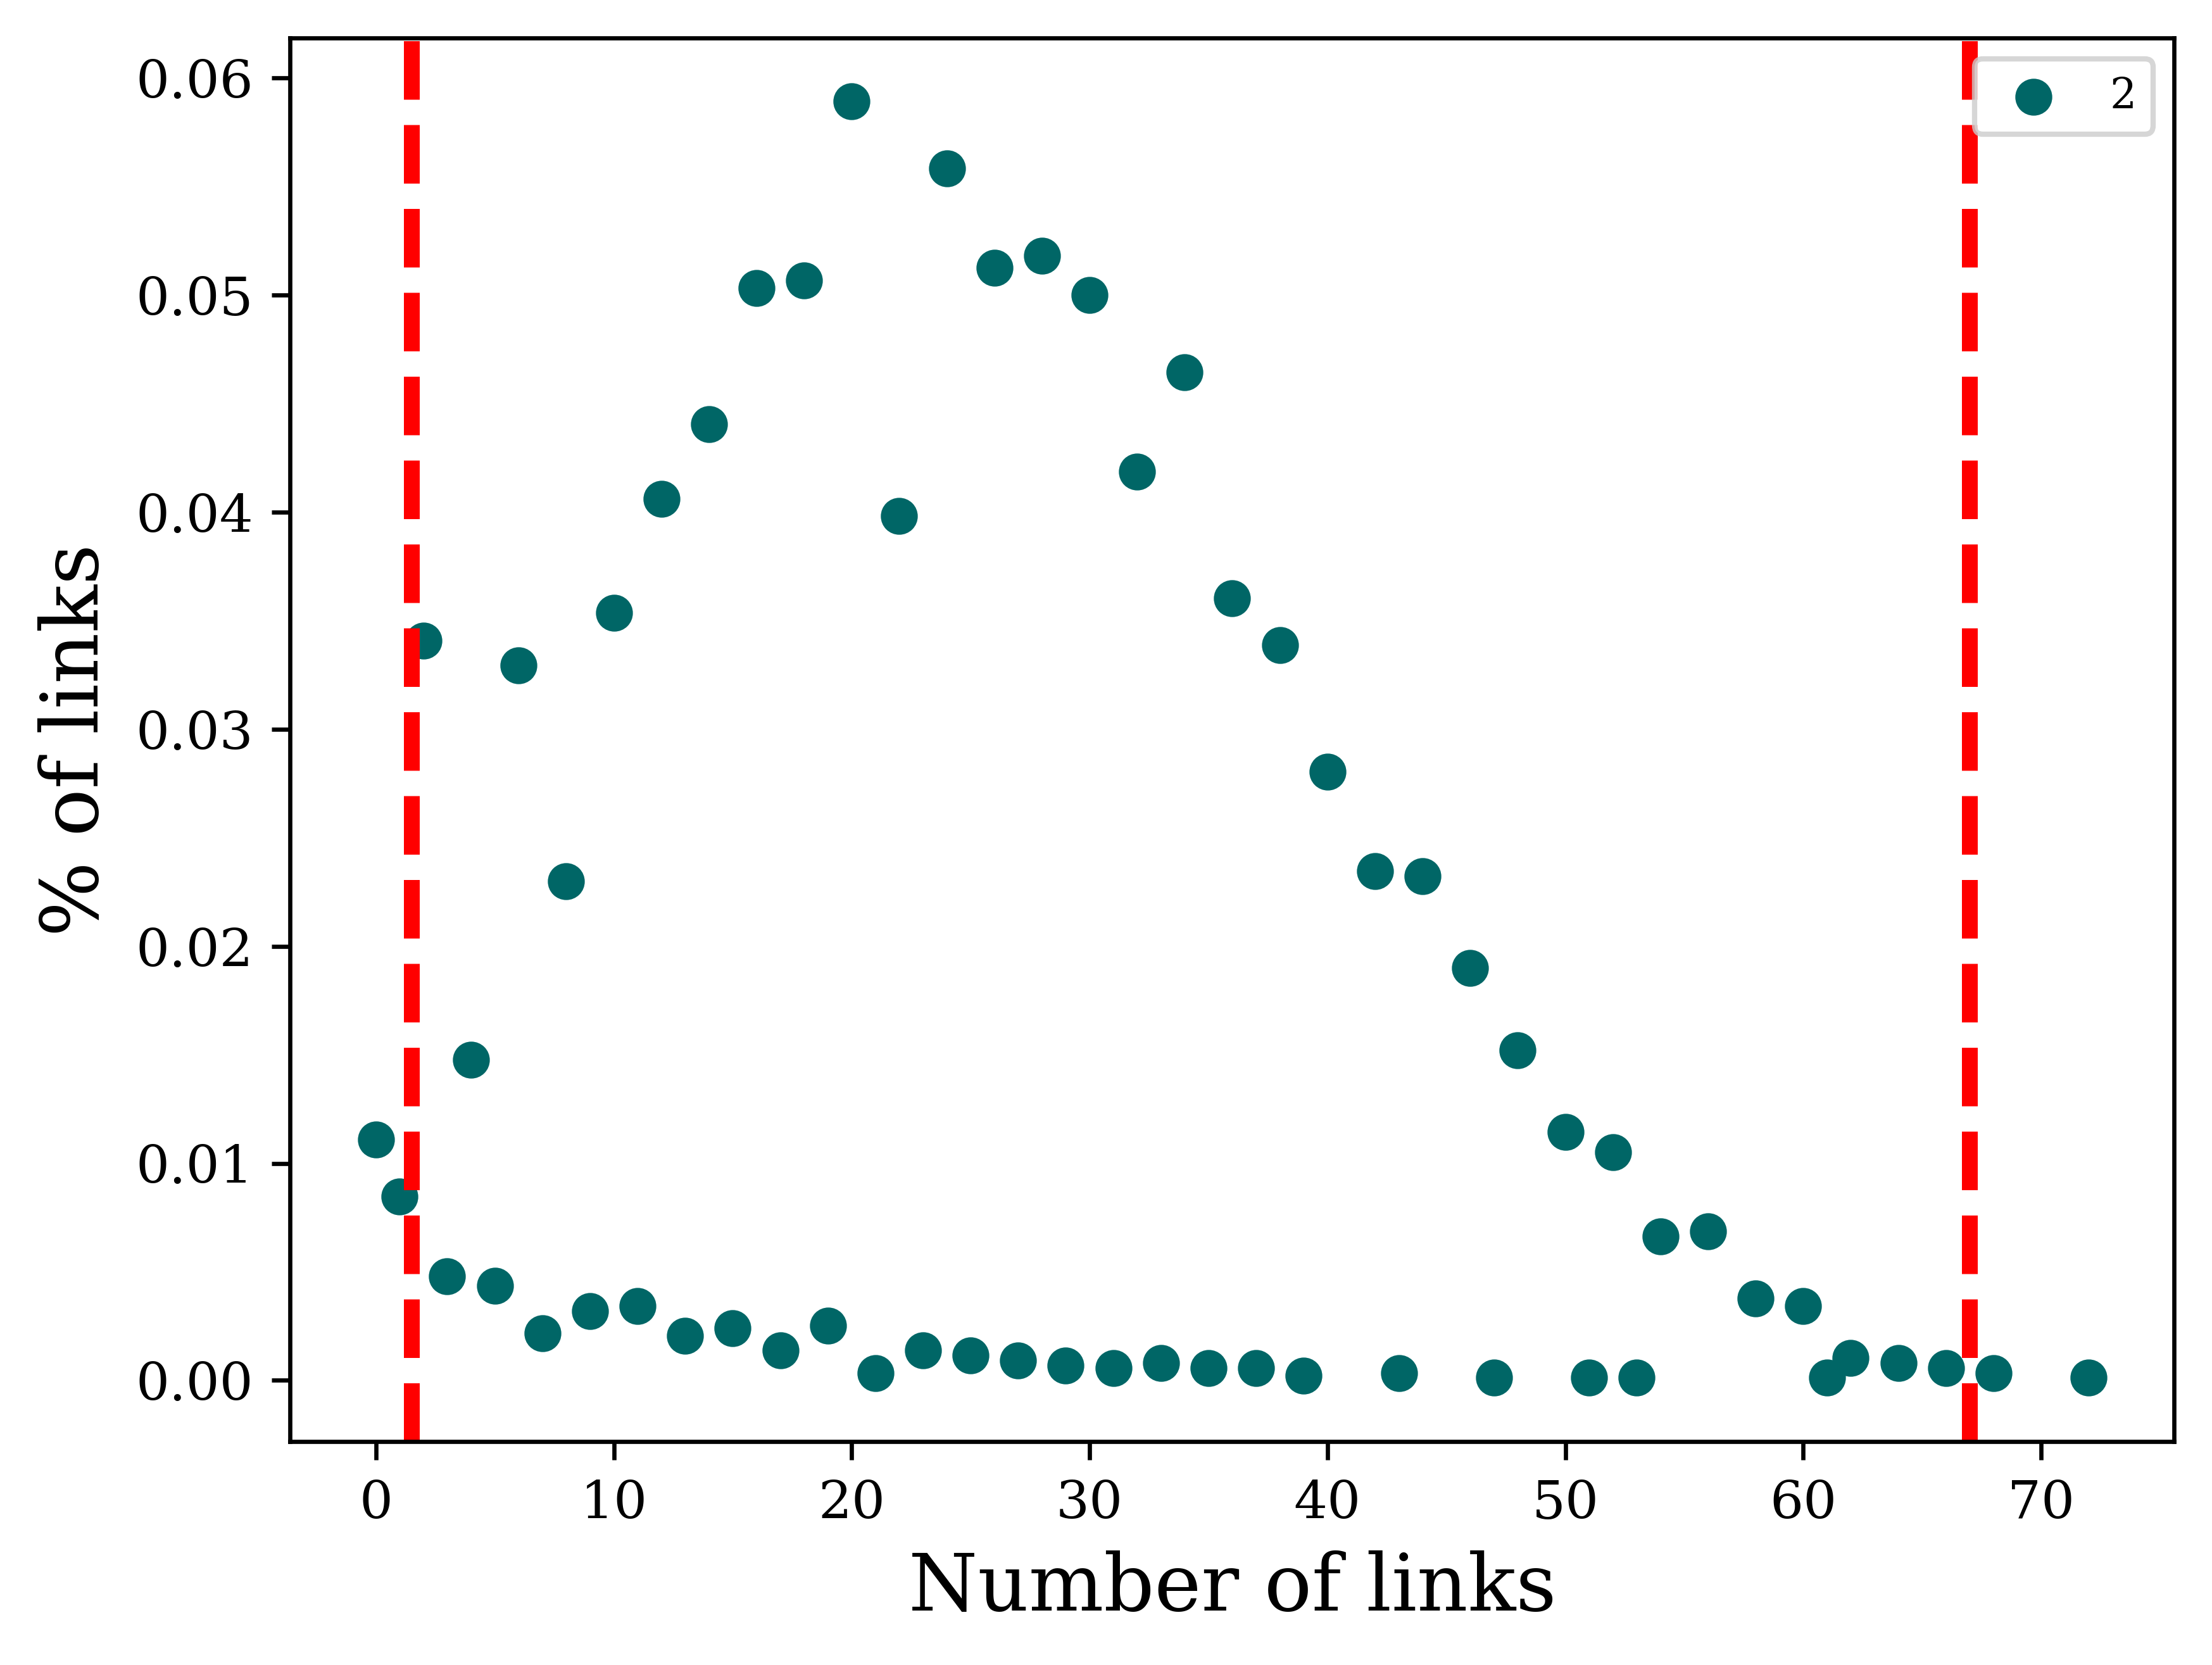

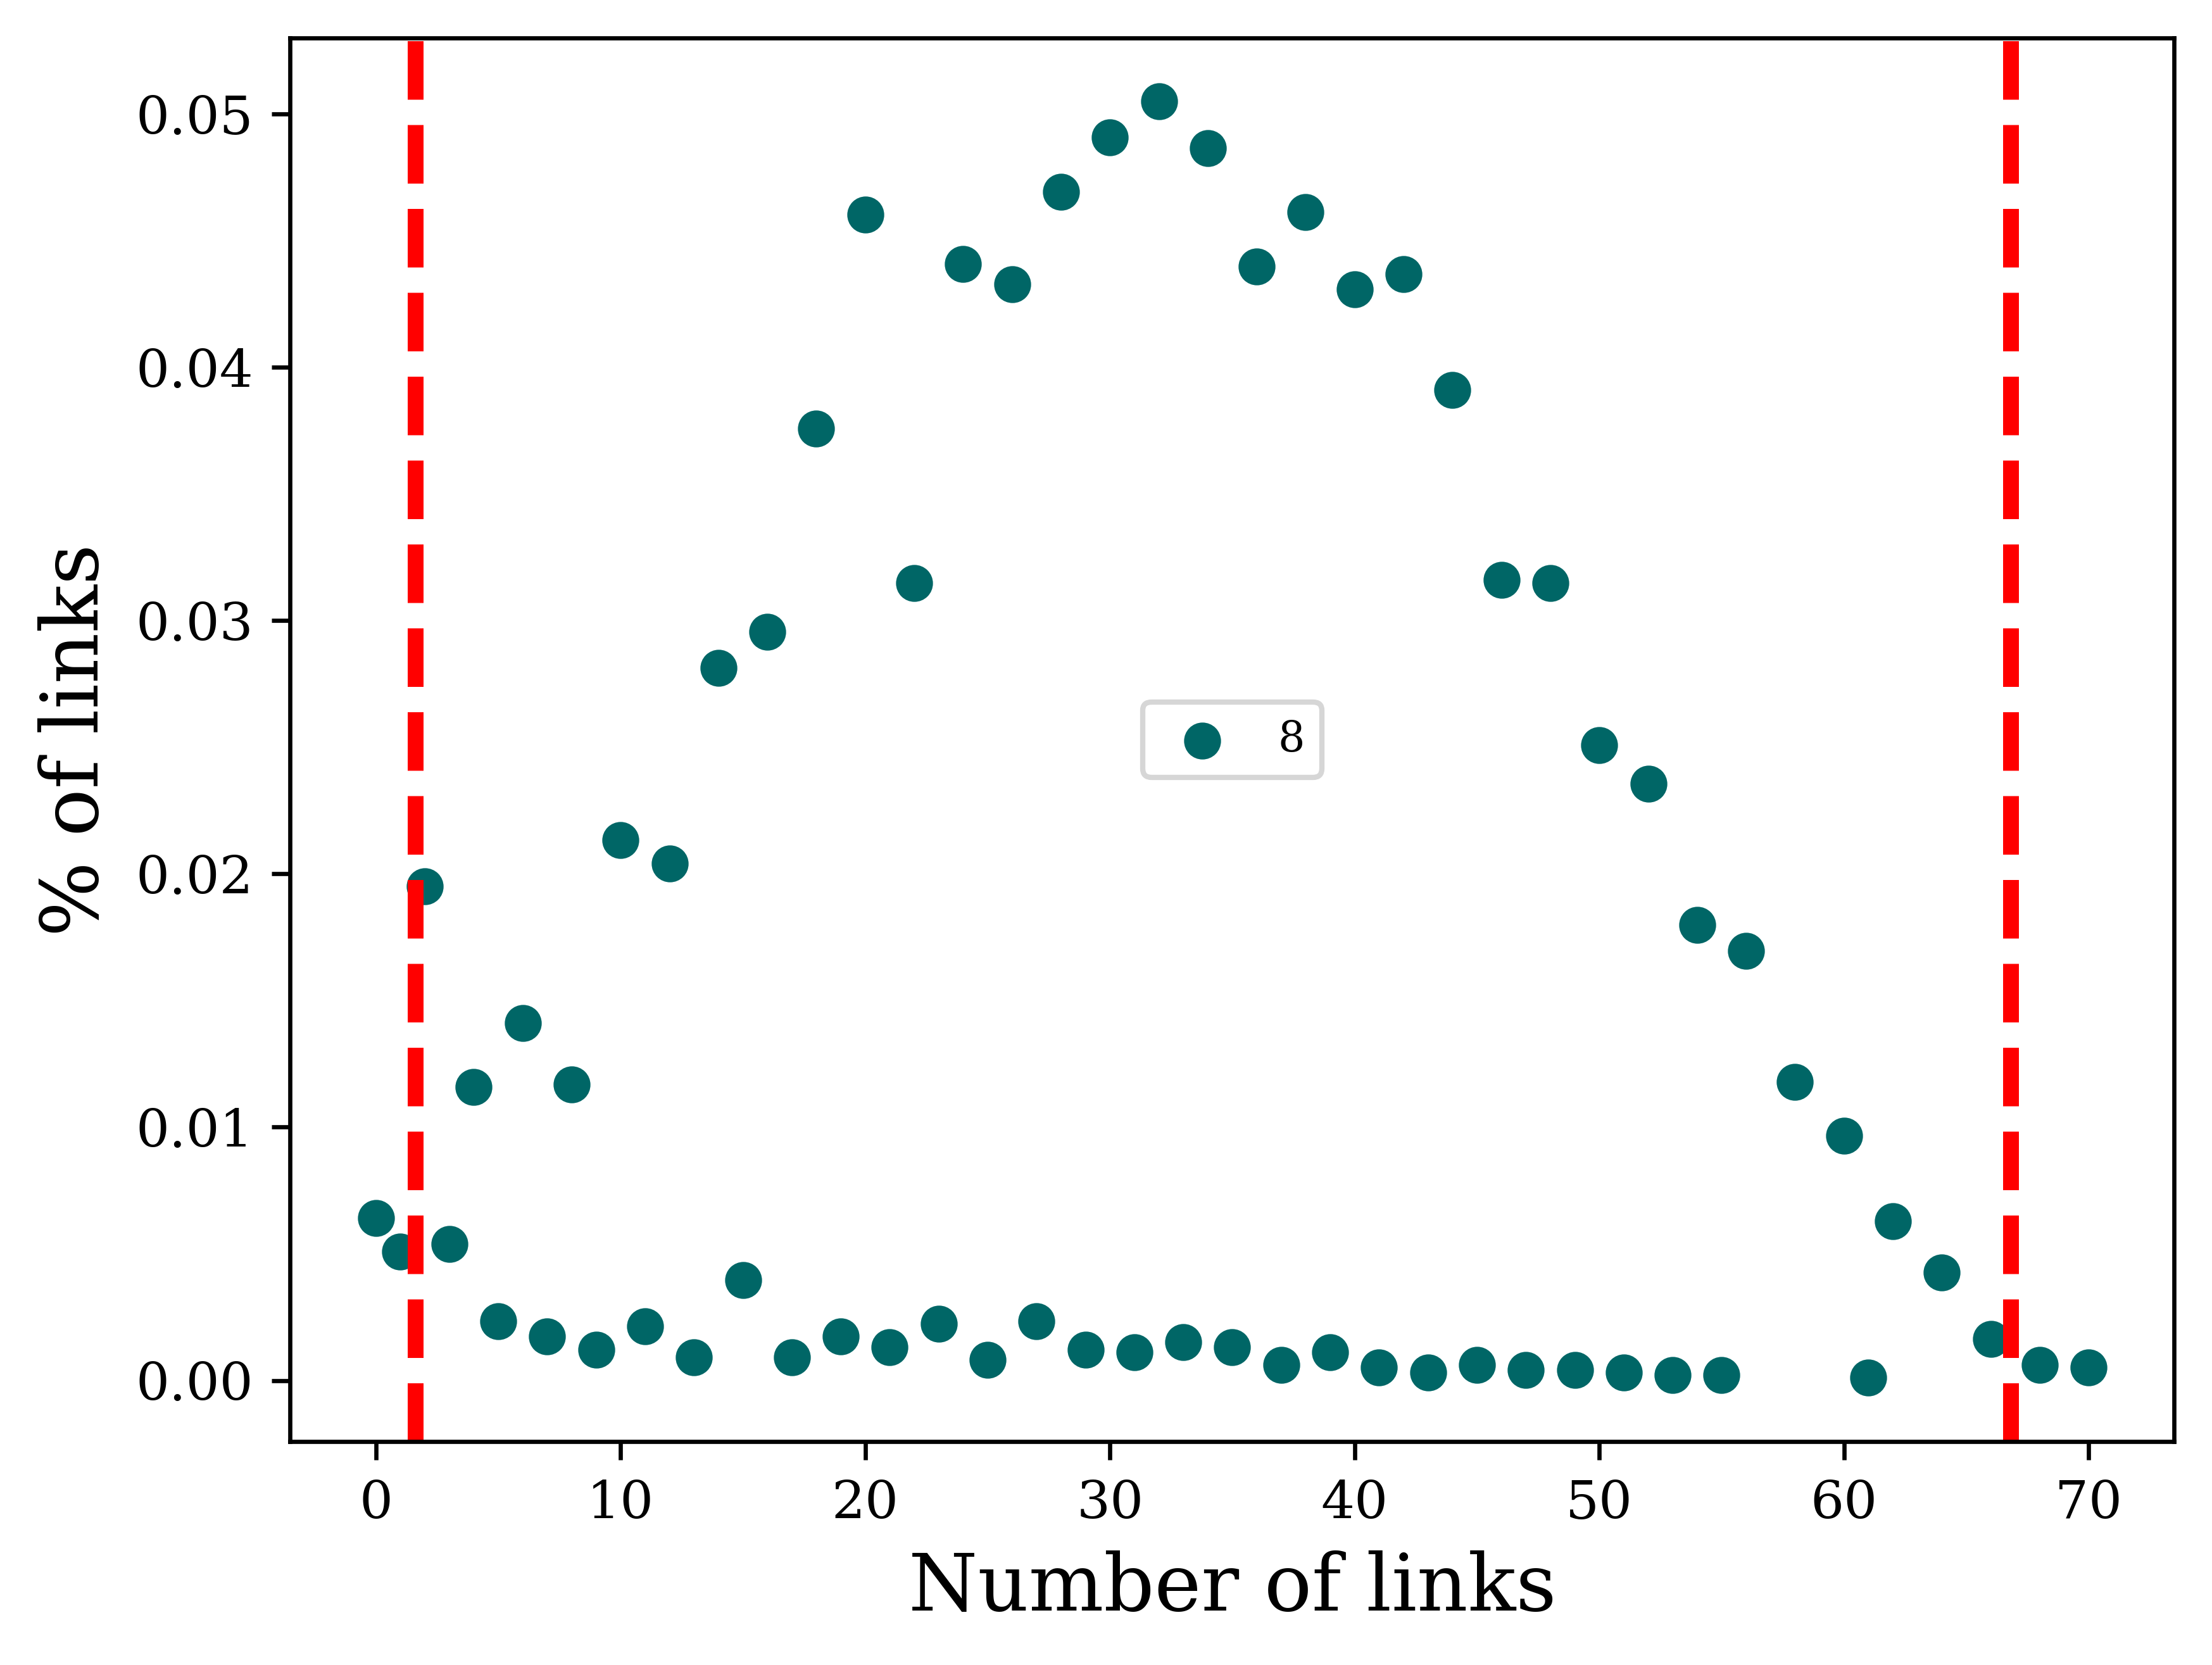

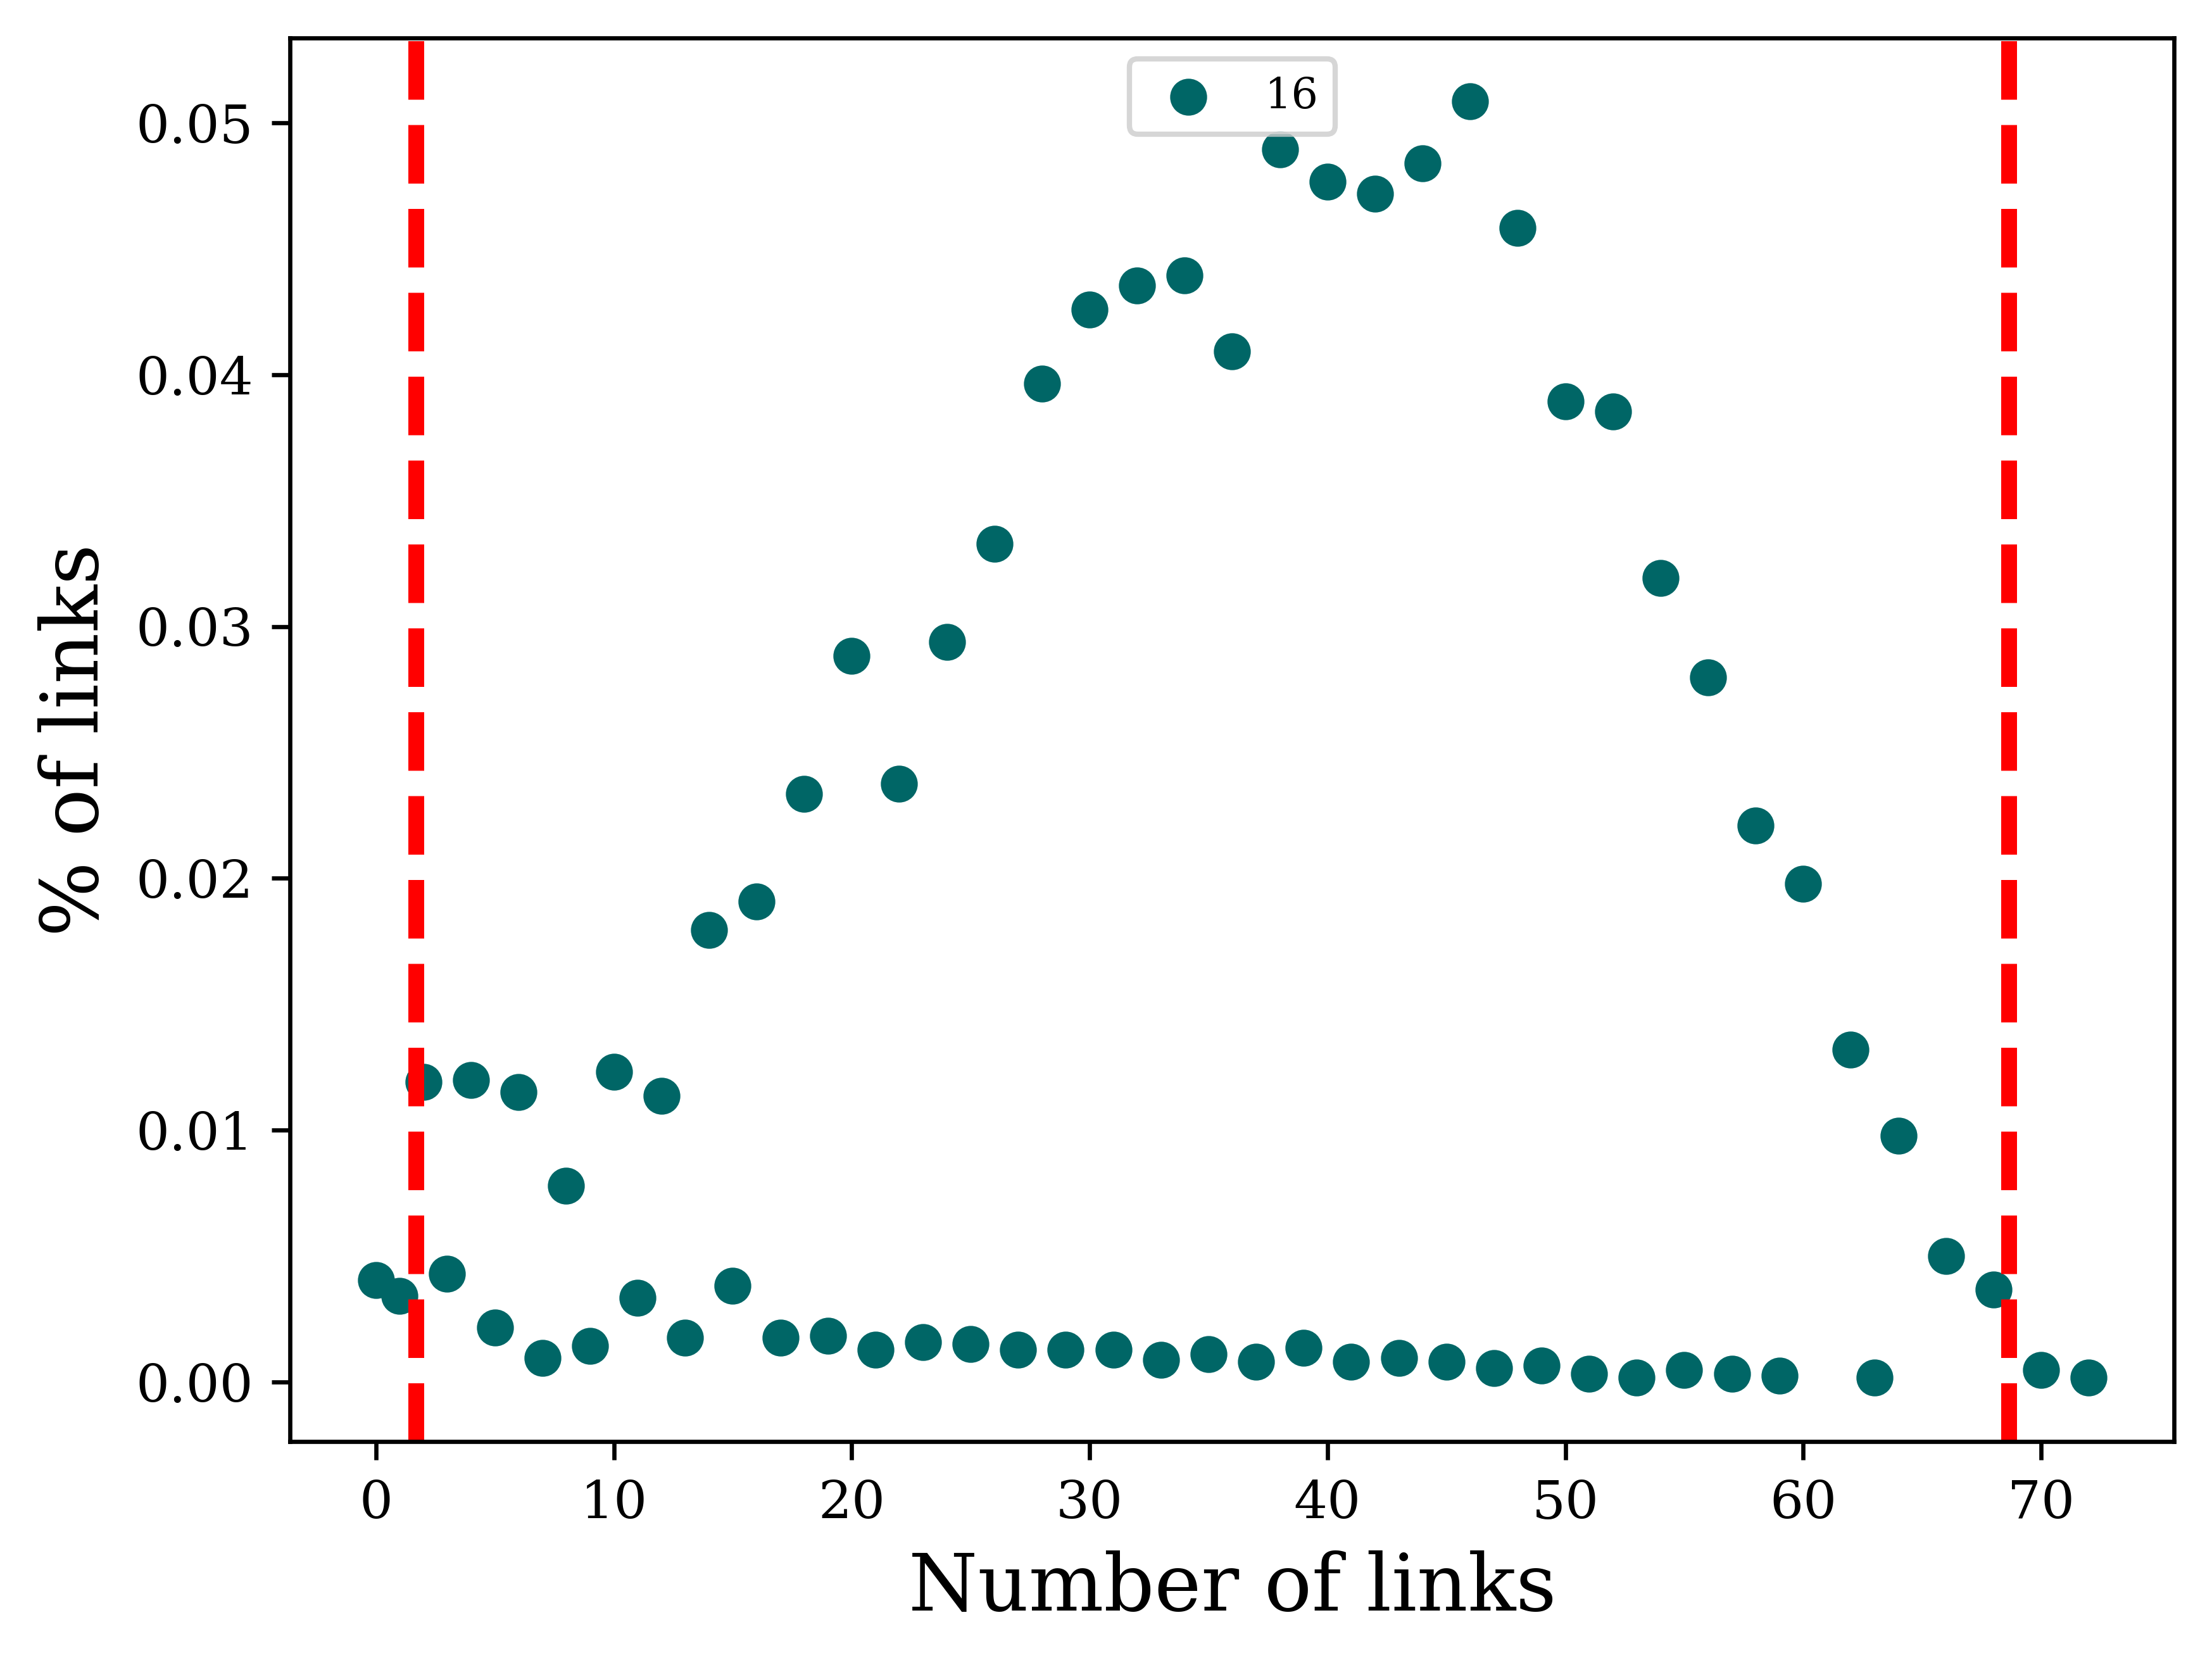

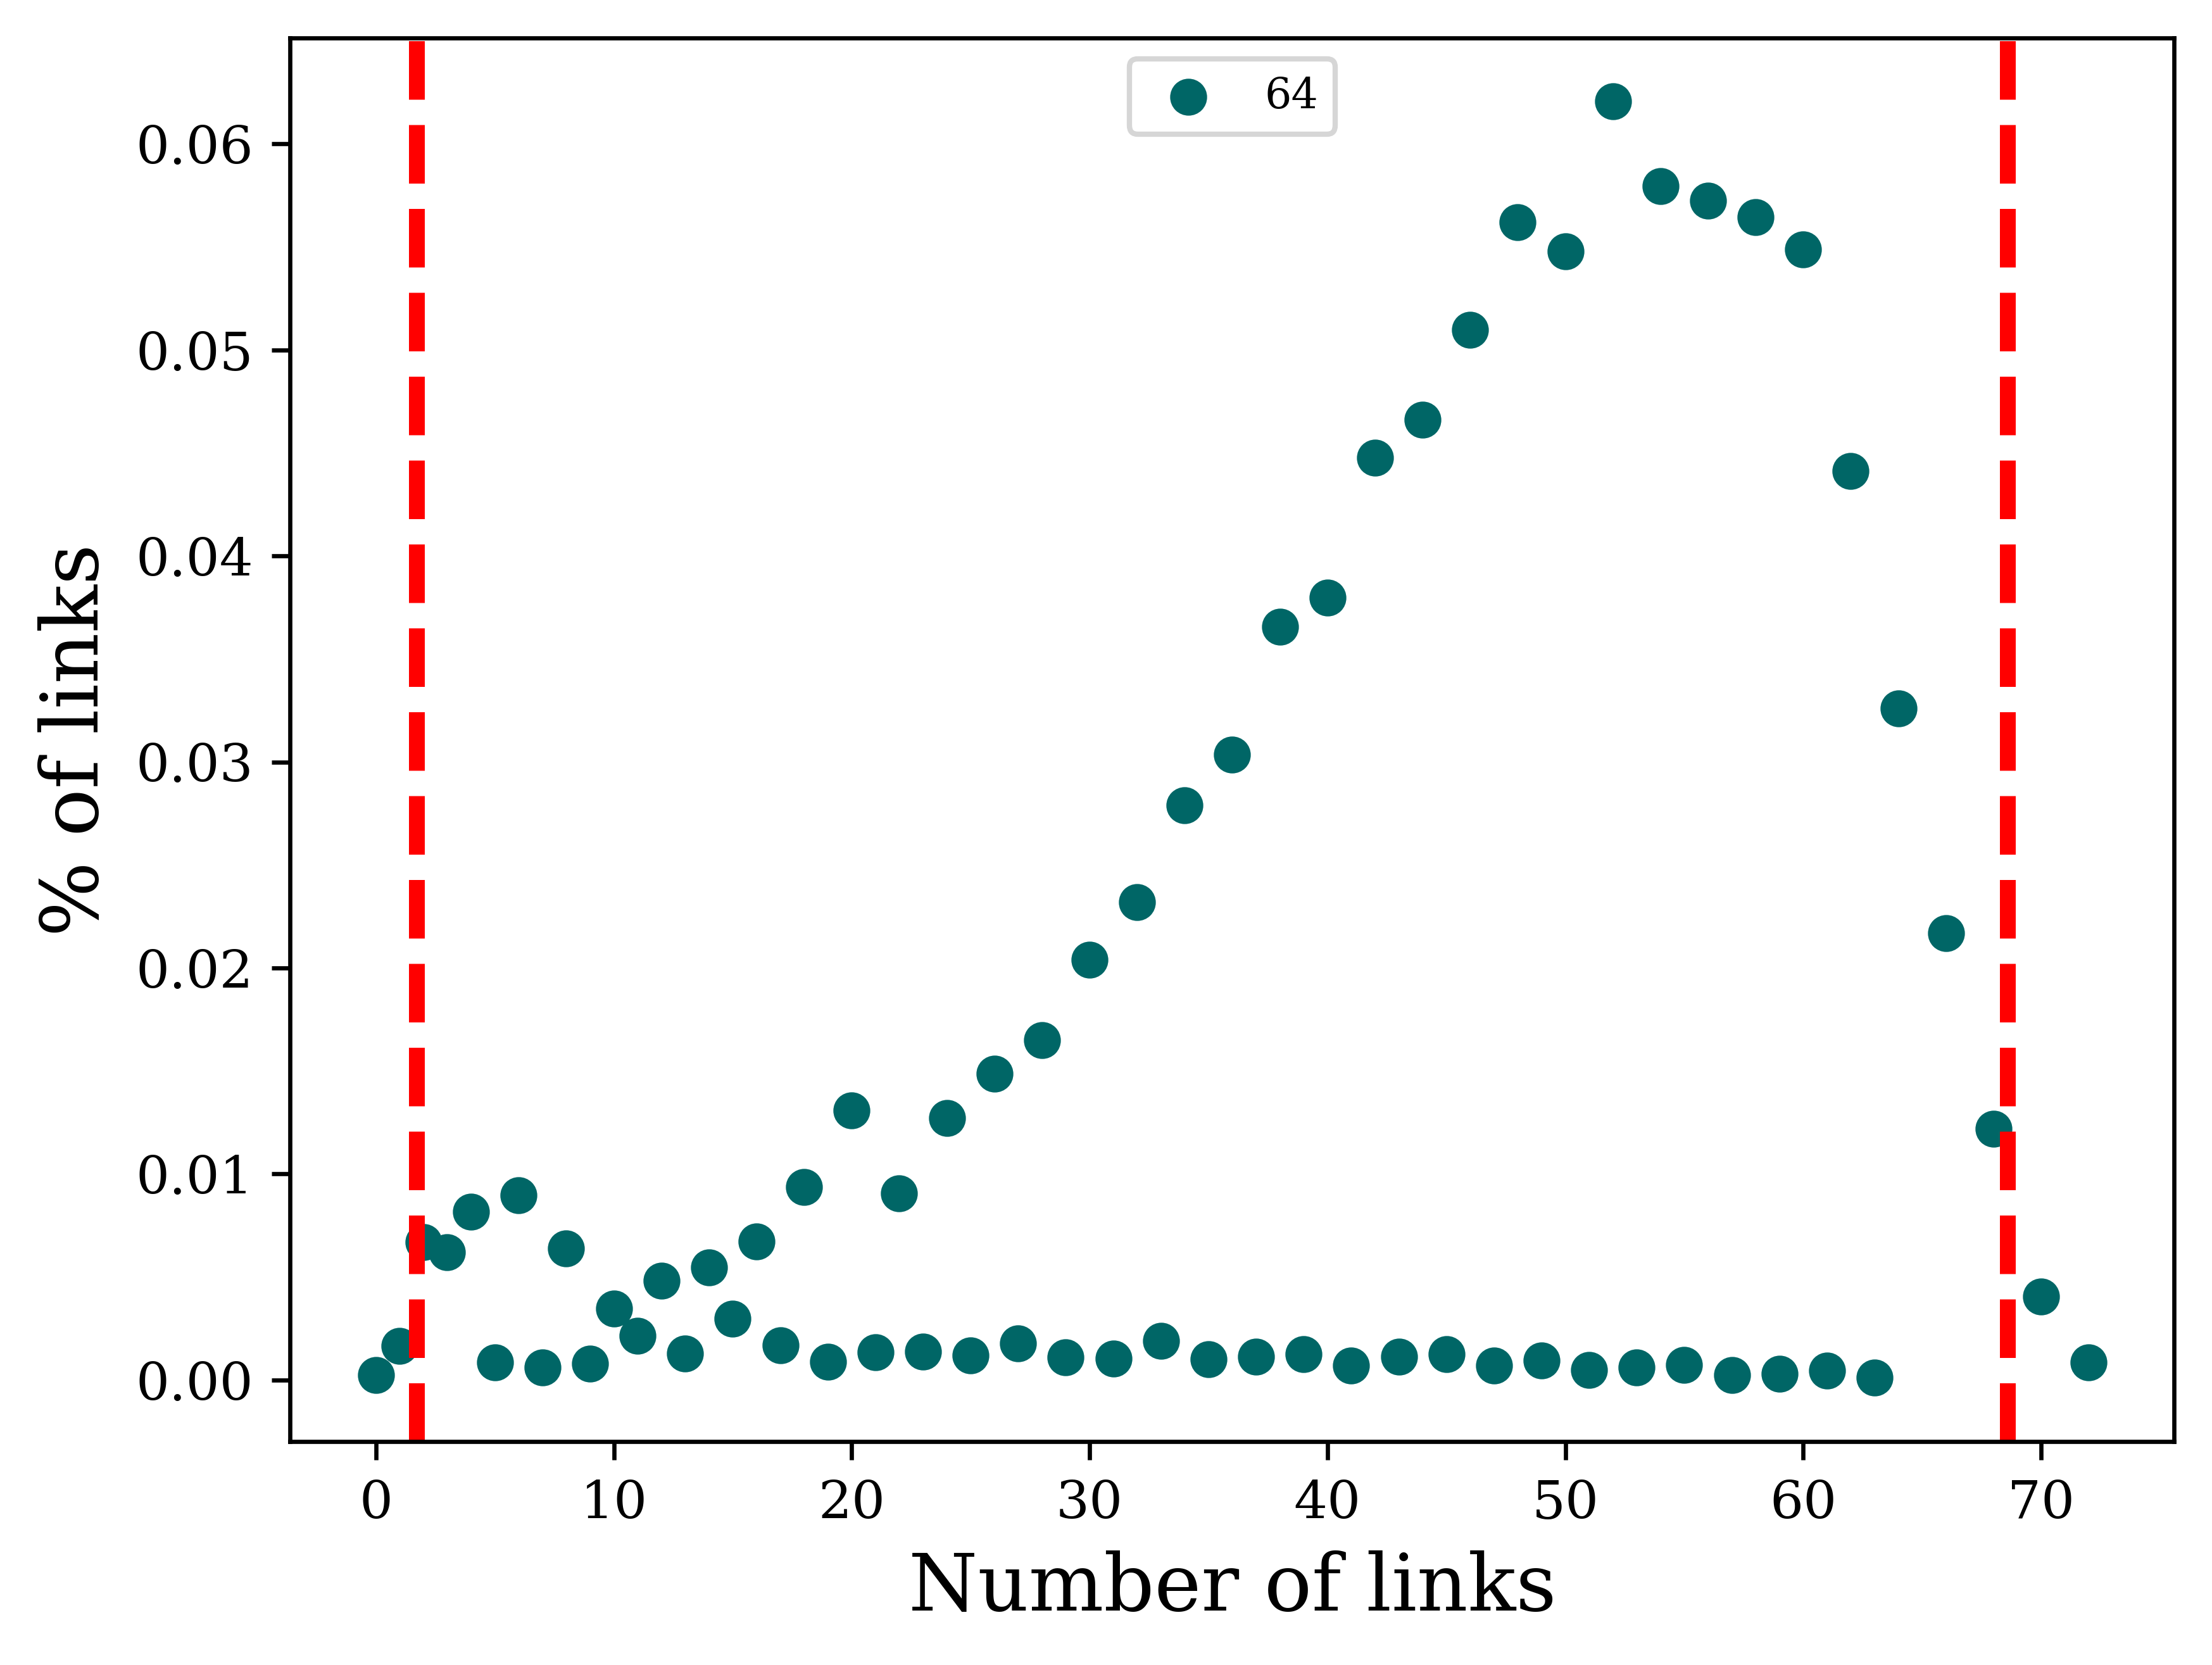

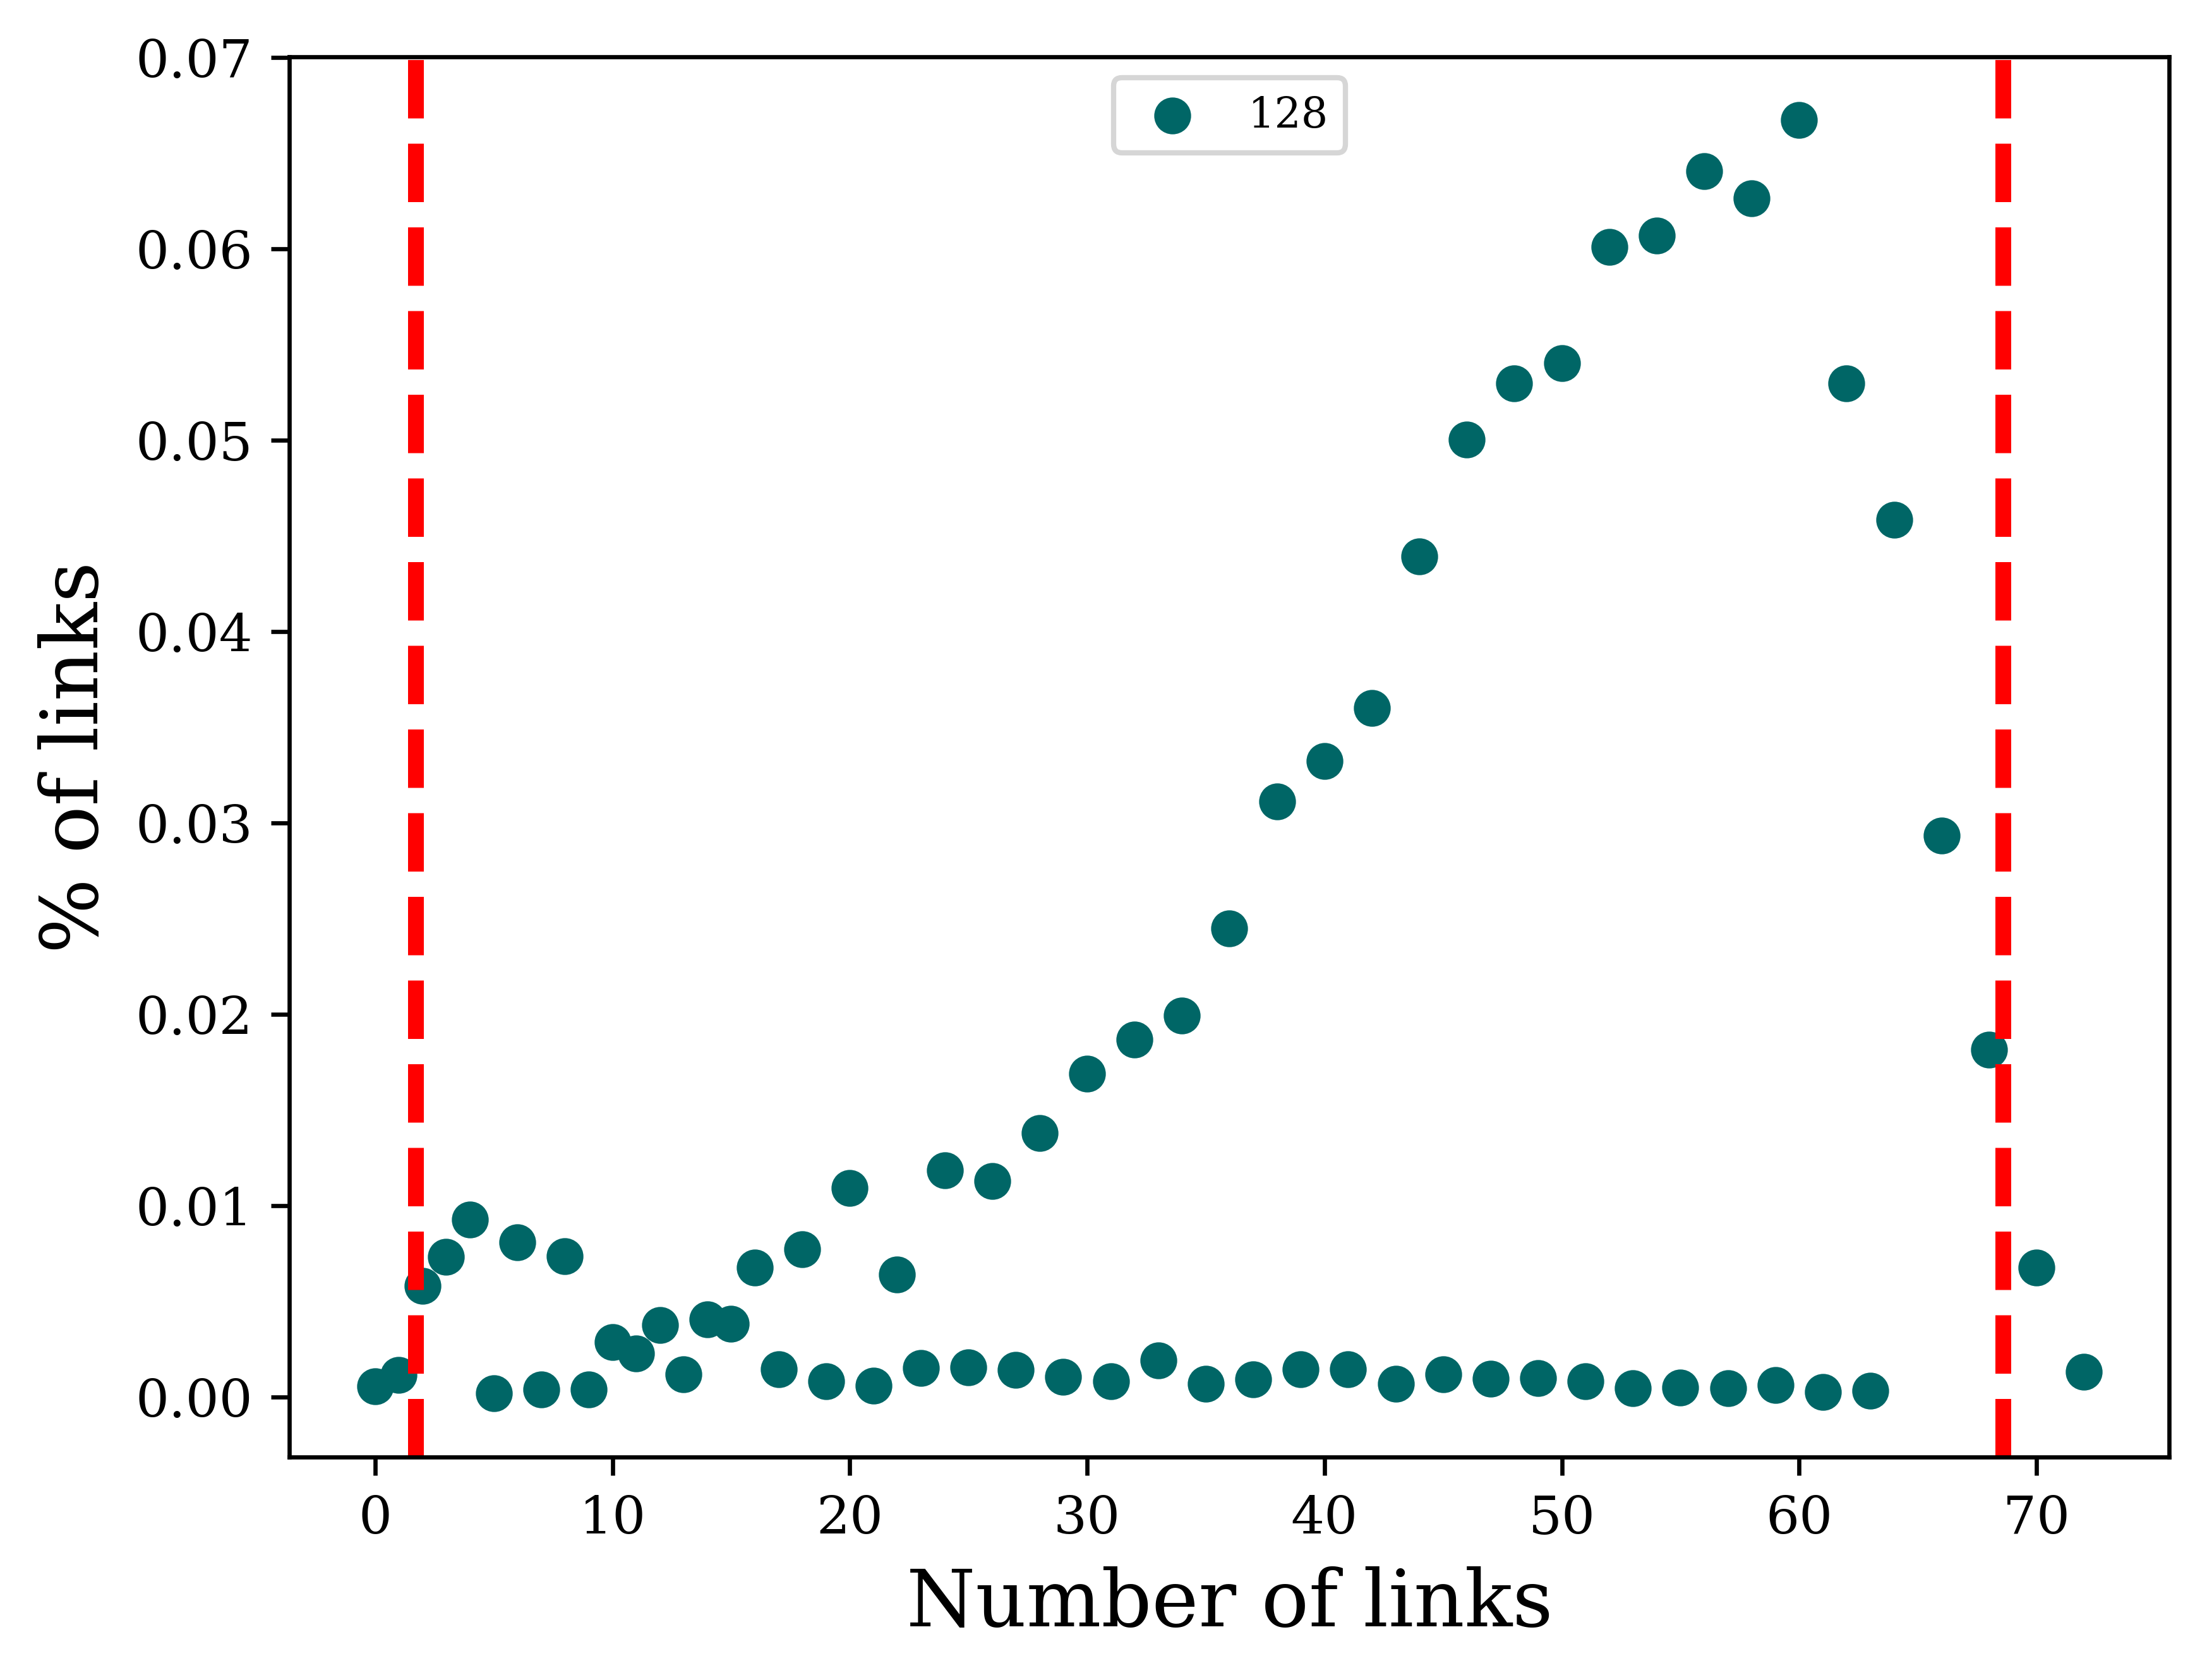

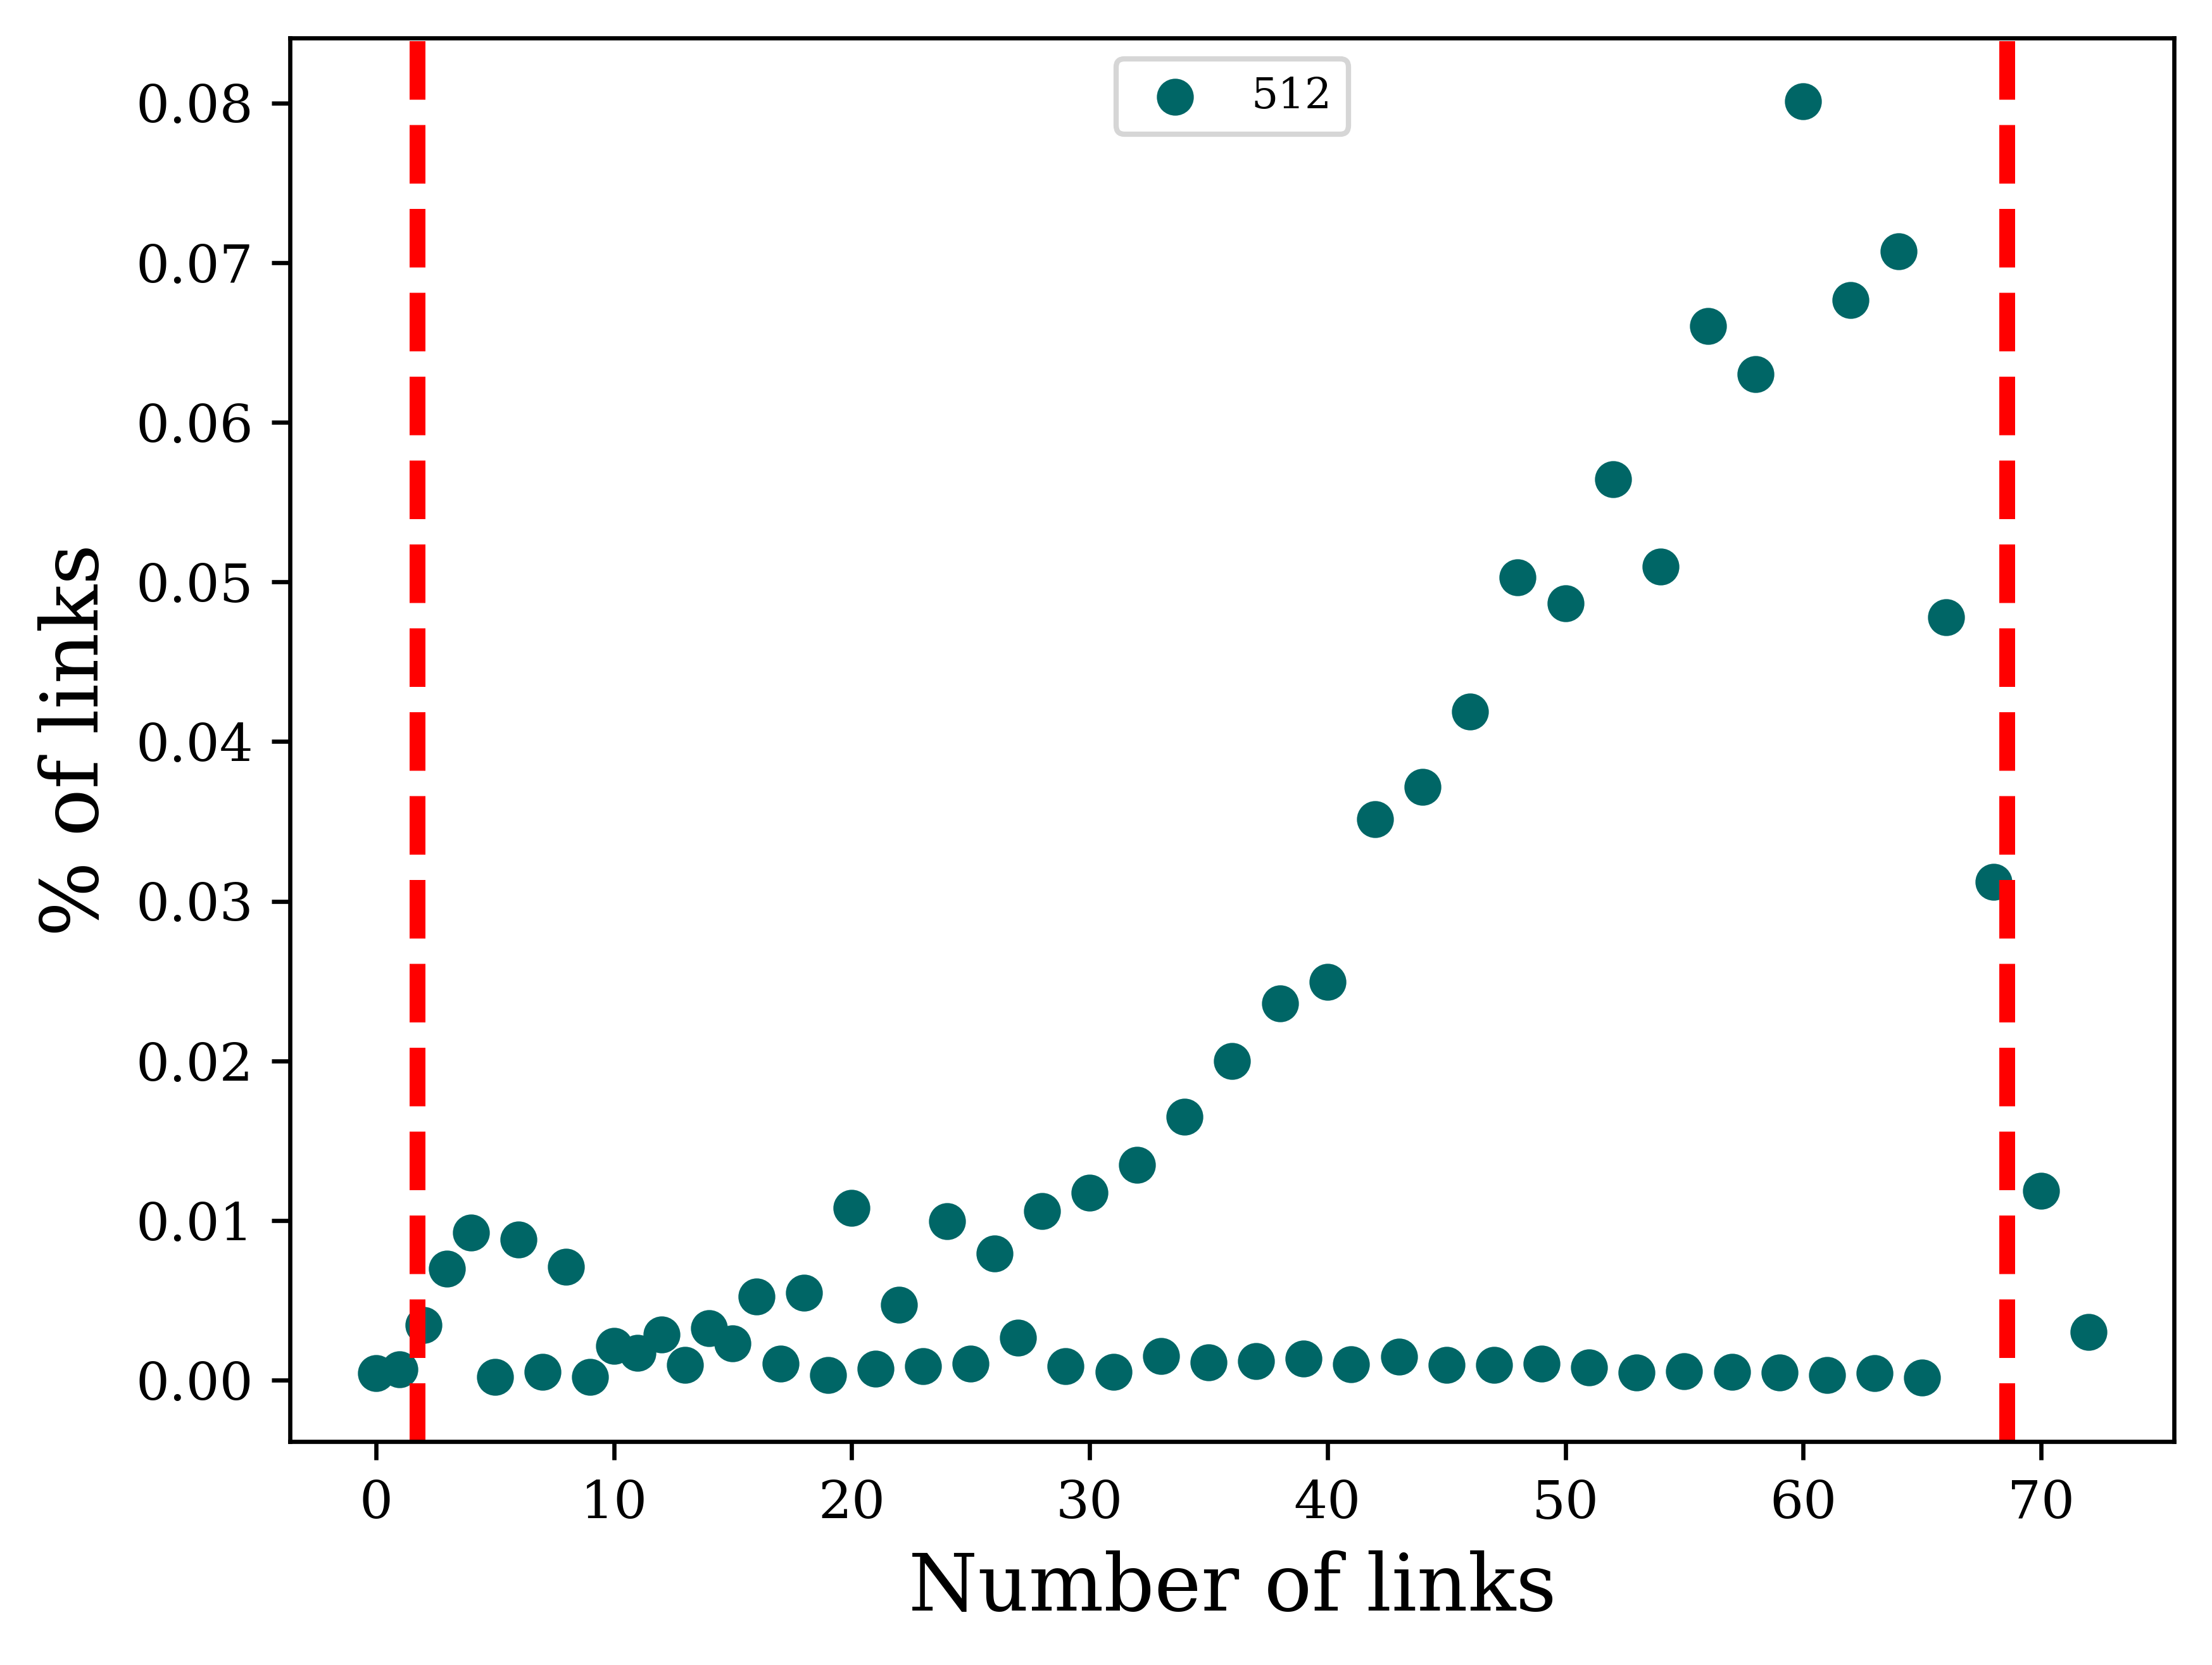

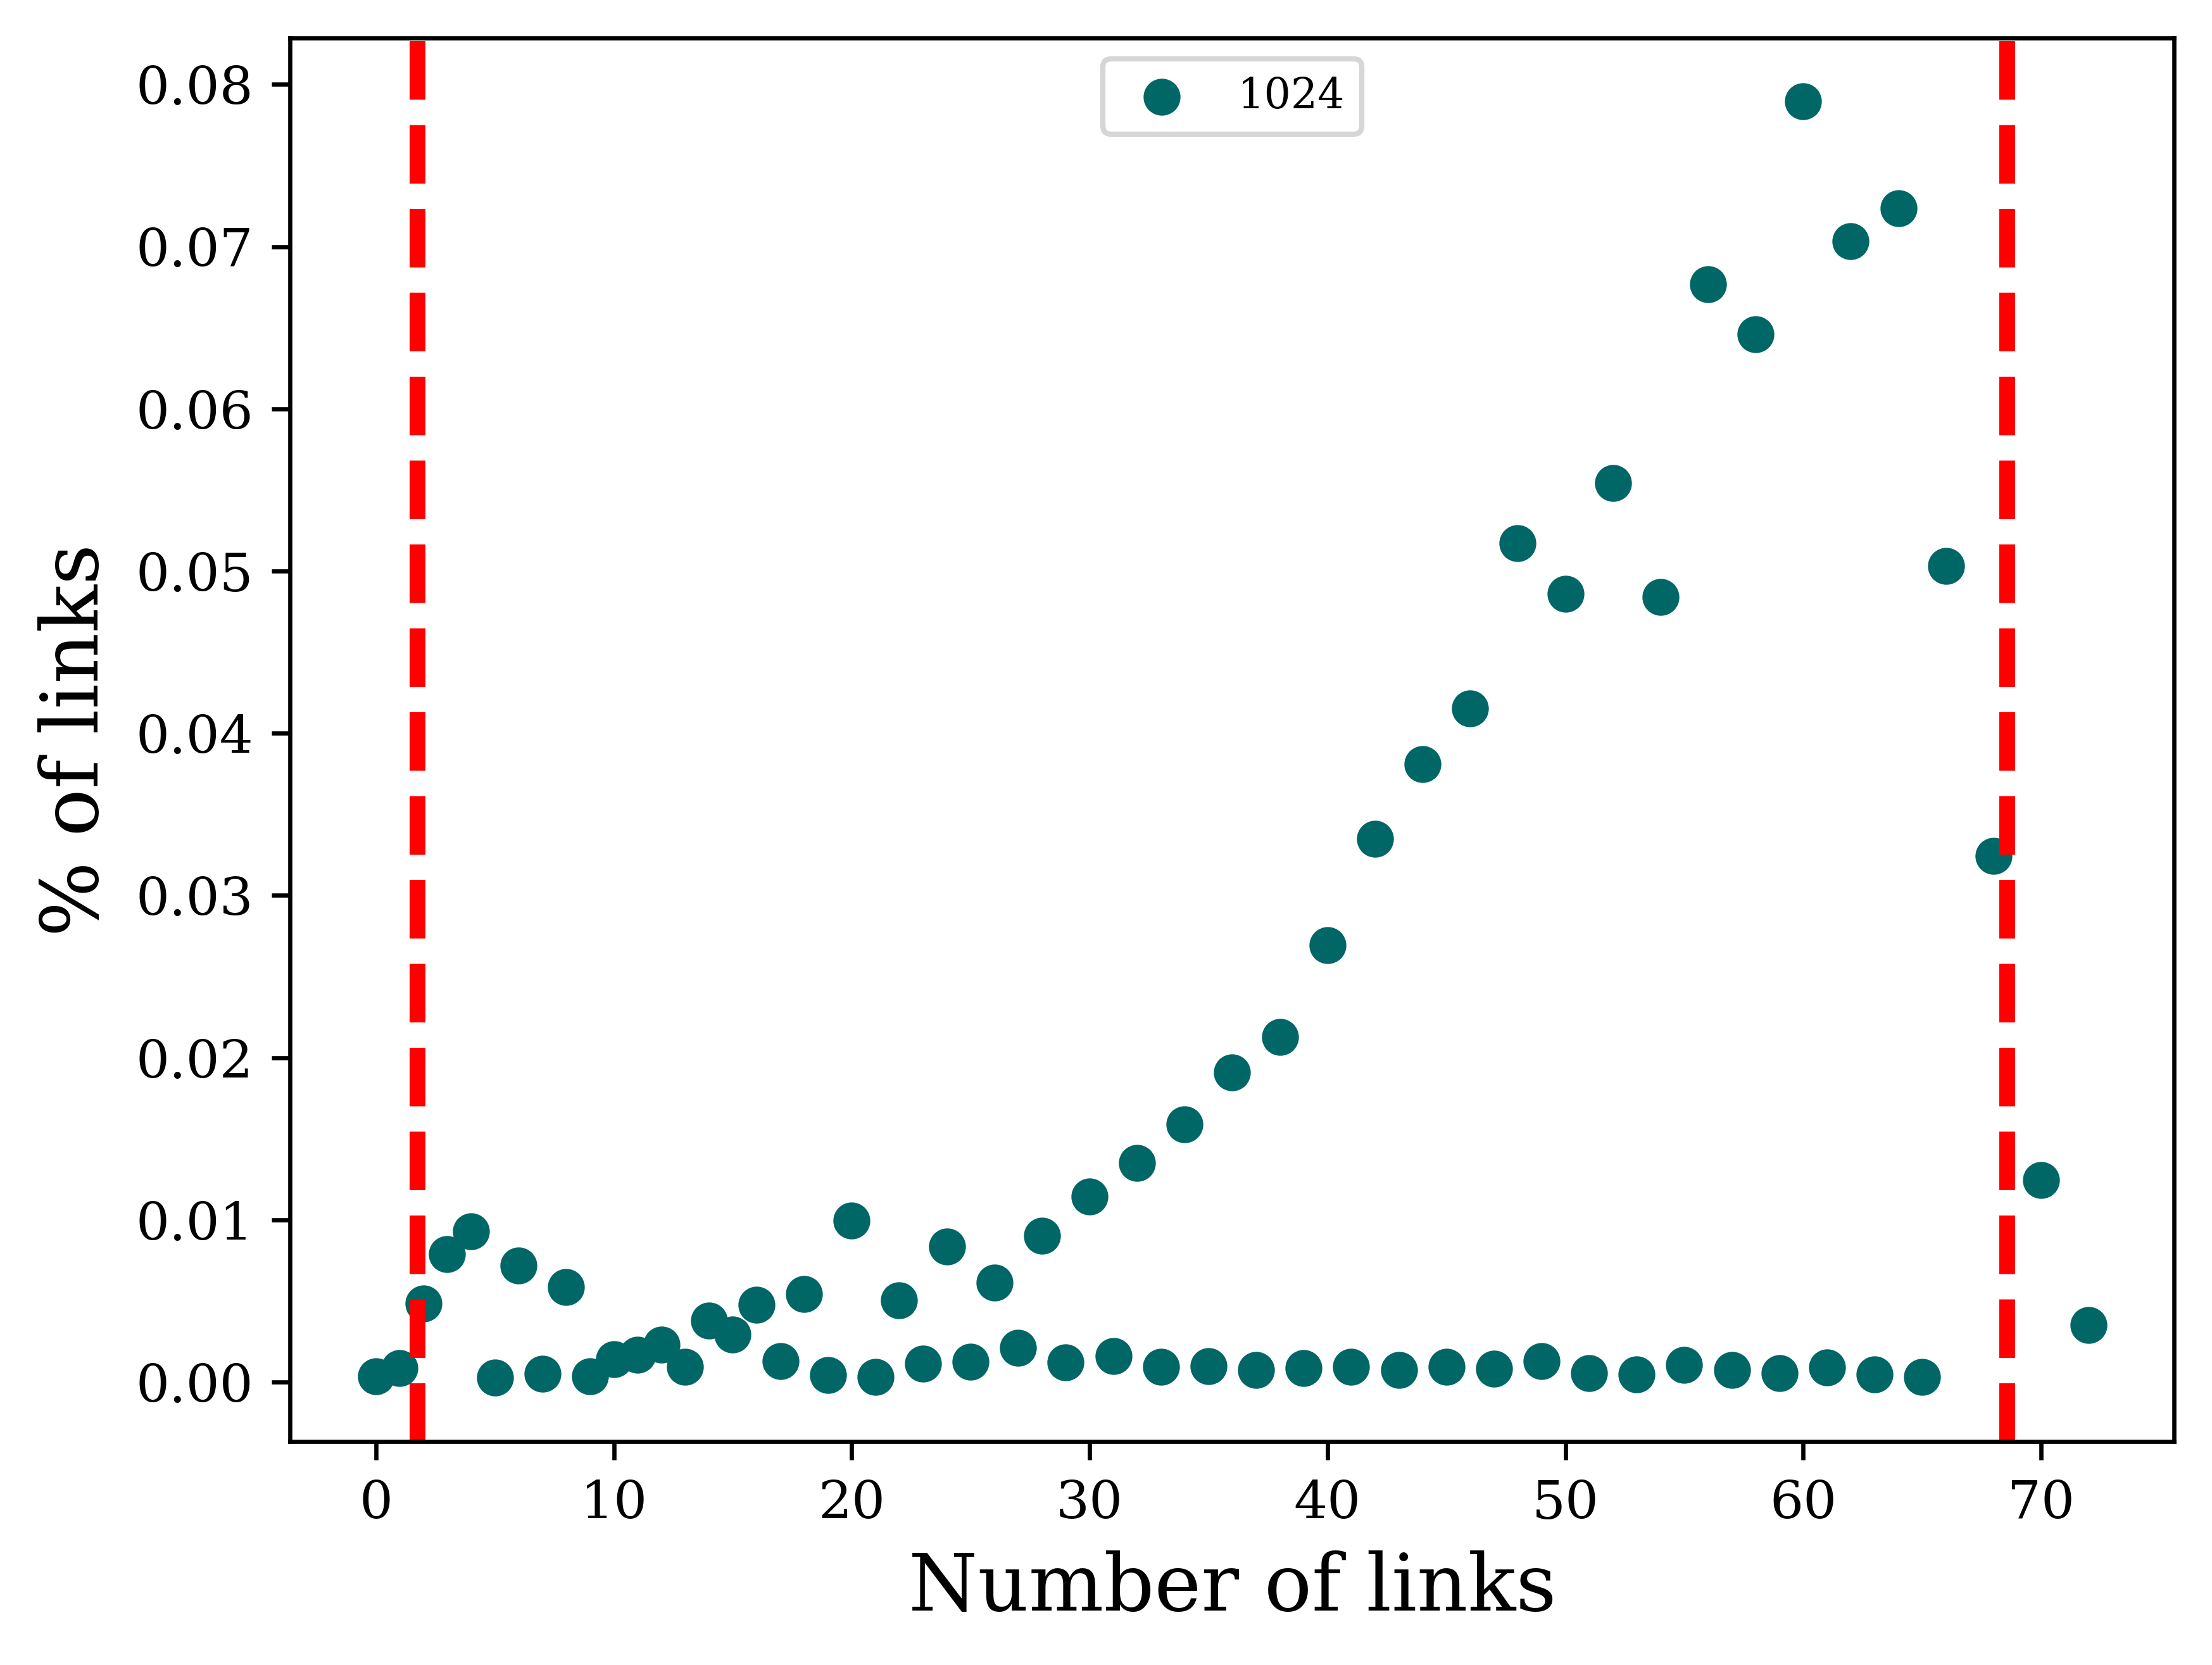

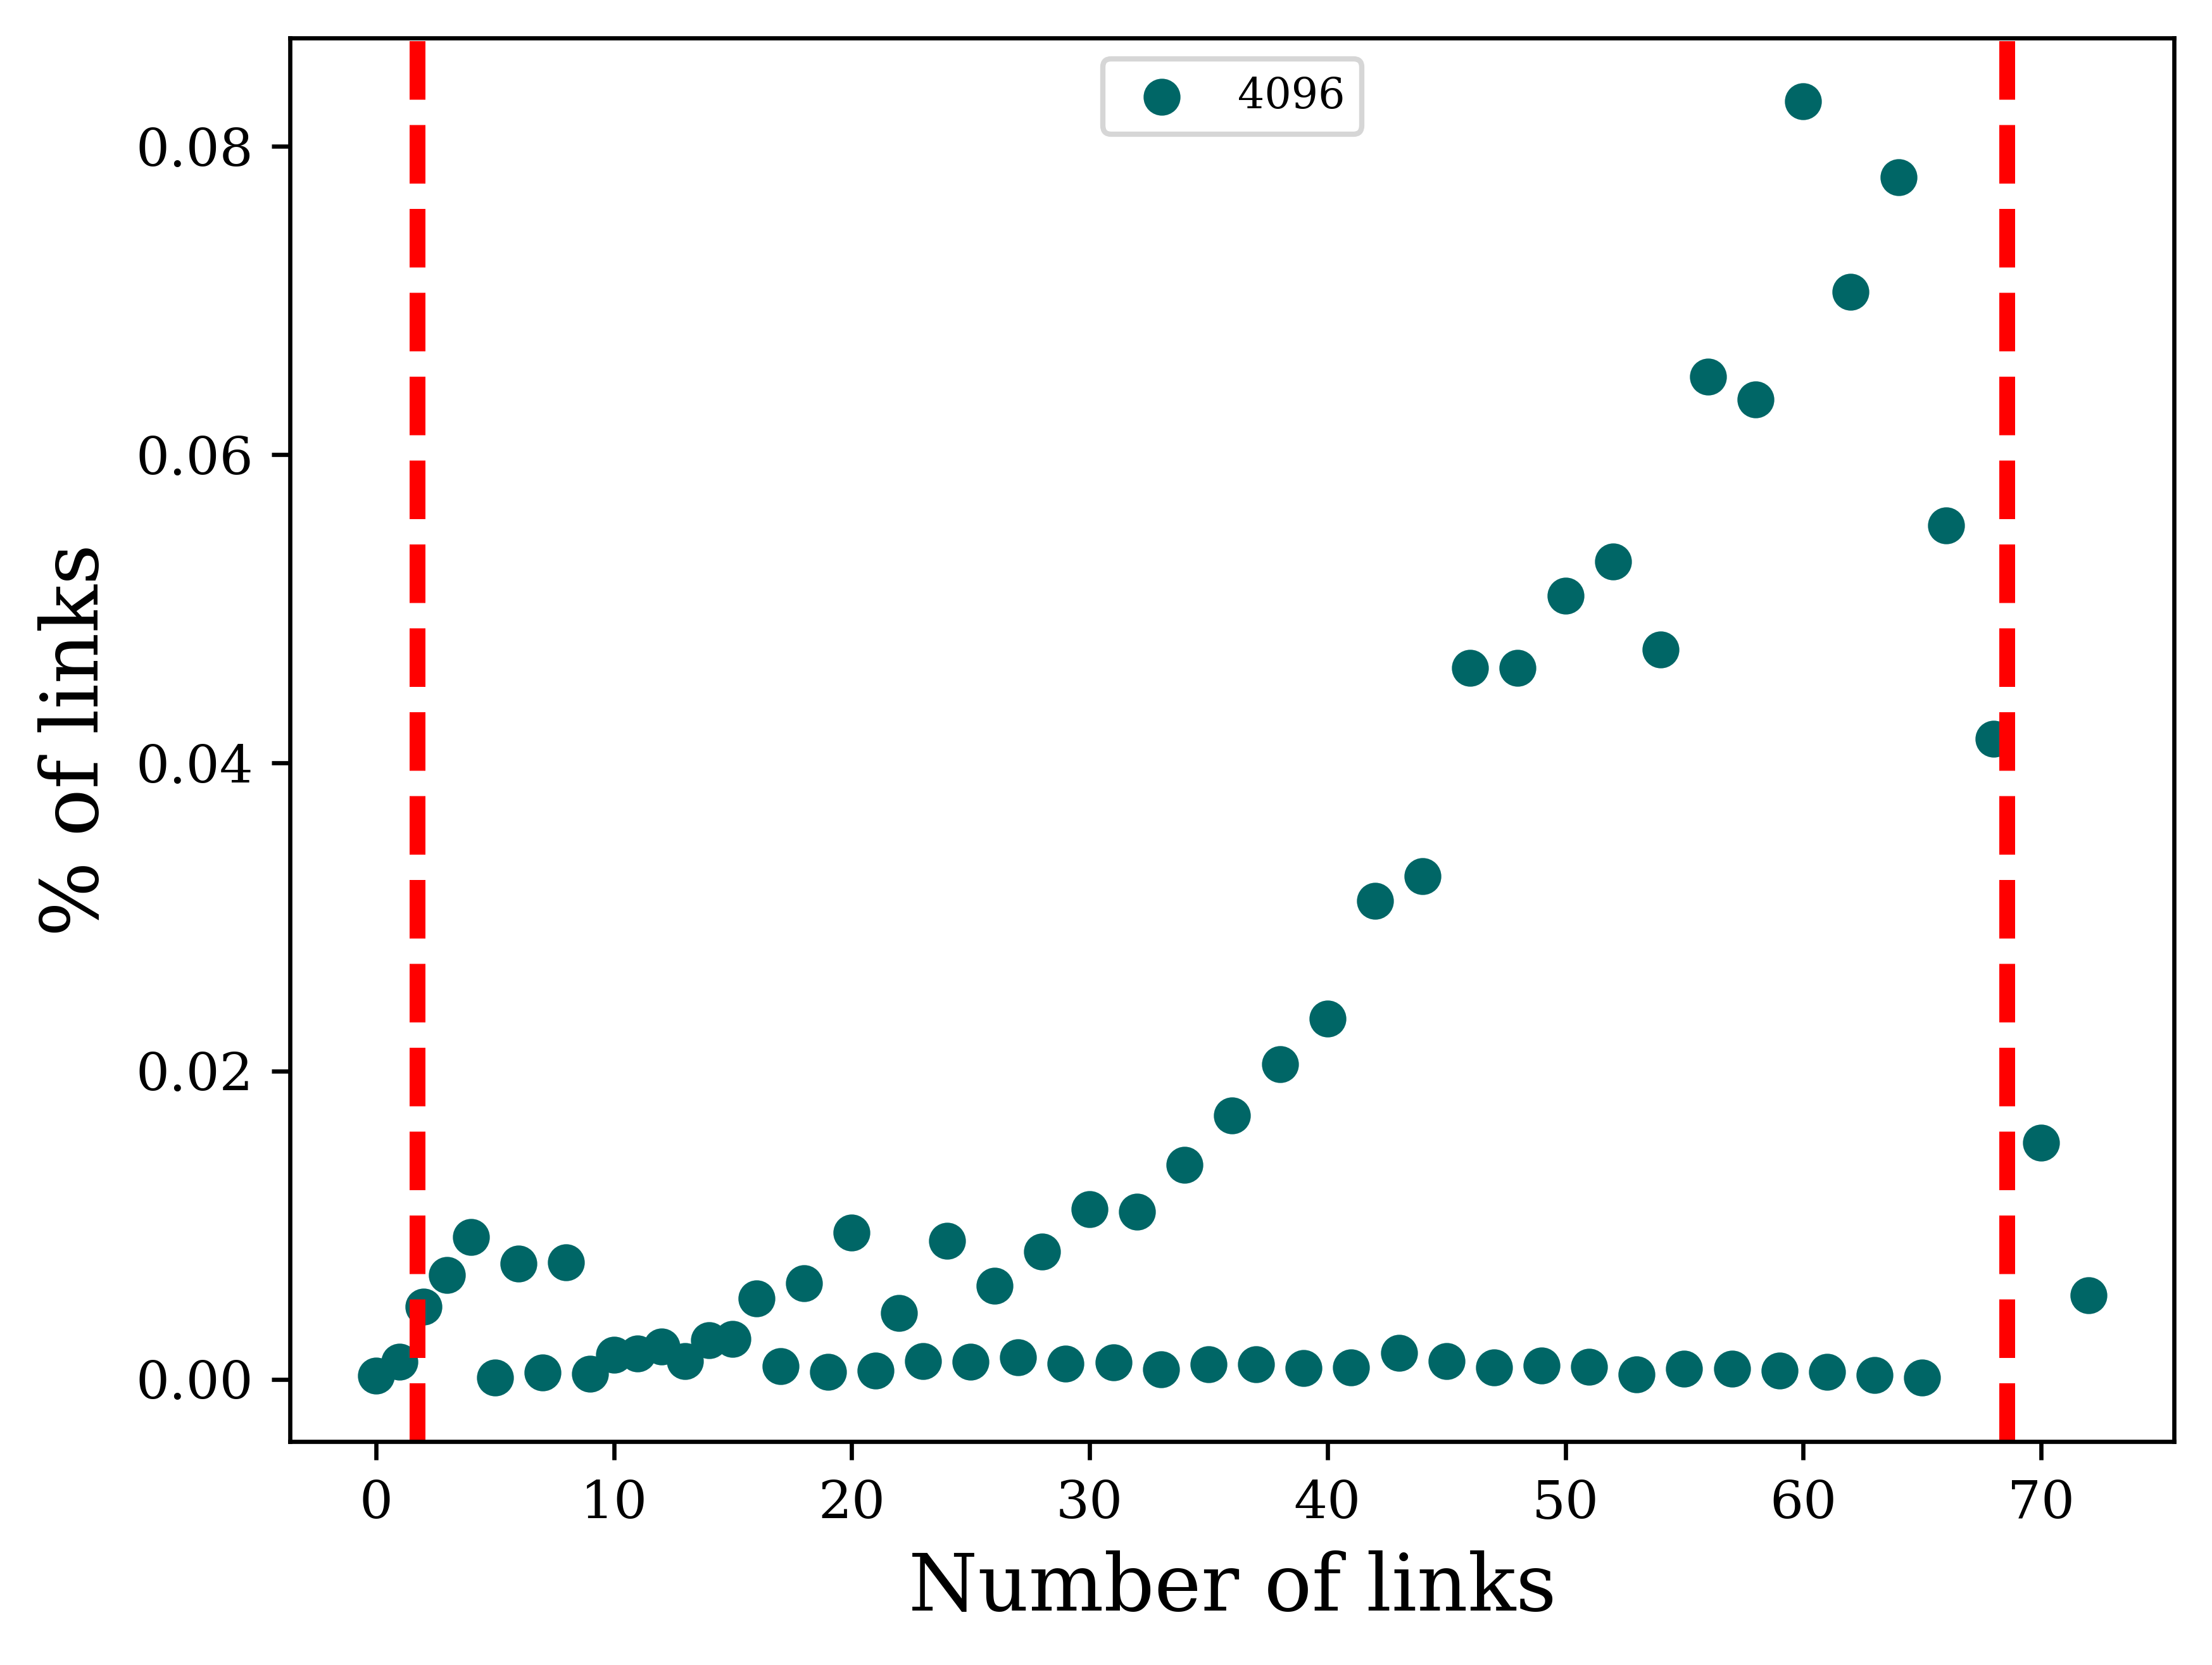

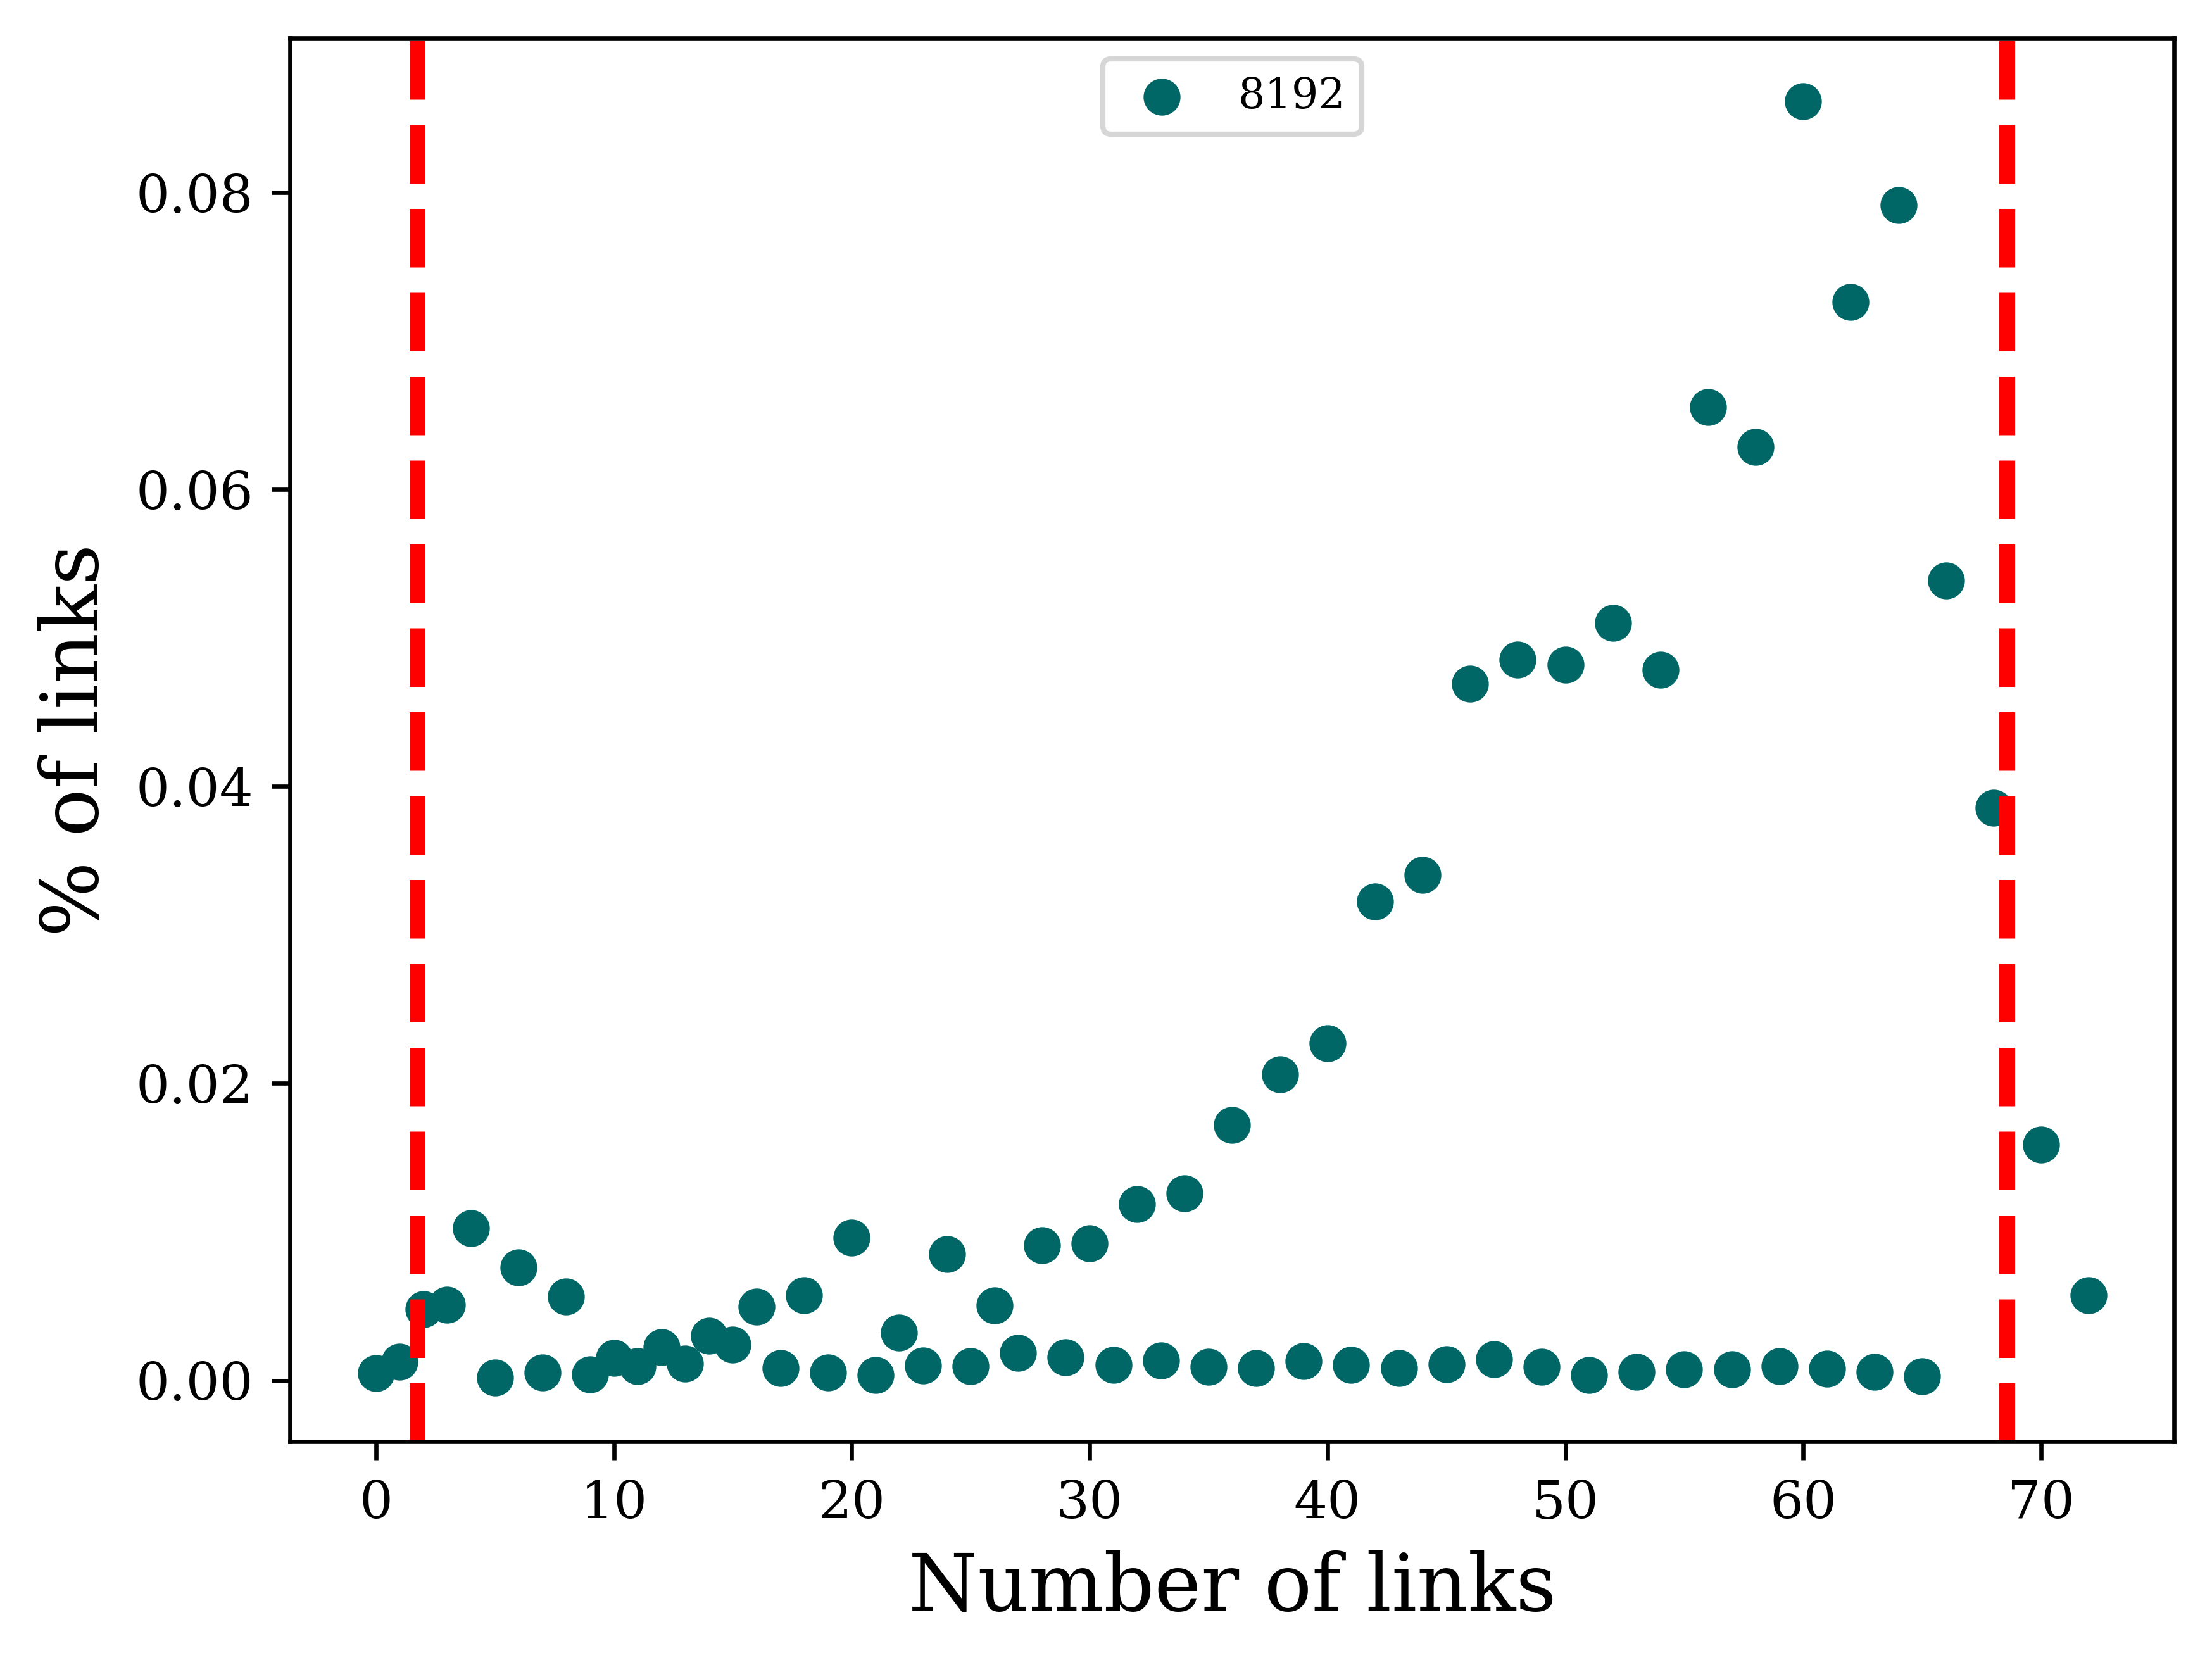

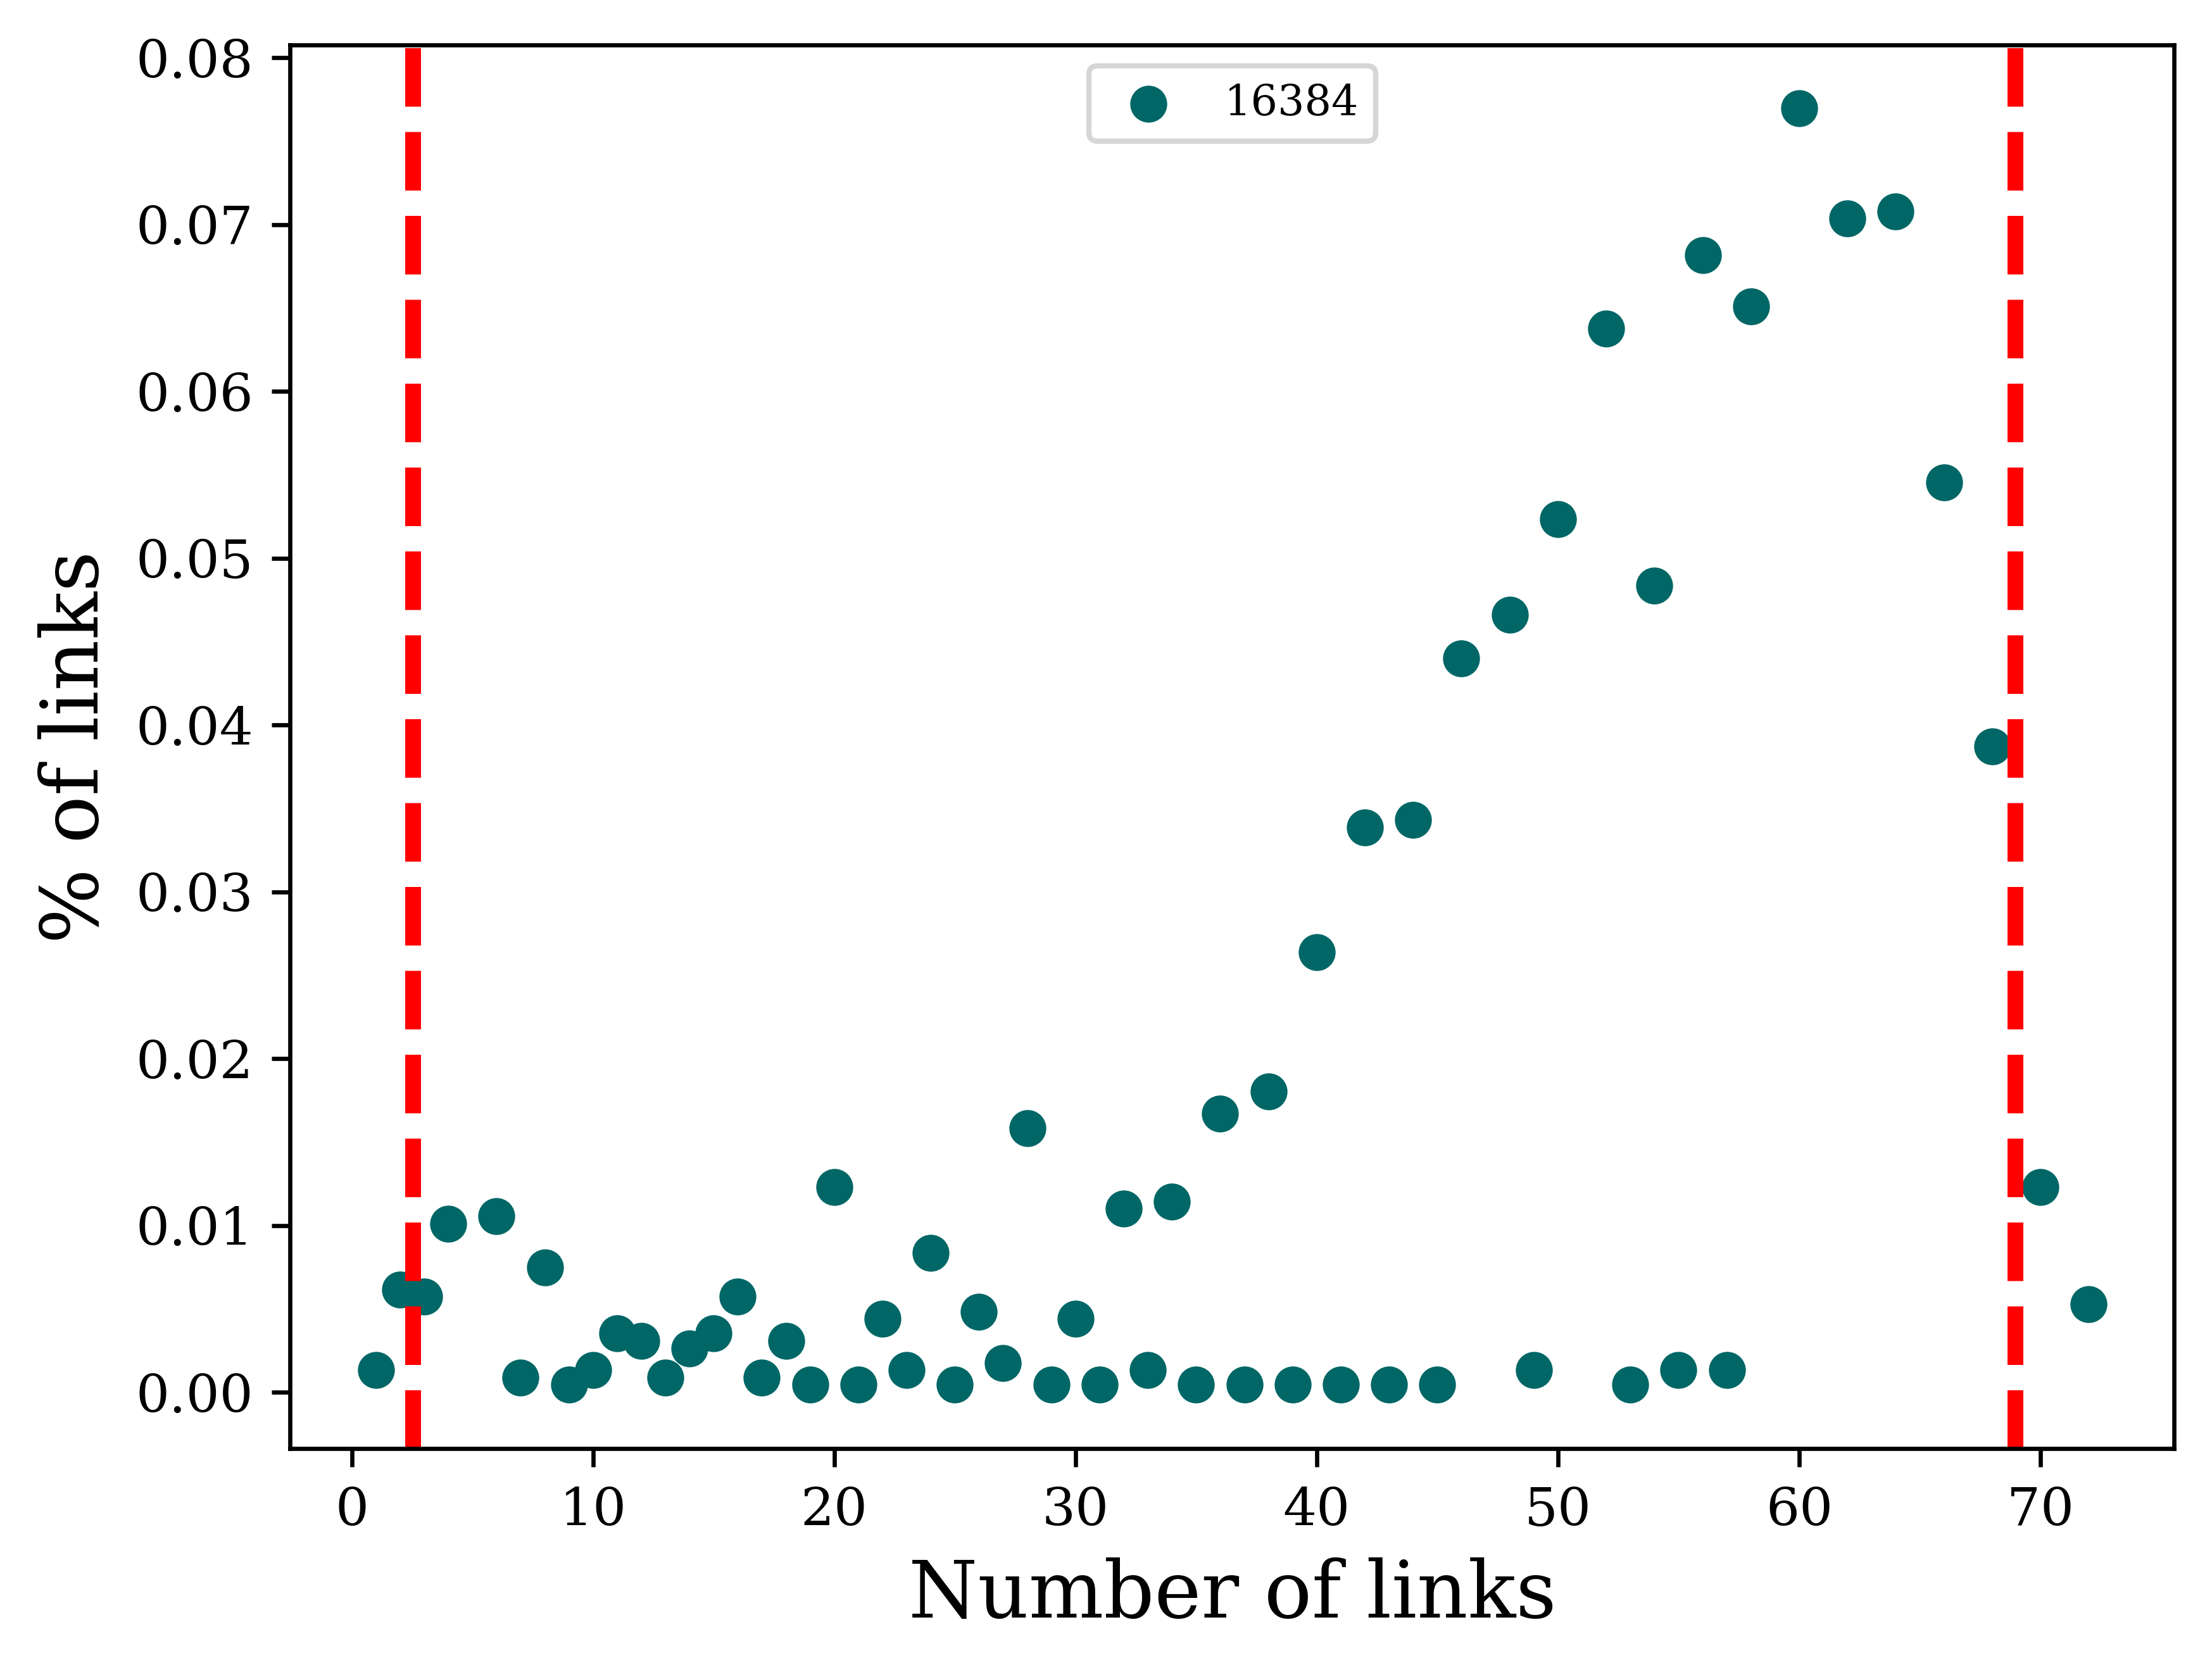

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

for ts in fr.keys():
    dist_ts = fr[ts]
    x = sorted(dist_ts.keys())
    dados = x
    y = np.array([dist_ts[i] for i in x])
    y_normalized = y / sum(y)

    # Cálculo dos percentis para 95% dos dados
    lower_percentile = np.percentile(dados, 2.5)
    upper_percentile = np.percentile(dados, 97.5)

    # Plot
    plt.figure(dpi=600)
    plt.scatter(x, y_normalized, color='#006666', label='%d' % ts)
    plt.xlabel("Number of links")
    plt.ylabel("% of links")

    # Desenhando linhas verticais para os percentis
    plt.axvline(x=lower_percentile, color='red', linestyle='--')
    plt.axvline(x=upper_percentile, color='red', linestyle='--')

    plt.legend()
    plt.show()

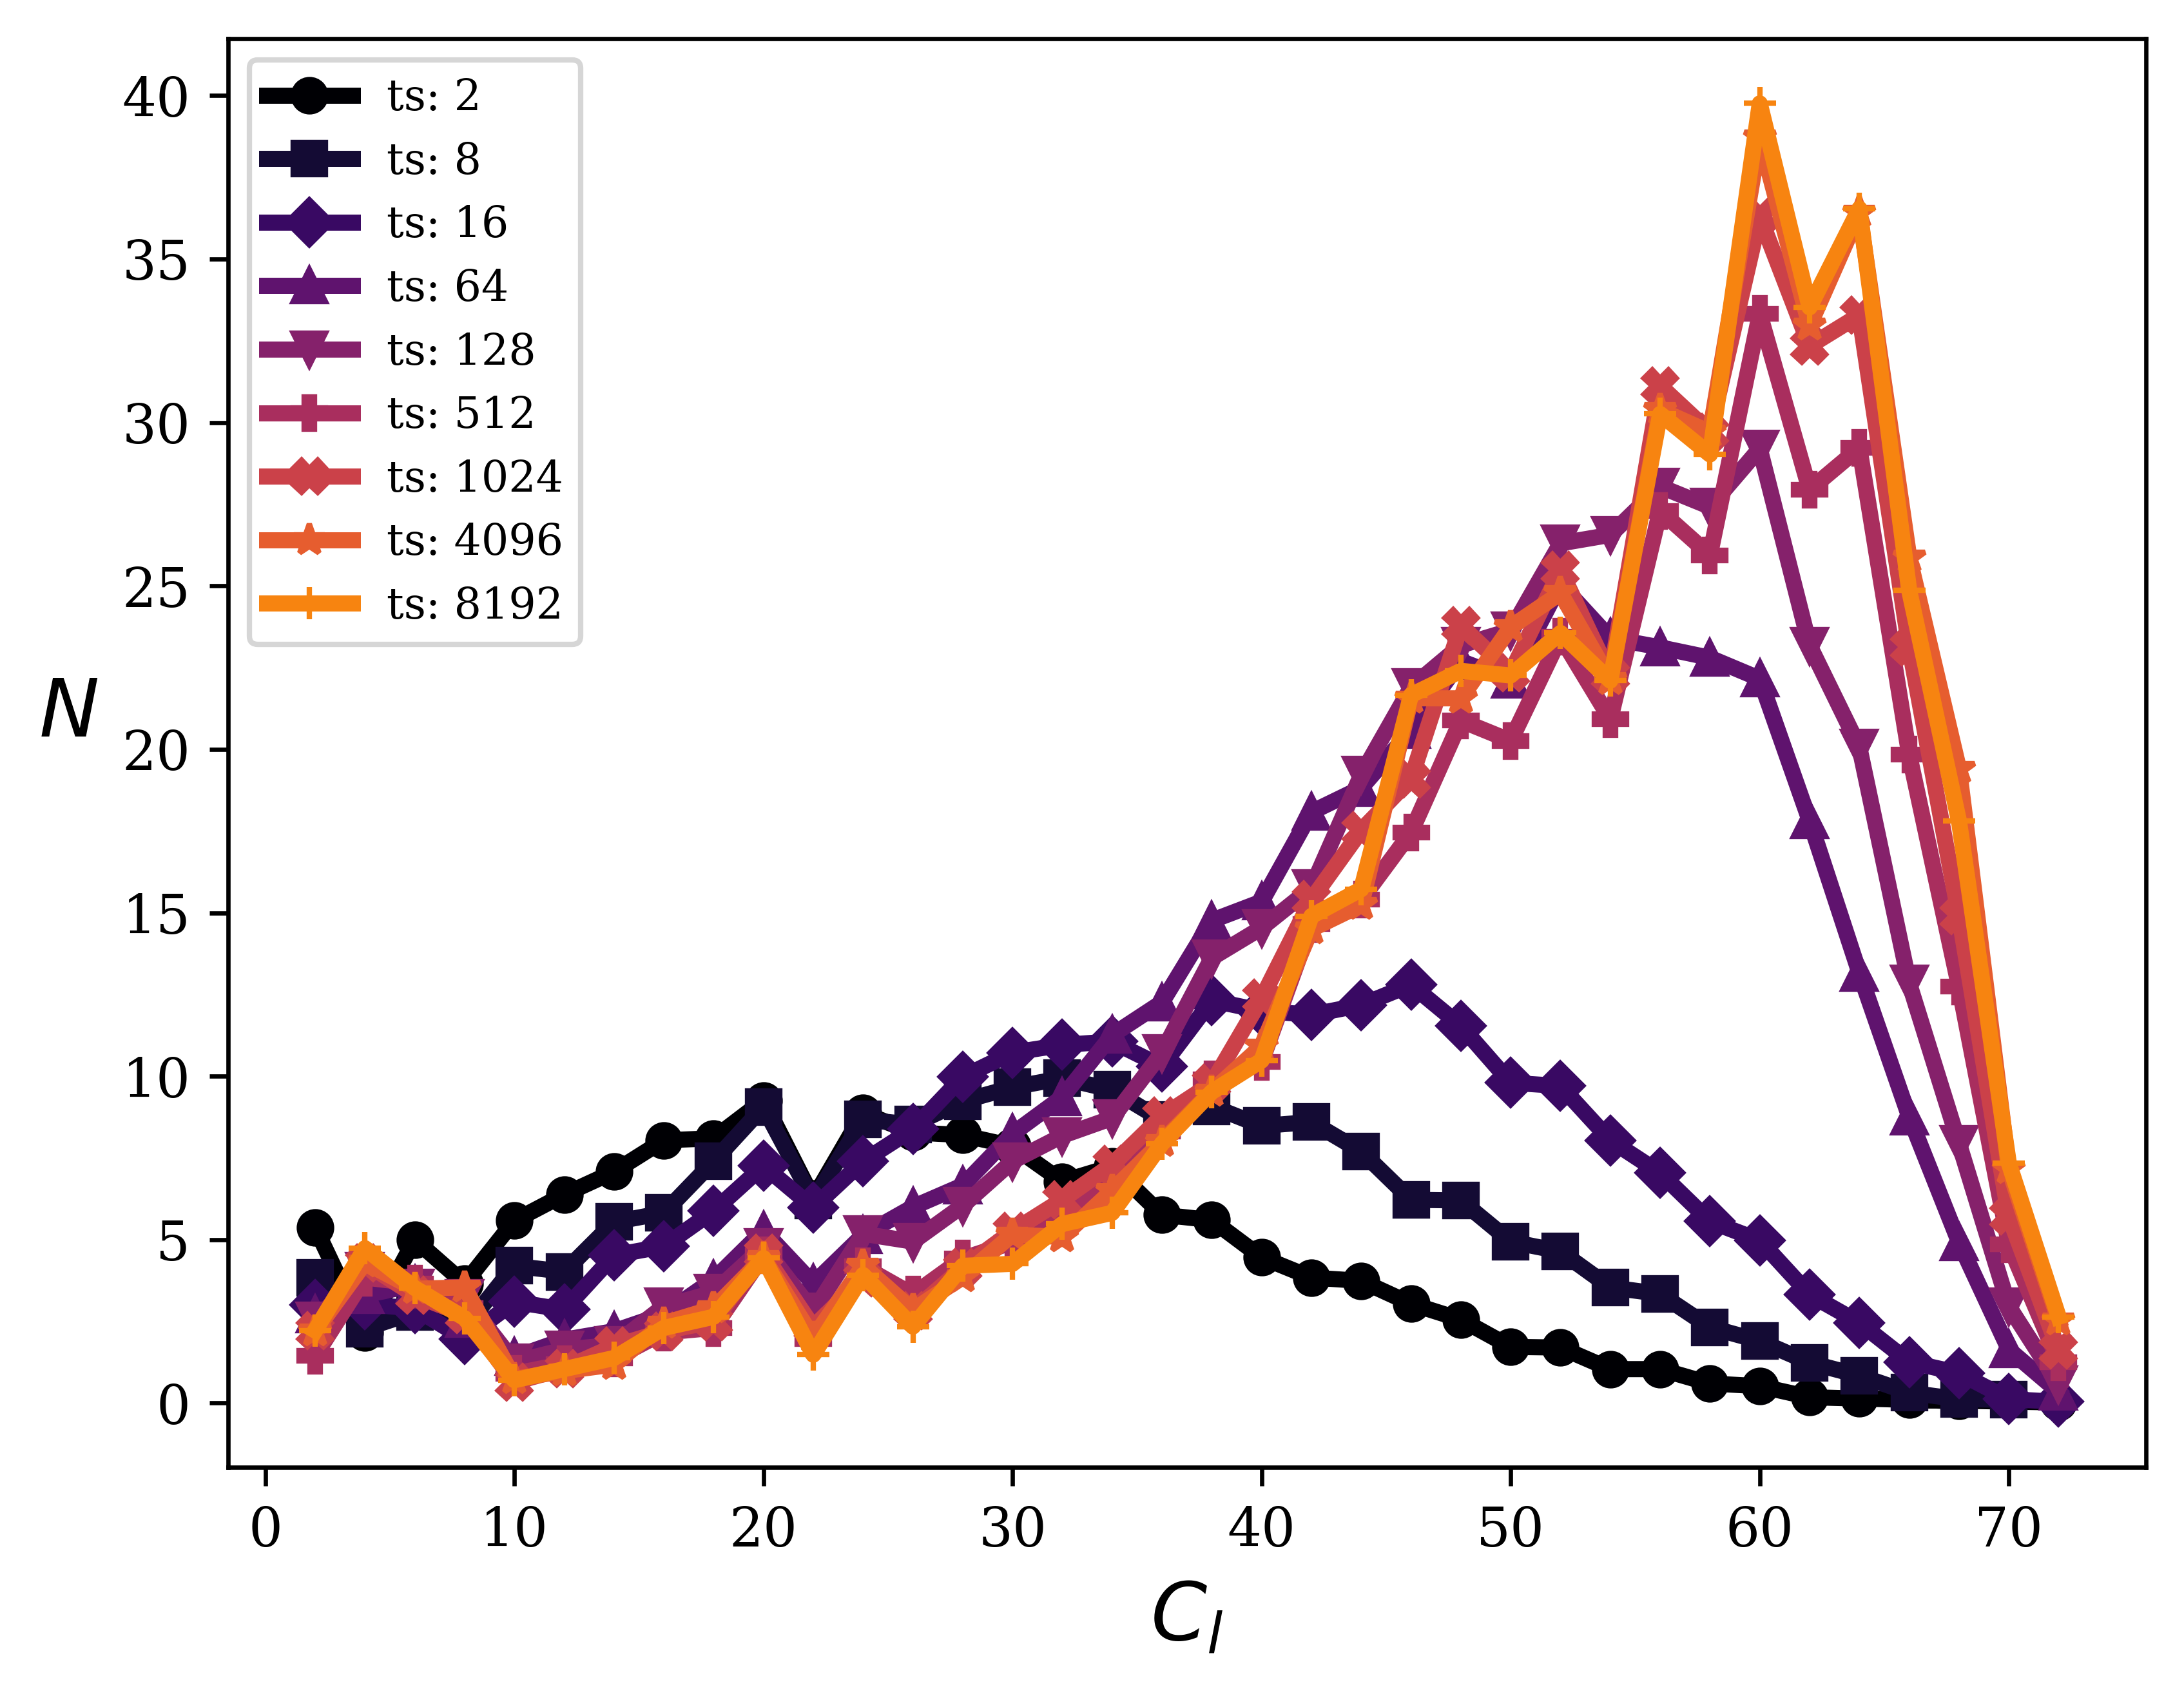

In [7]:
plt.figure(dpi=600)
i = 0

# Plotando as curvas para cada valor de ts em um mesmo gráfico
for ts, values in fr.items():
    x = np.array(list(values.keys()))
    y = np.array(list(values.values()))
    
    # Ignorando os valores de x igual a zero
    non_zero_indices = x != 0
    plt.plot(x[non_zero_indices][x[non_zero_indices] % 2 == 0], y[non_zero_indices][x[non_zero_indices] % 2 == 0]/50,marker = markers[i], c = colors[i], label=f'ts: {ts}')
    i+=1
# Adicionando rótulos e título ao gráfico
plt.xlabel(r'$C_{l}$')
plt.ylabel(r'$N$', rotation=0, labelpad=10)

plt.legend()
plt.show()


In [1]:
fr[2]


NameError: name 'fr' is not defined

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Substitua isso pelo seu dicionário de distribuição
# Exemplo: distribuicao = {0: 0.1, 1: 0.2, 2: 0.4, 3: 0.2, 4: 0.1}
distribuicao = fr[2]

# Convertendo o dicionário em um array para análise
valores, densidades = zip(*distribuicao.items())
valores = np.array(valores)
densidades = np.array(densidades)

# Normalizando as densidades para obter frequências (se necessário)
densidades /= densidades.sum()

# Gerando dados para análise com base nas densidades
dados = np.random.choice(valores, size=10000, p=densidades)

# Estatísticas Descritivas
media = np.mean(dados)
mediana = np.median(dados)
desvio_padrao = np.std(dados)
print("Média:", media)
print("Mediana:", mediana)
print("Desvio Padrão:", desvio_padrao)

# Histograma
plt.hist(dados, bins=len(valores), density=True, alpha=0.6, color='g')
plt.title("Histograma dos Dados")
plt.xticks(valores)
plt.show()

# Teste de Shapiro-Wilk para Normalidade
shapiro_test = stats.shapiro(dados)
print("Teste de Shapiro-Wilk: Estatística =", shapiro_test[0], ", p-valor =", shapiro_test[1])

# QQ-Plot
stats.probplot(dados, dist="norm", plot=plt)
plt.title("QQ-Plot")
plt.show()
